# MULTIVIEW CLUSTERING

## Workspace Setup

### Packages

In [1]:
from   sklearn.experimental    import enable_iterative_imputer
from   tqdm                    import tqdm
import copy                    as     cp
import jupyterthemes           as     jt
import matplotlib              as     mpl
import matplotlib.pyplot       as     plt
import matplotlib_venn         as     mpv
import mvlearn.cluster         as     mvc
import numpy                   as     np
import pandas                  as     pd
import scipy.cluster.hierarchy as     sch
import scipy.io                as     spi
import scipy.spatial.distance  as     ssd
import scipy.stats             as     sps
import sklearn.cluster         as     skc
import sklearn.decomposition   as     skd
import sklearn.impute          as     ski
import sklearn.manifold        as     skma
import sklearn.metrics         as     skme
import sklearn.neighbors       as     skn
import sklearn.preprocessing   as     skp
import sklearn.ensemble        as     ske
import warnings

### Global Variables

In [2]:
# ignore minor warnings
warnings.filterwarnings("ignore")

# use jupytertheme for plots
jt.jtplot.style()

# set font for plots
mpl.rcParams.update({'font.size':6})

# set global path
main_dir = '/cluster/work/borgw/SPSS/MultiOmicsAnalysis/'
sngl_dir = 'SingleView/ConsensusClustering/data/Clustering_silhouette/' 

# clustering
args = {}
args['kmeans']   = {'n_clusters':3}
args['dbscan']   = {'eps':1.5,\
                    'min_samples':5}
args['spectral'] = {'n_clusters':3,\
                    'affinity':'rbf',\
                    'gamma':1.,\
                    'assign_labels':'discretize'}

### Functions

In [3]:
def fstat_fig_1vR(dat_df,f_df,label):

    col  = '%s_cluster' % label
    clus = [c for c in dat_df[col].unique() if c!=-1]
    n    = len(clus)
    
    kw  = {'density':True,'alpha':.667}
    
    fig = plt.figure(figsize=(32,n*4.5))

    for j,c in enumerate(clus):
        
        p     = 'p_%d' % c
        f     = 'f_%d' % c
        cf_df = f_df[[p,f]]
        cf_df = cf_df.sort_values([p,f],ascending=[True,False])
    
        for i,v in enumerate(cf_df.index[:5]):

            bs = np.linspace(int(dat_df[v].min()),int(dat_df[v].max()),25)
            ax = fig.add_subplot(n,5,j*5+i+1)

            m1 = np.round(dat_df.loc[dat_df[col]==c,v].mean(),1)
            m2 = np.round(dat_df.loc[dat_df[col]==c,v].median(),1)
            n1 = np.round(dat_df.loc[dat_df[col]==c,v].shape[0],1)
            ax.hist(dat_df.loc[dat_df[col]==c,v],bins=bs,**kw,\
                    label=r'$n$=%s, $\mu$=%s, $m$=%s' % (n1,m1,m2))

            m3 = np.round(dat_df.loc[dat_df[col]!=c,v].mean(),1)
            m4 = np.round(dat_df.loc[dat_df[col]!=c,v].median(),1)
            n2 = np.round(dat_df.loc[dat_df[col]!=c,v].shape[0],1)
            ax.hist(dat_df.loc[dat_df[col]!=c,v],bins=bs,**kw,\
                    label=r'$n$=%s, $\mu$=%s, $m$=%s' % (n2,m3,m4))

            ax.set_title(v)
            ax.legend()
            
            if i==4:
                ax.set_ylabel('cluster %s' % str(int(j+1)))
                ax.yaxis.set_label_position("right")

    plt.close()
    
    return fig

def f_pvalues_1vR(dat_df,dct,c,l):
    
    f0 = 'ConsensusClustering/data/%s_fstats_%d_1vR.csv' % (c,int(100*l))
    
    try:
        
        ovrf_df    = pd.read_csv('%s%s' % (main_dir,f0), index_col=0)
        
    except:
    
        c       = '%s_cluster' % c
        ccols   = dct['continuous']
        bcols   = dct['binary']
        cols    = ccols+bcols 
        n       = int(np.ceil(len(cols)/l-1))
        ovrf_df = pd.DataFrame(index=cols)
        
        # loop over clusters
        for clu in [c for c in dat_df[c].unique() if c!=-1]:
            
            clu_df = dat_df.copy(deep=True)
            clu_df.loc[clu_df[c]!=clu] = 99
        
            # F-Test
            f_df    = pd.DataFrame(index=cols,columns=['p_value'])
            f_df    = pd.concat([f_df,f_stats(clu_df[ccols+[c]],c)],\
                                join='outer',axis=1)
            
            null_df = pd.DataFrame(index=ccols)

            for p in tqdm(range(n-1)):

                perm_df    = clu_df.copy()
                perm_df[c] = np.random.permutation(perm_df[c])
                null_df    = pd.concat(\
                                    [null_df,f_stats(perm_df[ccols+[c]],c)],\
                                    join='outer',axis=1)
                null_df    = null_df.rename(columns={'f_stat':p+1})

            for i in ccols:

                f   = f_df.loc[i,'f_stat']
                fs  = null_df.loc[i,:].values
                fs  = np.append(fs,f)
                pv  = fs[fs>=f].shape[0]/n
                f_df.loc[i,'p_value'] = pv
                
            # Fisher-test
            p_df = fisher_pvalues(dat_df[cols+[c]],bcols,c,l)
            f_df.loc[bcols,'p_value'] = p_df.loc[bcols,'p_value'].values
            
            # significance filtering
            f_df[f_df.p_value>1/n]=np.nan
            
            ovrf_df = pd.concat([ovrf_df,f_df],join='outer',axis=1)
            ovrf_df = ovrf_df.rename(columns={'f_stat' :'f_%d' % clu,\
                                              'p_value':'p_%d' % clu})

        ovrf_df = np.round(ovrf_df,6)
        ovrf_df.to_csv('%s%s' % (main_dir,f0))
        
    return ovrf_df

def fisher_pvalues(dat_df,test_cs,c,l):
    
    p_df = pd.DataFrame(index=test_cs,columns=['p_value'])
    
    for i in p_df.index:
        
        con_tab = np.empty((2,2))
        C = dat_df[c] == 1
        V = dat_df[i] == 1
        con_tab[0,0] = dat_df[C&V].shape[0]
        con_tab[0,1] = dat_df[C&~V].shape[0]
        con_tab[1,0] = dat_df[~C&V].shape[0]
        con_tab[1,1] = dat_df[~C&~V].shape[0]
        
        o,pv = sps.fisher_exact(con_tab)
        p_df.loc[i,'p_value'] = pv
        
    p_df = p_df.sort_values('p_value')
    p_df.loc[p_df.p_value<l/p_df.shape[0],'p_value'] = np.nan
    
    return p_df

def protein_f_association(dat_df,bims,label,test_cs,l,ttype):

    bimdat_df = pd.DataFrame(index=bims,columns=test_cs)

    for p in bims:

        c         = '%sbim%s_cluster' % (p,label)
        bim_df    = dat_df.copy(deep=True)
        cols      = [c for c in bim_df.columns if c in test_cs]+[p]
        bim_df    = bim_df[cols]
        bim_df[c] = 0
        
        if label=='proteome':
             bim_df.loc[(bim_df[p]<=bims[p]).T.values[0],c] = 1
        else:
            bim_df.loc[bim_df[p]<=bims[p],c] = 1
        
        bim_df = bim_df.drop(p,axis=1)    
        l2     = l*len(test_cs)/dat_df.shape[1]

        if ttype=='f-test':
            f_df,null_df = f_pvalues(bim_df,'%sbim%s' % (p,label),l2)
        elif ttype=='fisher':
            f_df = fisher_pvalues(bim_df,test_cs,c,l2)
        
        f_df         = f_df[f_df.p_value>=l2]
        bimdat_df.loc[p,f_df.index] = 1

    bimdat_df = bimdat_df.fillna(0)

    bimdat_pdf = bimdat_df.sum(axis=0).sort_values(ascending=False)
    bimdat_bdf = bimdat_df.sum(axis=1).sort_values(ascending=True)
    bimdat_df = bimdat_df.loc[bimdat_bdf.index,bimdat_pdf.index]

    bimdat_fig = plt.figure(figsize=(16,9))
    ax = bimdat_fig.add_subplot(111)
    ax.pcolor(bimdat_df)
    ax.set_yticks(np.arange(bimdat_df.shape[0])+.5)
    ax.set_yticklabels(bimdat_df.index)
    ax.set_xticks(np.arange(bimdat_df.shape[1])+.5)
    if label=='proteome':
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(bimdat_df.columns,rotation=45,ha='right')
    ax.grid('lightgray')
    plt.close()
    
    return bimdat_fig,bimdat_df

def hierarchical_cluster(dat_df,p):
    
    X = dat_df
    D = ssd.pdist(X)
    Z = sch.linkage(D,'ward')
    
    clu_df           = dat_df.copy(deep=True)
    clu_df['hieclu'] = sch.fcluster(Z,p,'maxclust')-1

    fig = plt.figure(figsize=(24,9))
    ax  = fig.add_subplot(111)
    ax.grid()
    sch.dendrogram(Z,
                   labels=dat_df.index,
                   truncate_mode='lastp',
                   p=p,
                   ax=ax,
                   leaf_rotation=45)
    plt.close()
    
    return fig,clu_df

def fstat_fig(dat_df,f_df,label):

    col = '%s_cluster' % label
    kw  = {'density':True,'alpha':.667}
    
    fig = plt.figure(figsize=(40,9))

    for i,v in enumerate(f_df.index[:10]):

        bs = np.linspace(int(dat_df[v].min()),int(dat_df[v].max()),25)
        ax = fig.add_subplot(2,5,i+1)

        for c in [d for d in dat_df[col].unique() if d!=-1]:
            m1 = np.round(dat_df.loc[dat_df[col]==c,v].mean(),1)
            m2 = np.round(dat_df.loc[dat_df[col]==c,v].median(),1)
            n  = np.round(dat_df.loc[dat_df[col]==c,v].shape[0],1)
            ax.hist(dat_df.loc[dat_df[col]==c,v],bins=bs,**kw,\
                    label=r'$n$=%s, $\mu$=%s, $m$=%s' % (n,m1,m2))

        ax.set_title(v)
        ax.legend()

    plt.close()
    
    return fig

def f_stats(df,c):
    
    cs = [c for c in df[c].unique() if c!=-1]
    k  = len(cs)
    
    if k==1:
        print('no clusters')
    elif k==2:
        c0 = df.loc[df[c]==cs[0],:].values
        c1 = df.loc[df[c]==cs[1],:].values
        f,p = sps.f_oneway(c0,c1)
    elif k==3:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        f,p = sps.f_oneway(c0,c1,c2)
    elif k==4:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3)
    elif k==5:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4)
    elif k==6:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5)
    elif k==7:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6)
    elif k==8:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7)
    elif k==9:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8)
    elif k==10:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9)
    elif k==11:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10)
    elif k==12:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11)
    elif k==13:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12)
    elif k==14:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13)
    elif k==15:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        c14 = df.loc[df[c]==14,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14)
    elif k==16:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        c14 = df.loc[df[c]==14,:].values
        c15 = df.loc[df[c]==15,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15)
    elif k==17:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        c14 = df.loc[df[c]==14,:].values
        c15 = df.loc[df[c]==15,:].values
        c16 = df.loc[df[c]==16,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16)
    elif k==18:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        c14 = df.loc[df[c]==14,:].values
        c15 = df.loc[df[c]==15,:].values
        c16 = df.loc[df[c]==16,:].values
        c17 = df.loc[df[c]==17,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17)
    elif k==19:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        c14 = df.loc[df[c]==14,:].values
        c15 = df.loc[df[c]==15,:].values
        c16 = df.loc[df[c]==16,:].values
        c17 = df.loc[df[c]==17,:].values
        c18 = df.loc[df[c]==18,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18)
    elif k==20:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        c14 = df.loc[df[c]==14,:].values
        c15 = df.loc[df[c]==15,:].values
        c16 = df.loc[df[c]==16,:].values
        c17 = df.loc[df[c]==17,:].values
        c18 = df.loc[df[c]==18,:].values
        c19 = df.loc[df[c]==19,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19)
        
    fs_df = pd.DataFrame(f,index=df.columns,columns=['f_stat'])
    fs_df = fs_df.drop(c,axis=0)
    fs_df = fs_df.sort_values('f_stat',ascending=False)
    
    return fs_df

def assign_clusters(dat_df,clu_df,label,ccol):
    
    col = '%s_cluster' % label
    
    if col not in dat_df.columns:

        sv_df = pd.concat([dat_df,clu_df[ccol]],axis=1)
        c_dct = {}
        c_dct[ccol] = col

        for c in clu_df.columns:
            if 'ts' in c:
                c_dct[c] = '%s_%s' % (label,c)

        sv_df = sv_df.rename(columns=c_dct)
        
    else:
        
        sv_df = dat_df
    
    return sv_df

def ortho_project(dat_df,sub_df):
    
    ort_df = dat_df.copy(deep=True)
    
    for c in sub_df.columns:
        
        prj_df = np.outer(np.dot(sub_df[c],dat_df)/np.dot(sub_df[c],sub_df[c]),sub_df[c]).T
        ort_df = ort_df-prj_df
    
    return ort_df

def projection(dat_df,sub_df):
    
    prj_df = np.matmul(dat_df,sub_df.T)
    prj_df = prj_df.rename(columns={0:'p0',1:'p1',2:'p2'})
    
    return prj_df
 
def f_pvalues(dat_df,c,l):
    
    f0 = 'ConsensusClustering/data/%s_H0_fstats_%d.csv' % (c,int(100*l))
    f1 = 'ConsensusClustering/data/%s_fstats_%d.csv' % (c,int(100*l))
    
    try:
        
        f_df    = pd.read_csv('%s%s' % (main_dir,f1), index_col=0)
        null_df = pd.read_csv('%s%s' % (main_dir,f0), index_col=0)
        
    except:
    
        c       = '%s_cluster' % c
        cols    = [col for col in dat_df.columns if col!=c]
        n       = int(np.ceil(len(cols)/l-1))
        f_df    = pd.DataFrame(index=cols,columns=['p_value'])
        f_df    = pd.concat([f_df,f_stats(dat_df,c)],join='outer',axis=1)

        null_df = pd.DataFrame(index=cols)

        for p in tqdm(range(n-1)):

            perm_df    = dat_df.copy()
            perm_df[c] = np.random.permutation(perm_df[c])
            null_df    = pd.concat([null_df,f_stats(perm_df,c)],\
                                   join='outer',axis=1)
            null_df    = null_df.rename(columns={'f_stat':p+1})

        for i in f_df.index:

            f   = f_df.loc[i,'f_stat']
            fs  = null_df.loc[i,:].values
            fs  = np.append(fs,f)
            pv  = fs[fs>=f].shape[0]/n
            f_df.loc[i,'p_value'] = pv

        f_df = f_df.sort_values(['p_value','f_stat'],ascending=[True,False])
        f_df = f_df.dropna()
        f_df = f_df[f_df.p_value>=l/len(cols)]
        f_df = np.round(f_df,6)
        
        f_df.to_csv('%s%s' % (main_dir,f1))
        null_df.to_csv('%s%s' % (main_dir,f0))
        
    return f_df,null_df

def cluster(dat_df,algo):
    
    if   algo=='kmeans':
        clu = skc.KMeans(**args[algo]).fit(dat_df)
    elif algo=='dbscan':
        clu = skc.DBSCAN(**args[algo]).fit(dat_df)
    elif algo=='spectral':
        clu = skc.SpectralClustering(**args[algo]).fit(dat_df)
    
    lab_df= pd.DataFrame(clu.labels_,columns=[algo],index=dat_df.index)
    
    return lab_df

def pca_var(dat_df,ev,label):

    dat_df = (dat_df-dat_df.sum())/dat_df.std()
    n      = dat_df.shape[1]
    pca    = skd.PCA(n_components=n)
    pca_ft = pca.fit(dat_df)
    pca_ev = pca_ft.explained_variance_ratio_
    pca_cv = np.array([sum(pca_ev[:i]) for i in range(1,n+1)])
    pca_n  = pca_cv[pca_cv<ev].shape[0]+1
    pca_df = pd.DataFrame(pca.fit_transform(dat_df),\
                columns=['%spc_%d' % (label,i+1) for i in range(n)],\
                index = dat_df.index)
    pca_df = pca_df[pca_df.columns[:pca_n]]
    
    transf  = pca.components_
    loads   = np.concatenate([np.absolute(transf),np.sign(transf)]).T
    comp_df = pd.DataFrame(loads,\
                           columns = np.arange(2*n)+1,\
                           index=dat_df.columns)
    
    comp_df[np.arange(n)+1]     = comp_df[np.arange(n)+1]/\
                                  comp_df[np.arange(n)+1].sum()
    comp_df[np.arange(n)+1]     = np.round(100*comp_df[np.arange(n)+1])
    comp_df[np.arange(n)+1]     = comp_df[np.arange(n)+1].astype(int)
    comp_df[np.arange(n,2*n)+1] = comp_df[np.arange(n,2*n)+1].astype(int)
    
    return pca_df,comp_df

def tsne(dat_df,pars,states):

    pars0 = {}
    pars0['learning_rate']      = 'auto'
    pars0['init']               = 'random'
    pars0['method']             = 'exact'

    pars_df = pd.DataFrame(index=states,columns=['kl_div'])

    for r in tqdm(states):
        tsne = skma.TSNE(random_state=r,**pars0,**pars).fit(dat_df)
        pars_df.loc[r,'kl_div'] = tsne.kl_divergence_

    state   = pars_df.index[pars_df.kl_div==pars_df.kl_div.min()][0]
    tsne    = skma.TSNE(random_state=state,**pars0,**pars)\
                  .fit_transform(dat_df)
    cols    = ['ts%d' % d for d in range(1,pars['n_components']+1)]
    tsne_df = pd.DataFrame(tsne,index=dat_df.index,columns=cols)
    
    return tsne_df,state

def cluster_optimization(dat_df,n_states,n_comps,epsilons,min_samples,label):
    
    f = 'ConsensusClustering/data/%s_cluster_optimization_%d.csv' % (label,n_states)
    
    try:
        
        df = pd.read_csv('%s%s' % (main_dir,f), index_col=0)
        
    except:
    
        cs = ['dim','state','epsilon','n_mins','n_clusters','silhouette']
        df = pd.DataFrame(index=range(len(n_comps)*len(epss)),columns=cs)

        i = 0
        for n_comp in n_comps:

            # t-SNE
            tsne_pars = {'perplexity':30.,'n_components':n_comp}
            ts,state  = tsne(dat_df,tsne_pars,states=range(n_states))

            for eps in epss:

                for mins in minss:

                    # DBSCAN
                    args['dbscan']   = {'eps':eps,'min_samples':mins}
                    cdf = cluster(ts,'dbscan')
                    nc  = len(cdf.loc[cdf.dbscan!=-1,'dbscan'].unique())
                    df.loc[i,'dim']        = n_comp
                    df.loc[i,'state']      = state
                    df.loc[i,'epsilon']    = eps
                    df.loc[i,'n_mins']     = mins
                    df.loc[i,'n_clusters'] = nc

                    # Silhouette
                    if nc>1:
                        sil_avg = skme.silhouette_score(ts,cdf.dbscan)
                        sil_avg = sil_avg*cdf[cdf.dbscan!=-1].shape[0]/cdf.shape[0]
                    else:
                        sil_avg = np.nan
                        
                    df.loc[i,'silhouette'] = sil_avg

                    i += 1

        NOTEMPTY = ~df.silhouette.isna()
        POSITIVE = df.silhouette>0
        CLUSTER  = df.n_clusters<18
        df   = df[NOTEMPTY&POSITIVE&CLUSTER]
        df   = df.sort_values('silhouette',ascending=False)

        df.to_csv('%s%s' % (main_dir,f))
    
    return df

def cluster_fig(ts,clu_df,col):
    
    ts_fig = plt.figure(figsize=(32,9))
    ax1 = ts_fig.add_subplot(121)
    ax2 = ts_fig.add_subplot(122)
    
    pts  = ts[clu_df[col]>=0]
    pcdf = clu_df[clu_df[col]>=0]
    sils = skme.silhouette_samples(ts,clu_df[col])

    y_lower = 1

    for c in sorted(clu_df[col].unique()):

        cdf     = clu_df[clu_df[col]==c]
        csils   = sils[clu_df[col]==c]
        csils   = csils[csils>=0]
        csils.sort()
        nc      = csils.shape[0]
        y_upper = y_lower+nc

        if c!=-1:
            cl = mpl.cm.tab20(c)
            ax1.scatter(x=cdf.ts1,y=cdf.ts2,color=cl,label='cluster %d' % int(c+1))
            ax2.fill_betweenx(np.arange(y_lower,y_upper),0,csils,fc=cl)
        else:
            ax1.scatter(x=cdf.ts1,y=cdf.ts2,label='outliers',color='black')
            ax2.fill_betweenx(np.arange(y_lower,y_upper),0,csils,fc='black')

        y_lower = y_upper+1
        
    ax1.legend()
    ax1.set_xticks([])
    ax1.set_yticks([])
    try:
        avgs = skme.silhouette_score(pts,pcdf[col])
        ax2.axvline(x=avgs,color='w')
    except:
        None
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,y_upper+1])
    ax2.set_yticklabels([])

    plt.close()
    
    return ts_fig

def optimal_clusters(dat_df,opt_df):

    i     = opt_df.index[opt_df.silhouette==opt_df.silhouette.max()]
    dim   = opt_df.loc[i,'dim'].values[0]
    state = opt_df.loc[i,'state'].values[0]
    eps   = opt_df.loc[i,'epsilon'].values[0]
    mins  = opt_df.loc[i,'n_mins'].values[0]

    tsne_pars   = {'perplexity':30.,'n_components':dim}
    ts_df,state = tsne(dat_df,tsne_pars,states=[state])

    args['dbscan'] = {'eps':eps,'min_samples':mins}
    lab_df         = cluster(ts_df,'dbscan')
    clu_df         = pd.concat([lab_df,ts_df],axis=1)
    
    return ts_df,clu_df

## Data

### Loading and Merging

In [4]:
f = '/olinks/spss_mlcb_olink_episode.csv'
epi_df = pd.read_csv('%s%s' % (main_dir,f), index_col=0)

# filter for episodes in which serum sampling happened within 6 days after bc
PERIOD = (epi_df['sample.intv.d'] <=6) & (epi_df['sample.intv.d'] >=0)
epi_df = epi_df[PERIOD]

f = 'Data/spss_mlcb_day.csv'
bc_df = pd.read_csv('%s%s' % (main_dir,f), index_col=['sample.id'])
bc_df = bc_df[bc_df['redcap.event.name']=='day_sampling']
bc_df = bc_df[bc_df['data.available'] == 'yes']

f = 'ConsensusClustering/data/All Panels_2022_2020_raw_NPX_olink.csv'
npx_df = pd.read_csv('%s%s' % (main_dir,f), index_col=0)

f = '/cluster/work/borgw/SPSS/spss_grm_pca_20220706/GRM_top10_PCs.csv'
grm_df = pd.read_csv('%s' % f,index_col=0)
grm_df = grm_df.rename(columns={'GRM PC 1':'grm_pc1','GRM PC 2':'grm_pc2',\
                                'GRM PC 3':'grm_pc3','GRM PC 4':'grm_pc4',\
                                'GRM PC 5':'grm_pc5','GRM PC 6':'grm_pc6',\
                                'GRM PC 7':'grm_pc7','GRM PC 8':'grm_pc8',\
                                'GRM PC 9':'grm_pc9','GRM PC 10':'grm_pc10'})

raw_df = pd.concat([epi_df,bc_df,grm_df,npx_df],join='inner',axis=1)
raw_df = raw_df.rename(columns={'age.at.bc.days':'age.at.bc'})
raw_df

,personal.id,episode.nr,study.site,eligibility,consent,consent.biob,age.at.bc,age.at.bc.months,age.at.bc.years,age.grp,...,Olink Target 96 Organ Damage(v.3311).82,Olink Target 96 Organ Damage(v.3311).83,Olink Target 96 Organ Damage(v.3311).84,Olink Target 96 Organ Damage(v.3311).85,Olink Target 96 Organ Damage(v.3311).86,Olink Target 96 Organ Damage(v.3311).87,Olink Target 96 Organ Damage(v.3311).88,Olink Target 96 Organ Damage(v.3311).89,Olink Target 96 Organ Damage(v.3311).90,Olink Target 96 Organ Damage(v.3311).91
BE-001,BE-001,0,Bern,eligible,yes,yes,2521,82,6,child.5y.9y,...,1.70159,3.48718,2.05995,3.76090,6.96531,4.18190,0.22963,2.45691,0.87458,1.74746
BE-003,BE-003,0,Bern,eligible,yes,yes,2285,75,6,child.5y.9y,...,3.59710,3.06095,2.04341,6.06249,6.69491,2.23101,1.37726,2.01789,1.63672,2.00566
BE-004,BE-004,0,Bern,eligible,yes,yes,717,23,1,child.1y.4y,...,1.73363,1.68708,2.19836,6.25993,5.32153,1.12803,1.08999,0.87993,0.04963,1.42964
BE-005,BE-005,0,Bern,eligible,yes,yes,4400,144,12,child.10y.16y,...,4.37900,3.18976,3.96052,7.78852,6.43559,2.50802,1.03539,0.41681,1.60899,2.15542
BE-007,BE-007,0,Bern,eligible,yes,yes,89,2,0,child.less12mt,...,3.08916,1.98271,4.14826,7.28065,7.33051,2.05212,1.72586,1.42252,0.78154,1.53606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZH-254,ZH-254,0,Zurich,eligible,yes,yes,41,1,0,child.less12mt,...,5.06552,2.87701,3.85969,10.63042,7.58074,1.53331,1.24035,1.68320,4.14710,2.54191
ZH-255,ZH-255,0,Zurich,eligible,yes,yes,12,0,0,neo.term,...,6.42122,2.89101,5.20275,10.70967,6.99078,3.31375,0.66809,1.16686,3.34361,3.40926
ZH-257,ZH-257,0,Zurich,eligible,yes,yes,360,11,0,child.less12mt,...,3.72867,2.44134,3.89944,9.87816,6.65984,2.61212,3.34854,0.92167,2.80111,1.77911
ZH-258,ZH-258,0,Zurich,eligible,yes,yes,57,1,0,child.less12mt,...,2.96162,2.31719,6.42890,6.05447,7.64716,1.46705,3.20317,1.93248,1.74769,1.80203


### Mapping to UniProt IDs

In [5]:
f = '/cluster/work/borgw/SPSS/o-link/20191053_Giannoni_NPX.csv'

map_df   = pd.read_csv('%s' % f)
map_df   = map_df.set_index('Uniprot ID',drop=True)
map_df   = map_df.drop(['Unnamed: 369','Unnamed: 370','Unnamed: 371',\
                        'Unnamed: 372','Unnamed: 373','Unnamed: 374',\
                        'Unnamed: 375','Unnamed: 376'],axis=1)

dict_df  = pd.DataFrame(map_df.loc['SG-053',:].T).reset_index()\
             .rename(columns={'index':'UniProtID'})
dict_df['SG-053'] = dict_df['SG-053'].astype(float)
dict2_df = pd.DataFrame(raw_df.loc['SG-053',:].T).reset_index()\
             .rename(columns={'index':'dat_col'})
dict_df  = dict_df.merge(dict2_df,on='SG-053',how='inner')

map_dict = pd.Series(dict_df.UniProtID.values,index=dict_df.dat_col)\
             .to_dict()

raw_df = raw_df.rename(columns=map_dict)

prots = [c for c in dict_df['UniProtID'].unique()]

## Preprocessing

### One-Hot Encoding

In [6]:
foc_df = pd.get_dummies(raw_df['focus.grp'], prefix='focus')
pat_df = pd.get_dummies(raw_df['pathogen.grp'], prefix='patho')
cah_df = pd.get_dummies(raw_df['cahai'], prefix='cahai')
cat_df = pd.get_dummies(raw_df['category'], prefix='cate')
eth_df = pd.get_dummies(raw_df['ethnicity'], prefix='eth')
ohe_df = pd.concat([raw_df,foc_df,pat_df,cah_df,cat_df,eth_df],\
                   join='outer',axis=1)
ohe_df = ohe_df.replace(['yes', 'no'], [1, 0])\
               .replace(['male', 'female'], [1, 0])
ohe_df

,personal.id,episode.nr,study.site,eligibility,consent,consent.biob,age.at.bc,age.at.bc.months,age.at.bc.years,age.grp,...,cahai_los.ca,cahai_los.hai,cate_comorbidity,cate_healthy,cate_neonate,eth_african,eth_asian,eth_caucasian,eth_jewish,eth_mixed
BE-001,BE-001,0,Bern,eligible,1,1,2521,82,6,child.5y.9y,...,0,0,1,0,0,0,0,1,0,0
BE-003,BE-003,0,Bern,eligible,1,1,2285,75,6,child.5y.9y,...,0,0,1,0,0,0,0,0,0,1
BE-004,BE-004,0,Bern,eligible,1,1,717,23,1,child.1y.4y,...,0,0,1,0,0,0,0,1,0,0
BE-005,BE-005,0,Bern,eligible,1,1,4400,144,12,child.10y.16y,...,0,0,0,1,0,0,0,1,0,0
BE-007,BE-007,0,Bern,eligible,1,1,89,2,0,child.less12mt,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZH-254,ZH-254,0,Zurich,eligible,1,1,41,1,0,child.less12mt,...,0,0,1,0,0,0,0,1,0,0
ZH-255,ZH-255,0,Zurich,eligible,1,1,12,0,0,neo.term,...,0,1,0,0,1,0,0,1,0,0
ZH-257,ZH-257,0,Zurich,eligible,1,1,360,11,0,child.less12mt,...,0,0,0,1,0,0,0,1,0,0
ZH-258,ZH-258,0,Zurich,eligible,1,1,57,1,0,child.less12mt,...,0,0,0,1,0,0,0,1,0,0


### Feature Selection

In [7]:
f = 'ConsensusClustering/Features.pkl'

sel_dc = pd.read_pickle('%s%s' % (main_dir,f))
sel_dc['demographics'] = sel_dc['demographics']+grm_df.columns.tolist()
sel_dc['proteome'] = [p for p in prots if p!='NA']

sel_ls = []

for f in sel_dc:
    print('\n%s\n' % f.upper())
    for i,ff in enumerate(sel_dc[f]):
        print('%d\t%s' % (i+1,ff))
        sel_ls += [ff]

sel_df = ohe_df[sel_ls].copy(deep=True)
sel_df


PHYSIO

1	temp.high
2	temp.low
3	rr.high
4	sato2.low
5	hr.high
6	cap.refill
7	sbp.low
8	map.low
9	gcs.low
10	fio2.high
11	wcc.high
12	wcc.low
13	anc.low
14	lymph.low
15	platelets.low
16	paco2.high
17	pao2.low
18	lactate.high
19	bili.high
20	crea.high
21	inr.high
22	alat.high

ORGANS

1	cons05.resp
2	cons05.cvs
3	cons05.cns
4	cons05.ren
5	cons05.hep
6	cons05.hem
7	cons05.score
8	pelod.resp
9	pelod.cvs
10	pelod.cns
11	pelod.ren
12	pelod.hem
13	pelod.score
14	psofa.resp
15	psofa.cvs
16	psofa.cns
17	psofa.ren
18	psofa.hep
19	psofa.hem
20	psofa.score

DEMOGRAPHICS

1	cate_neonate
2	eth_asian
3	eth_caucasian
4	eth_african
5	eth_jewish
6	sex
7	age.at.bc
8	grm_pc1
9	grm_pc2
10	grm_pc3
11	grm_pc4
12	grm_pc5
13	grm_pc6
14	grm_pc7
15	grm_pc8
16	grm_pc9
17	grm_pc10

CHRONIC_CONDITIONS

1	ccc.neuro
2	ccc.cardio
3	ccc.pulmo
4	ccc.uro
5	ccc.gastro
6	ccc.haemimmuno
7	ccc.metabol
8	ccc.malform
9	ccc.onco
10	ccc.neo
11	ccc.surg
12	ccc.techdep
13	ccc.transplant
14	cate_comorbidity
15	cate_healthy
16	ccc

,temp.high,temp.low,rr.high,sato2.low,hr.high,cap.refill,sbp.low,map.low,gcs.low,fio2.high,...,Q12913,Q7LG56,Q13308,P20472,Q9UHF1,Q0Z7S8,P98073,P01229,P53539,P27797
BE-001,38.4,36.5,45.0,97.0,140.0,3.0,71.0,45.0,13.0,NaN,...,1.70159,3.48718,2.05995,3.76090,6.96531,4.18190,0.22963,2.45691,0.87458,1.74746
BE-003,39.0,37.0,36.0,95.0,120.0,NaN,88.0,76.0,13.0,NaN,...,3.59710,3.06095,2.04341,6.06249,6.69491,2.23101,1.37726,2.01789,1.63672,2.00566
BE-004,39.8,39.8,40.0,94.0,156.0,NaN,93.0,93.0,NaN,NaN,...,1.73363,1.68708,2.19836,6.25993,5.32153,1.12803,1.08999,0.87993,0.04963,1.42964
BE-005,40.2,37.4,40.0,97.0,130.0,1.0,113.0,NaN,15.0,NaN,...,4.37900,3.18976,3.96052,7.78852,6.43559,2.50802,1.03539,0.41681,1.60899,2.15542
BE-007,38.5,38.0,59.0,97.0,156.0,NaN,NaN,NaN,NaN,NaN,...,3.08916,1.98271,4.14826,7.28065,7.33051,2.05212,1.72586,1.42252,0.78154,1.53606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZH-254,38.6,37.9,80.0,76.0,190.0,4.0,59.0,42.0,15.0,NaN,...,5.06552,2.87701,3.85969,10.63042,7.58074,1.53331,1.24035,1.68320,4.14710,2.54191
ZH-255,37.6,37.0,90.0,82.0,168.0,3.0,47.0,38.0,10.0,1.0,...,6.42122,2.89101,5.20275,10.70967,6.99078,3.31375,0.66809,1.16686,3.34361,3.40926
ZH-257,39.0,37.9,48.0,96.0,192.0,3.0,136.0,87.0,15.0,NaN,...,3.72867,2.44134,3.89944,9.87816,6.65984,2.61212,3.34854,0.92167,2.80111,1.77911
ZH-258,38.4,36.7,49.0,98.0,152.0,1.0,77.0,50.0,15.0,NaN,...,2.96162,2.31719,6.42890,6.05447,7.64716,1.46705,3.20317,1.93248,1.74769,1.80203


### Imputation

#### Physiological Variables

##### Missingness

###### Compute

In [8]:
phymis_df = sel_df[sel_dc['physio']].isnull().sum()\
                                    .sort_values(ascending=False)
phymis_df = phymis_df/sel_df.shape[0]

phymis_fg = plt.figure(figsize=(16,9))
ax1       = phymis_fg.add_subplot(111)
ax1.barh(y=range(phymis_df.shape[0]),\
         width=phymis_df.values,\
         ec='white',\
         linewidth=1,\
         tick_label=phymis_df.index.tolist())
ax1.set_xlim([0,1])
ax1.set_ylim([-.5,phymis_df.shape[0]-.5])
ax1.set_title('Missingness of Physiological Variables Before Imputation')
ax1.set_xlabel('percent')
ax1.grid(False)
plt.close()

###### Figure

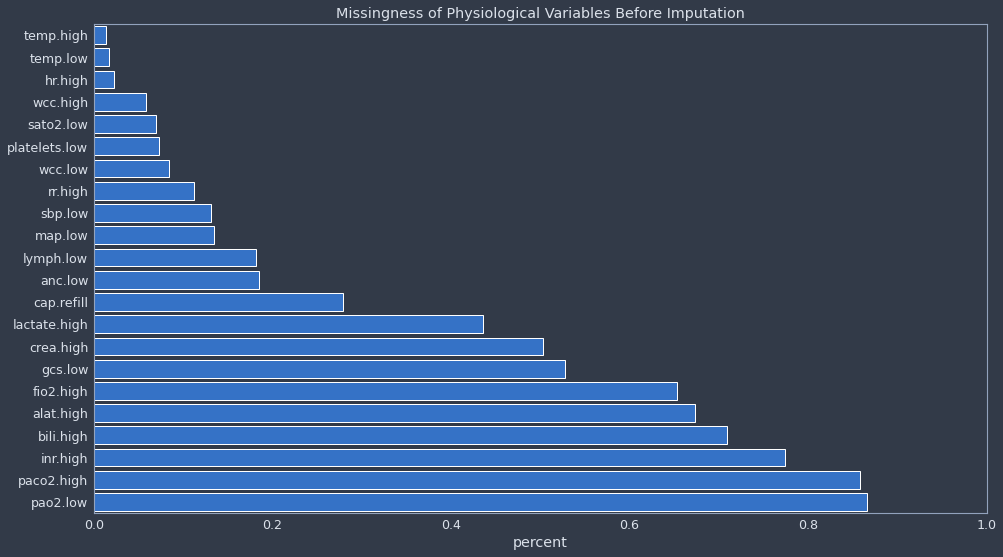

In [9]:
phymis_fg

##### Reference-Range Imputation

In [10]:
imp_df = sel_df.copy(deep=True)

# sex
M = imp_df.sex==1
F = imp_df.sex==0

# age ranges
DS_01   =  imp_df['age.at.bc']<=   1
DS_17   = (imp_df['age.at.bc'] >   1) & (imp_df['age.at.bc']<=   7)
DS_07   =  imp_df['age.at.bc']<=   7
DS_730  = (imp_df['age.at.bc'] >   7) & (imp_df['age.at.bc']<=  30)
MS_01   =  imp_df['age.at.bc']<=  30
MS_03   =  imp_df['age.at.bc']<=  91
MS_13   = (imp_df['age.at.bc'] >  30) & (imp_df['age.at.bc']<=  91)
MS_112  = (imp_df['age.at.bc'] >  30) & (imp_df['age.at.bc']<= 365)
MS_36   = (imp_df['age.at.bc'] >  91) & (imp_df['age.at.bc']<= 182)
MS_324  = (imp_df['age.at.bc'] >  91) & (imp_df['age.at.bc']<= 730)
MS_69   = (imp_df['age.at.bc'] > 182) & (imp_df['age.at.bc']<= 274)
MS_912  = (imp_df['age.at.bc'] > 274) & (imp_df['age.at.bc']<= 365)
MS_612  = (imp_df['age.at.bc'] > 182) & (imp_df['age.at.bc']<= 365)
MS_1218 = (imp_df['age.at.bc'] > 365) & (imp_df['age.at.bc']<= 547)
MS_1824 = (imp_df['age.at.bc'] > 547) & (imp_df['age.at.bc']<= 730)
YS_02   =  imp_df['age.at.bc']<= 730
YS_12   = (imp_df['age.at.bc'] > 365) & (imp_df['age.at.bc']<= 730)
YS_15   = (imp_df['age.at.bc'] > 365) & (imp_df['age.at.bc']<=1825)
YS_110  = (imp_df['age.at.bc'] > 365) & (imp_df['age.at.bc']<=3650)
YS_23   = (imp_df['age.at.bc'] > 730) & (imp_df['age.at.bc']<=1095)
YS_25   = (imp_df['age.at.bc'] > 730) & (imp_df['age.at.bc']<=1825)
YS_218  = (imp_df['age.at.bc'] > 730) & (imp_df['age.at.bc']<=6570)
YS_34   = (imp_df['age.at.bc'] >1095) & (imp_df['age.at.bc']<=1460)
YS_46   = (imp_df['age.at.bc'] >1460) & (imp_df['age.at.bc']<=2190)
YS_59   = (imp_df['age.at.bc'] >1825) & (imp_df['age.at.bc']<=3285)
YS_512  = (imp_df['age.at.bc'] >1825) & (imp_df['age.at.bc']<=4380)
YS_518  = (imp_df['age.at.bc'] >1825) & (imp_df['age.at.bc']<=6570)
YS_68   = (imp_df['age.at.bc'] >2190) & (imp_df['age.at.bc']<=2920)
YS_812  = (imp_df['age.at.bc'] >2920) & (imp_df['age.at.bc']<=4380)
YS_912  = (imp_df['age.at.bc'] >3285) & (imp_df['age.at.bc']<=4380)
YS_1018 = (imp_df['age.at.bc'] >3650) & (imp_df['age.at.bc']<=6570)
YS_1215 = (imp_df['age.at.bc'] >4380) & (imp_df['age.at.bc']<=5475)
YS_1216 = (imp_df['age.at.bc'] >4380) & (imp_df['age.at.bc']<=5840)
YS_1218 = (imp_df['age.at.bc'] >4380) & (imp_df['age.at.bc']<=6570)
YS_1518 = (imp_df['age.at.bc'] >5475) & (imp_df['age.at.bc']<=6570)
YS_1618 = (imp_df['age.at.bc'] >5840) & (imp_df['age.at.bc']<=6570)

imp_df.loc[M&MS_01,  'alat.high'] = imp_df.loc[M&MS_01,  'alat.high'].fillna(44.5)
imp_df.loc[M&MS_13,  'alat.high'] = imp_df.loc[M&MS_13,  'alat.high'].fillna(47.7)
imp_df.loc[M&MS_36,  'alat.high'] = imp_df.loc[M&MS_36,  'alat.high'].fillna(49.3)
imp_df.loc[M&MS_612, 'alat.high'] = imp_df.loc[M&MS_612, 'alat.high'].fillna(46.8)
imp_df.loc[M&MS_1218,'alat.high'] = imp_df.loc[M&MS_1218,'alat.high'].fillna(38.0)
imp_df.loc[M&MS_1824,'alat.high'] = imp_df.loc[M&MS_1824,'alat.high'].fillna(32.6)
imp_df.loc[M&YS_25,  'alat.high'] = imp_df.loc[M&YS_25,  'alat.high'].fillna(30.0)
imp_df.loc[M&YS_518, 'alat.high'] = imp_df.loc[M&YS_518, 'alat.high'].fillna(33.2)
imp_df.loc[F&MS_01,  'alat.high'] = imp_df.loc[F&MS_01,  'alat.high'].fillna(44.1)
imp_df.loc[F&MS_13,  'alat.high'] = imp_df.loc[F&MS_13,  'alat.high'].fillna(46.7)
imp_df.loc[F&MS_36,  'alat.high'] = imp_df.loc[F&MS_36,  'alat.high'].fillna(45.7)
imp_df.loc[F&MS_612, 'alat.high'] = imp_df.loc[F&MS_612, 'alat.high'].fillna(41.2)
imp_df.loc[F&MS_1218,'alat.high'] = imp_df.loc[F&MS_1218,'alat.high'].fillna(34.9)
imp_df.loc[F&MS_1824,'alat.high'] = imp_df.loc[F&MS_1824,'alat.high'].fillna(30.9)
imp_df.loc[F&YS_25,  'alat.high'] = imp_df.loc[F&YS_25,  'alat.high'].fillna(28.2)
imp_df.loc[F&YS_518, 'alat.high'] = imp_df.loc[F&YS_518, 'alat.high'].fillna(26.0)

imp_df.loc[MS_03,  'hr.high'] = imp_df.loc[MS_03,  'hr.high'].fillna(164)
imp_df.loc[MS_36,  'hr.high'] = imp_df.loc[MS_36,  'hr.high'].fillna(159)
imp_df.loc[MS_69,  'hr.high'] = imp_df.loc[MS_69,  'hr.high'].fillna(152)
imp_df.loc[MS_912, 'hr.high'] = imp_df.loc[MS_912, 'hr.high'].fillna(145)
imp_df.loc[MS_1218,'hr.high'] = imp_df.loc[MS_1218,'hr.high'].fillna(140)
imp_df.loc[MS_1824,'hr.high'] = imp_df.loc[MS_1824,'hr.high'].fillna(135)
imp_df.loc[YS_23,  'hr.high'] = imp_df.loc[YS_23,  'hr.high'].fillna(128)
imp_df.loc[YS_34,  'hr.high'] = imp_df.loc[YS_34,  'hr.high'].fillna(123)
imp_df.loc[YS_46,  'hr.high'] = imp_df.loc[YS_46,  'hr.high'].fillna(117)
imp_df.loc[YS_68,  'hr.high'] = imp_df.loc[YS_68,  'hr.high'].fillna(111)
imp_df.loc[YS_812, 'hr.high'] = imp_df.loc[YS_812, 'hr.high'].fillna(103)
imp_df.loc[YS_1215,'hr.high'] = imp_df.loc[YS_1215,'hr.high'].fillna( 96)
imp_df.loc[YS_1518,'hr.high'] = imp_df.loc[YS_1518,'hr.high'].fillna( 92)

imp_df['inr.high'] = imp_df['inr.high'].fillna(1.1)

imp_df['fio2.high'] = imp_df['fio2.high'].fillna(0.21)

imp_df.loc[MS_03, 'lactate.high'] = imp_df.loc[MS_03, 'lactate.high'].fillna(3.5)
imp_df.loc[MS_324,'lactate.high'] = imp_df.loc[MS_324,'lactate.high'].fillna(3.3)
imp_df.loc[YS_218,'lactate.high'] = imp_df.loc[YS_218,'lactate.high'].fillna(2.4)

imp_df['paco2.high'] = imp_df['paco2.high'].fillna(58.5)

imp_df.loc[MS_03,  'rr.high'] = imp_df.loc[MS_03,  'rr.high'].fillna(57)
imp_df.loc[MS_36,  'rr.high'] = imp_df.loc[MS_36,  'rr.high'].fillna(55)
imp_df.loc[MS_69,  'rr.high'] = imp_df.loc[MS_69,  'rr.high'].fillna(52)
imp_df.loc[MS_912, 'rr.high'] = imp_df.loc[MS_912, 'rr.high'].fillna(50)
imp_df.loc[MS_1218,'rr.high'] = imp_df.loc[MS_1218,'rr.high'].fillna(46)
imp_df.loc[MS_1824,'rr.high'] = imp_df.loc[MS_1824,'rr.high'].fillna(40)
imp_df.loc[YS_23,  'rr.high'] = imp_df.loc[YS_23,  'rr.high'].fillna(34)
imp_df.loc[YS_34,  'rr.high'] = imp_df.loc[YS_34,  'rr.high'].fillna(29)
imp_df.loc[YS_46,  'rr.high'] = imp_df.loc[YS_46,  'rr.high'].fillna(27)
imp_df.loc[YS_68,  'rr.high'] = imp_df.loc[YS_68,  'rr.high'].fillna(24)
imp_df.loc[YS_812, 'rr.high'] = imp_df.loc[YS_812, 'rr.high'].fillna(22)
imp_df.loc[YS_1215,'rr.high'] = imp_df.loc[YS_1215,'rr.high'].fillna(21)
imp_df.loc[YS_1518,'rr.high'] = imp_df.loc[YS_1518,'rr.high'].fillna(19)

imp_df.loc[MS_01,  'crea.high'] = imp_df.loc[MS_01,  'crea.high'].fillna(69)
imp_df.loc[MS_112, 'crea.high'] = imp_df.loc[MS_112, 'crea.high'].fillna(22)
imp_df.loc[YS_12,  'crea.high'] = imp_df.loc[YS_12,  'crea.high'].fillna(34)
imp_df.loc[YS_25,  'crea.high'] = imp_df.loc[YS_25,  'crea.high'].fillna(50)
imp_df.loc[YS_512, 'crea.high'] = imp_df.loc[YS_512, 'crea.high'].fillna(58)
imp_df.loc[YS_1218,'crea.high'] = imp_df.loc[YS_1218,'crea.high'].fillna(92)

imp_df['temp.high'] = imp_df['temp.high'].fillna(38.5)

imp_df.loc[M&YS_02,  'bili.high'] = imp_df.loc[M&YS_02,  'bili.high'].fillna(12)
imp_df.loc[M&YS_25,  'bili.high'] = imp_df.loc[M&YS_25,  'bili.high'].fillna(13)
imp_df.loc[M&YS_59,  'bili.high'] = imp_df.loc[M&YS_59,  'bili.high'].fillna(15)
imp_df.loc[M&YS_912, 'bili.high'] = imp_df.loc[M&YS_912, 'bili.high'].fillna(18)
imp_df.loc[M&YS_1216,'bili.high'] = imp_df.loc[M&YS_1216,'bili.high'].fillna(22)
imp_df.loc[M&YS_1618,'bili.high'] = imp_df.loc[M&YS_1618,'bili.high'].fillna(27)
imp_df.loc[F&YS_02,  'bili.high'] = imp_df.loc[F&YS_02,  'bili.high'].fillna(9)
imp_df.loc[F&YS_25,  'bili.high'] = imp_df.loc[F&YS_25,  'bili.high'].fillna(12)
imp_df.loc[F&YS_59,  'bili.high'] = imp_df.loc[F&YS_59,  'bili.high'].fillna(17)
imp_df.loc[F&YS_912, 'bili.high'] = imp_df.loc[F&YS_912, 'bili.high'].fillna(22)
imp_df.loc[F&YS_1216,'bili.high'] = imp_df.loc[F&YS_1216,'bili.high'].fillna(25)
imp_df.loc[F&YS_1618,'bili.high'] = imp_df.loc[F&YS_1618,'bili.high'].fillna(26)

imp_df.loc[DS_07,  'wcc.high'] = imp_df.loc[DS_07,  'wcc.high'].fillna(34.0)
imp_df.loc[DS_730, 'wcc.high'] = imp_df.loc[DS_730, 'wcc.high'].fillna(19.5)
imp_df.loc[MS_112, 'wcc.high'] = imp_df.loc[MS_112, 'wcc.high'].fillna(17.5)
imp_df.loc[YS_15,  'wcc.high'] = imp_df.loc[YS_15,  'wcc.high'].fillna(15.5)
imp_df.loc[YS_512, 'wcc.high'] = imp_df.loc[YS_512, 'wcc.high'].fillna(13.5)
imp_df.loc[YS_1218,'wcc.high'] = imp_df.loc[YS_1218,'wcc.high'].fillna(11.0)

imp_df['cap.refill'] = imp_df['cap.refill'].fillna(1)

imp_df.loc[DS_01,  'anc.low'] = imp_df.loc[DS_01,  'anc.low'].fillna(6.0)
imp_df.loc[DS_17,  'anc.low'] = imp_df.loc[DS_17,  'anc.low'].fillna(5.0)
imp_df.loc[DS_730, 'anc.low'] = imp_df.loc[DS_730, 'anc.low'].fillna(1.5)
imp_df.loc[MS_112, 'anc.low'] = imp_df.loc[MS_112, 'anc.low'].fillna(1.0)
imp_df.loc[YS_110, 'anc.low'] = imp_df.loc[YS_110, 'anc.low'].fillna(1.5)
imp_df.loc[YS_1018,'anc.low'] = imp_df.loc[YS_1018,'anc.low'].fillna(1.8)

imp_df['gcs.low'] = imp_df['gcs.low'].fillna(15)

imp_df['lymph.low'] = imp_df['lymph.low'].fillna(1)

imp_df.loc[MS_01,  'map.low'] = imp_df.loc[MS_01,  'map.low'].fillna(46)
imp_df.loc[MS_112, 'map.low'] = imp_df.loc[MS_112, 'map.low'].fillna(55)
imp_df.loc[YS_12,  'map.low'] = imp_df.loc[YS_12,  'map.low'].fillna(60)
imp_df.loc[YS_25,  'map.low'] = imp_df.loc[YS_25,  'map.low'].fillna(62)
imp_df.loc[YS_512, 'map.low'] = imp_df.loc[YS_512, 'map.low'].fillna(65)
imp_df.loc[YS_1218,'map.low'] = imp_df.loc[YS_1218,'map.low'].fillna(67)

imp_df['sato2.low'] = imp_df['sato2.low'].fillna(92)

imp_df['pao2.low'] = imp_df['pao2.low'].fillna(61)

imp_df['platelets.low'] = imp_df['platelets.low'].fillna(76.5)

imp_df.loc[DS_07,  'sbp.low'] = imp_df.loc[DS_07,  'sbp.low'].fillna(65)
imp_df.loc[DS_730, 'sbp.low'] = imp_df.loc[DS_730, 'sbp.low'].fillna(75)
imp_df.loc[MS_112, 'sbp.low'] = imp_df.loc[MS_112, 'sbp.low'].fillna(100)
imp_df.loc[YS_15,  'sbp.low'] = imp_df.loc[YS_15,  'sbp.low'].fillna(102)
imp_df.loc[YS_512, 'sbp.low'] = imp_df.loc[YS_512, 'sbp.low'].fillna(105)
imp_df.loc[YS_1218,'sbp.low'] = imp_df.loc[YS_1218,'sbp.low'].fillna(117)

imp_df['temp.low'] = imp_df['temp.low'].fillna(36.0)

imp_df.loc[MS_01,  'wcc.low'] = imp_df.loc[MS_01,  'wcc.low'].fillna(5.0)
imp_df.loc[MS_112, 'wcc.low'] = imp_df.loc[MS_112, 'wcc.low'].fillna(5.0)
imp_df.loc[YS_15,  'wcc.low'] = imp_df.loc[YS_15,  'wcc.low'].fillna(6.0)
imp_df.loc[YS_512, 'wcc.low'] = imp_df.loc[YS_512, 'wcc.low'].fillna(4.5)
imp_df.loc[YS_1218,'wcc.low'] = imp_df.loc[YS_1218,'wcc.low'].fillna(4.5)

#### Proteome

##### Missingness

###### Compute

In [11]:
promis_df = sel_df[sel_dc['proteome']].isnull().sum()\
                                      .sort_values(ascending=False)
promis_df = promis_df/sel_df.shape[0]
promis_df = promis_df[promis_df!=0]

promis_fg = plt.figure(figsize=(16,9))
ax1       = promis_fg.add_subplot(111)
ax1.barh(y=range(promis_df.shape[0]),\
         width=promis_df.values,\
         ec='white',\
         linewidth=1,\
         tick_label=promis_df.index.tolist())
ax1.set_xlim([0,1])
ax1.set_ylim([-.5,promis_df.shape[0]-.5])
ax1.set_title('Missingness of Proteins Before Imputation')
ax1.set_xlabel('percent')
ax1.grid(False)
plt.close()

###### Figure

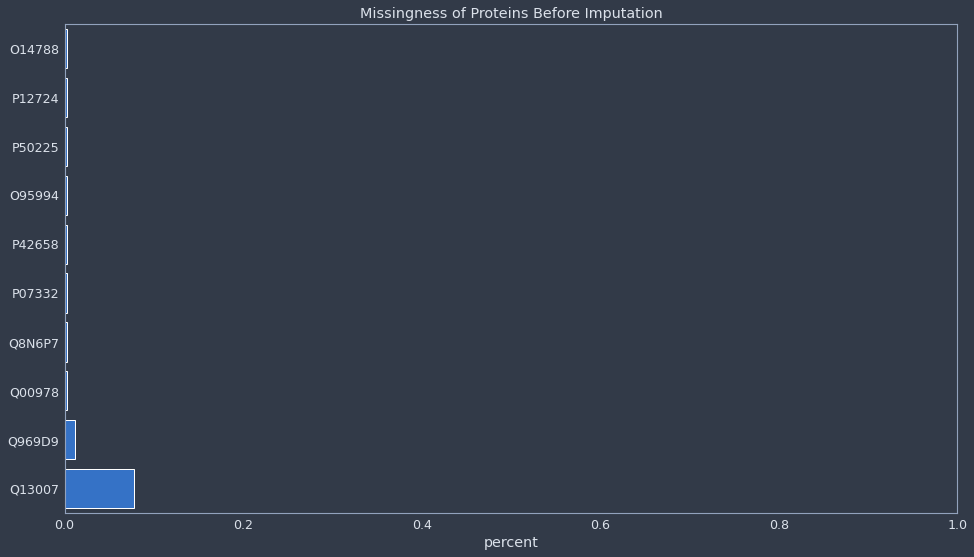

In [12]:
promis_fg

#####  Multiple Imputation by Chained Equations (MICE)

In [13]:
mice = ski.IterativeImputer(max_iter=100,\
                            initial_strategy='median',\
                            skip_complete=True,\
                            min_value=0,\
                            max_value=imp_df[sel_dc['proteome']].max().max())

imp_df[sel_dc['proteome']] =  mice.fit_transform(imp_df[sel_dc['proteome']])
imp_df[sel_dc['proteome']]

,Q96SB3,P16278,O75475,Q05516,Q9NWZ3,Q15661,P14317,Q9UHC6,Q6UXB4,Q00978,...,Q12913,Q7LG56,Q13308,P20472,Q9UHF1,Q0Z7S8,P98073,P01229,P53539,P27797
BE-001,2.189480,2.591750,4.848860,1.737870,1.645060,5.323420,4.700430,2.398600,4.477340,2.565510,...,1.70159,3.48718,2.05995,3.76090,6.96531,4.18190,0.22963,2.45691,0.87458,1.74746
BE-003,4.374040,2.980250,5.676970,4.644750,5.197660,4.755190,6.598710,2.275020,4.211850,4.689300,...,3.59710,3.06095,2.04341,6.06249,6.69491,2.23101,1.37726,2.01789,1.63672,2.00566
BE-004,3.064210,1.851580,2.073060,2.873600,1.803510,6.737260,4.180860,1.999300,2.599490,2.100520,...,1.73363,1.68708,2.19836,6.25993,5.32153,1.12803,1.08999,0.87993,0.04963,1.42964
BE-005,6.908315,0.920112,6.015381,4.953772,7.222683,6.940401,10.382117,4.347090,5.872441,4.092666,...,4.37900,3.18976,3.96052,7.78852,6.43559,2.50802,1.03539,0.41681,1.60899,2.15542
BE-007,3.088700,4.241990,4.357900,2.859930,2.193450,6.208380,5.462200,4.286340,4.010610,2.461800,...,3.08916,1.98271,4.14826,7.28065,7.33051,2.05212,1.72586,1.42252,0.78154,1.53606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZH-254,4.805850,5.013930,6.319910,5.300950,4.610000,6.068970,6.847390,3.783100,3.760460,5.079230,...,5.06552,2.87701,3.85969,10.63042,7.58074,1.53331,1.24035,1.68320,4.14710,2.54191
ZH-255,5.385860,4.295540,6.509910,5.139260,4.801040,6.559500,7.278640,5.505870,4.491950,5.028190,...,6.42122,2.89101,5.20275,10.70967,6.99078,3.31375,0.66809,1.16686,3.34361,3.40926
ZH-257,5.002694,2.358387,6.289317,6.673875,3.401441,7.141498,7.858672,7.740111,5.498104,5.801897,...,3.72867,2.44134,3.89944,9.87816,6.65984,2.61212,3.34854,0.92167,2.80111,1.77911
ZH-258,3.841330,3.329035,4.487176,1.960050,2.027405,7.127125,7.896770,8.531797,5.550231,2.815816,...,2.96162,2.31719,6.42890,6.05447,7.64716,1.46705,3.20317,1.93248,1.74769,1.80203


##### Binary Variables

In [14]:
imp_df.columns[imp_df.isna().any()]

Index(['ccc.neuro', 'ccc.cardio', 'ccc.pulmo', 'ccc.uro', 'ccc.gastro',
       'ccc.haemimmuno', 'ccc.metabol', 'ccc.malform', 'ccc.onco', 'ccc.neo',
       'ccc.surg', 'ccc.techdep', 'ccc.transplant', 'abx.change.pen',
       'abx.change.oxa', 'abx.change.pip', 'abx.change.cla', 'abx.change.cxm',
       'abx.change.cro', 'abx.change.fep', 'abx.change.mem', 'abx.change.amk',
       'abx.change.van', 'abx.change.cip', 'abx.change.lzd', 'abx.change.cli',
       'abx.change.mtz', 'abx.change.sxt', 'niv', 'iv', 'hfnc', 'ecls',
       'inotrope', 'crrt'],
      dtype='object')

In [15]:
imp_df = imp_df.fillna(0)

### PCA of Binary Variables

#### Contextual Variables

In [16]:
pca1_cs = [c for c in sel_dc['chronic_conditions'] if 'summary' not in c]+\
          ['niv','iv','hfnc','ecls','inotrope','crrt']#+\
          #[c for c in sel_dc['organs'] if (('cons' in c) and ('score' not in c))]
pca1_df, comp1_df = pca_var(imp_df[pca1_cs],.95,'con')
pca_df  = pd.concat([imp_df,pca1_df],join='inner',axis=1)
pca1_df.head(3)

,conpc_1,conpc_2,conpc_3,conpc_4,conpc_5,conpc_6,conpc_7,conpc_8,conpc_9,conpc_10,conpc_11,conpc_12,conpc_13,conpc_14,conpc_15,conpc_16,conpc_17,conpc_18
BE-001,0.479667,-1.480377,-0.420624,0.914133,-0.606673,0.169614,-1.144344,0.049419,0.024476,0.532612,-0.596178,1.598574,0.152182,0.849519,0.395844,-0.006381,-1.581362,-0.042311
BE-003,-0.631280,-1.123158,-0.344817,-0.990700,-0.661372,2.224353,-0.124138,2.707536,5.945061,-0.893266,-2.454564,-1.037178,0.394868,-1.093219,-0.352206,0.739114,-0.565922,-0.433740
BE-004,-0.628310,-2.155517,-0.139728,-0.590933,-1.064311,0.449938,1.116880,-0.828161,-0.109164,0.385790,0.489541,-0.086786,0.028278,-0.305824,-0.103807,0.267661,0.070457,0.025962


In [17]:
n = int(comp1_df.shape[1]/2)
p = 3
comp1_df[[p,n+p]].sort_values(p,ascending=False)[:5]

,3,24
crrt,18,1
ecls,15,1
ccc.uro,11,1
ccc.neo,9,-1
inotrope,7,1


#### Infection Variables

In [18]:
pca2_cs = sel_dc['infections']+sel_dc['pathogen']+sel_dc['treatment']
nos     = ['niv','iv','hfnc','ecls','inotrope','crrt']
pca2_cs = [c for c in pca2_cs if not any([n in c for n in nos])]
pca2_df,comp2_df = pca_var(imp_df[pca2_cs],.95,'inf')
pca_df  = pd.concat([imp_df,pca1_df,pca2_df],join='inner',axis=1)
pca2_df.head(3)

,infpc_1,infpc_2,infpc_3,infpc_4,infpc_5,infpc_6,infpc_7,infpc_8,infpc_9,infpc_10,...,infpc_29,infpc_30,infpc_31,infpc_32,infpc_33,infpc_34,infpc_35,infpc_36,infpc_37,infpc_38
BE-001,1.009419,2.848292,1.021984,4.063584,0.808175,-0.736218,-1.073750,1.350422,3.878784,0.984097,...,1.830412,-0.892903,1.352640,1.700740,1.853661,1.101710,0.651480,-0.685748,-0.871349,1.159804
BE-003,2.713639,0.163775,-0.426252,-0.715875,-0.168397,-0.366040,0.723560,-0.750905,-0.570678,-0.249249,...,-1.513240,0.117070,0.733611,-0.389852,-0.429890,-0.239180,-0.163524,-0.908632,0.707770,0.740119
BE-004,-1.286218,-0.011228,1.583046,-0.609656,-0.795670,1.595586,-0.542754,-1.162981,0.284738,-0.342239,...,-0.104897,-0.833408,-1.209053,0.010907,0.335364,0.685778,0.589704,-0.080226,-0.614462,0.768288


In [19]:
n = int(comp2_df.shape[1]/2)
p = 3
comp2_df[[p,n+p]].sort_values(p,ascending=False)[:5]

,3,51
focus_uti,7,1
patho_ecoli,7,1
focus_primbsi,6,-1
patho_sagalactiae,6,-1
cahai_eos,5,-1


### Standardization

#### Original Distributions

##### Physiology

###### Compute

In [20]:
physio_cs  = [c for c in sel_dc['physio'] if 'fio2.high' not in c]#+\
             #[c for c in sel_dc['organs'] if 'cons' not in c]
physio_cs  = [c for c in physio_cs if c not in pca1_cs]

physdist_fg = plt.figure(figsize=(35,30))

for i,c in enumerate(physio_cs):

    ax = physdist_fg.add_subplot(6,4,i+1)
    ax.hist(sel_df[c],color='w',density=True,label='original',bins=15)
    ax.hist(pca_df[c],alpha=.75,density=True,label='imputed',bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)
    plt.legend()

plt.close()

###### Figure

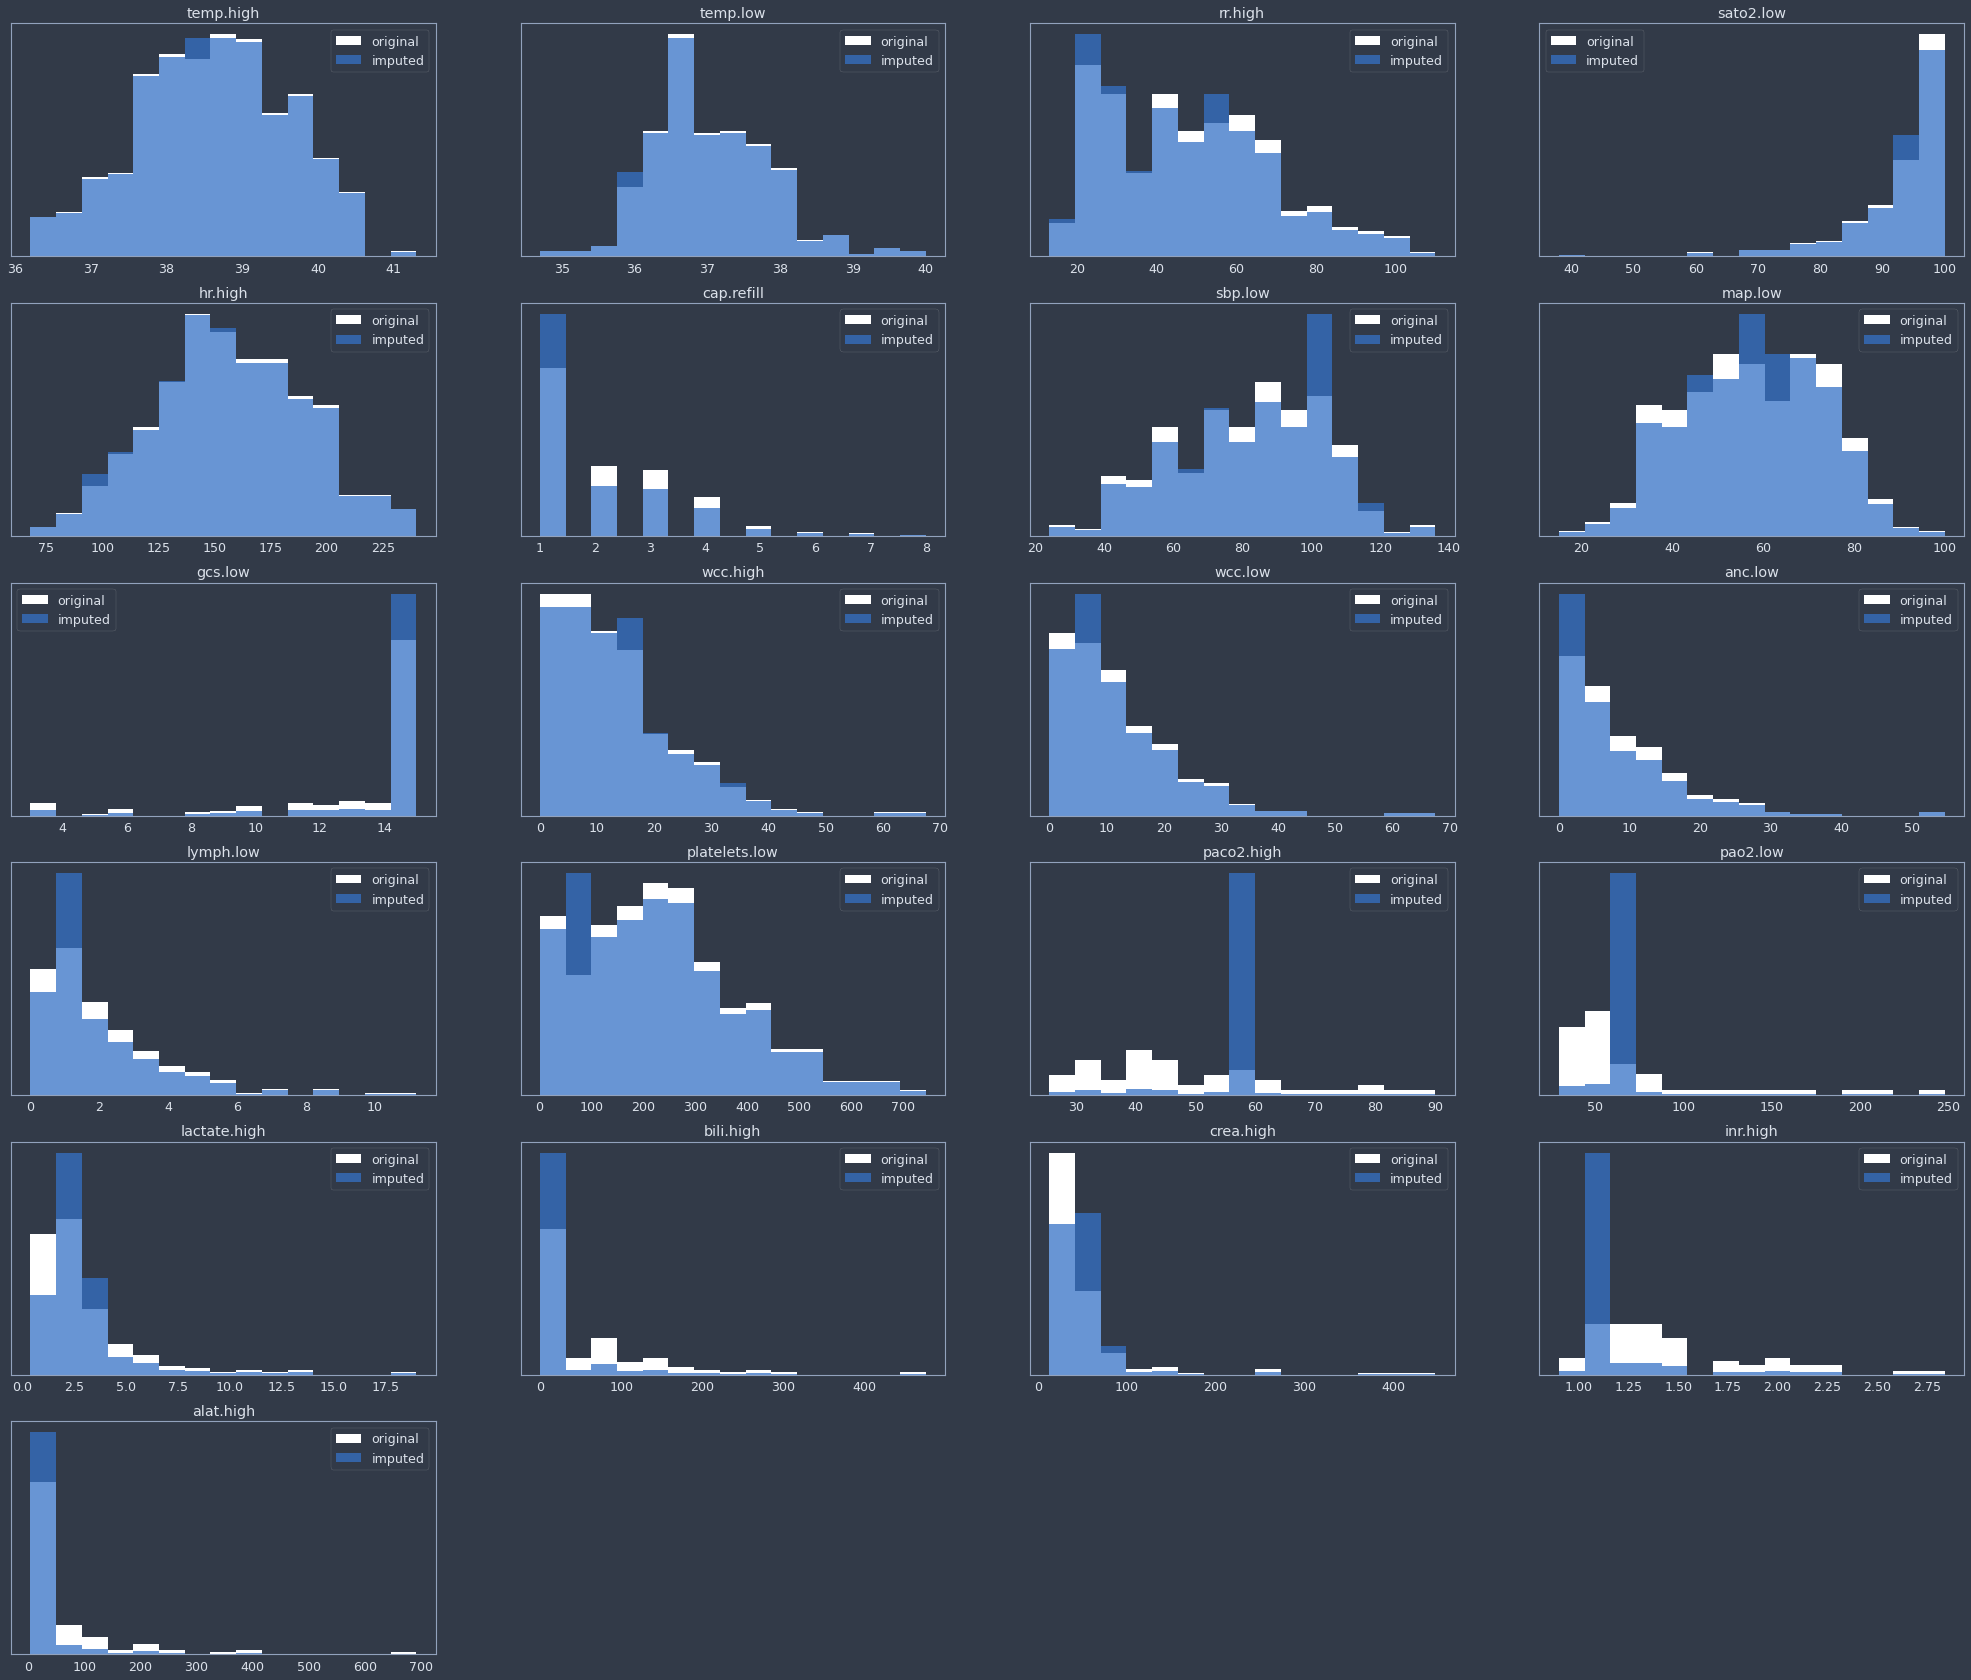

In [21]:
physdist_fg

##### Confounders

###### Compute

In [22]:
dempc_cs = ['age.at.bc','grm_pc1','grm_pc2','grm_pc3','grm_pc4','grm_pc5',\
            'grm_pc6','grm_pc7','grm_pc8','grm_pc9','grm_pc10']
dempc_fg = plt.figure(figsize=(35,15))

for i,c in enumerate(dempc_cs):

    ax = dempc_fg.add_subplot(3,4,i+1)
    ax.hist(pca_df[c],density=True,bins=25)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

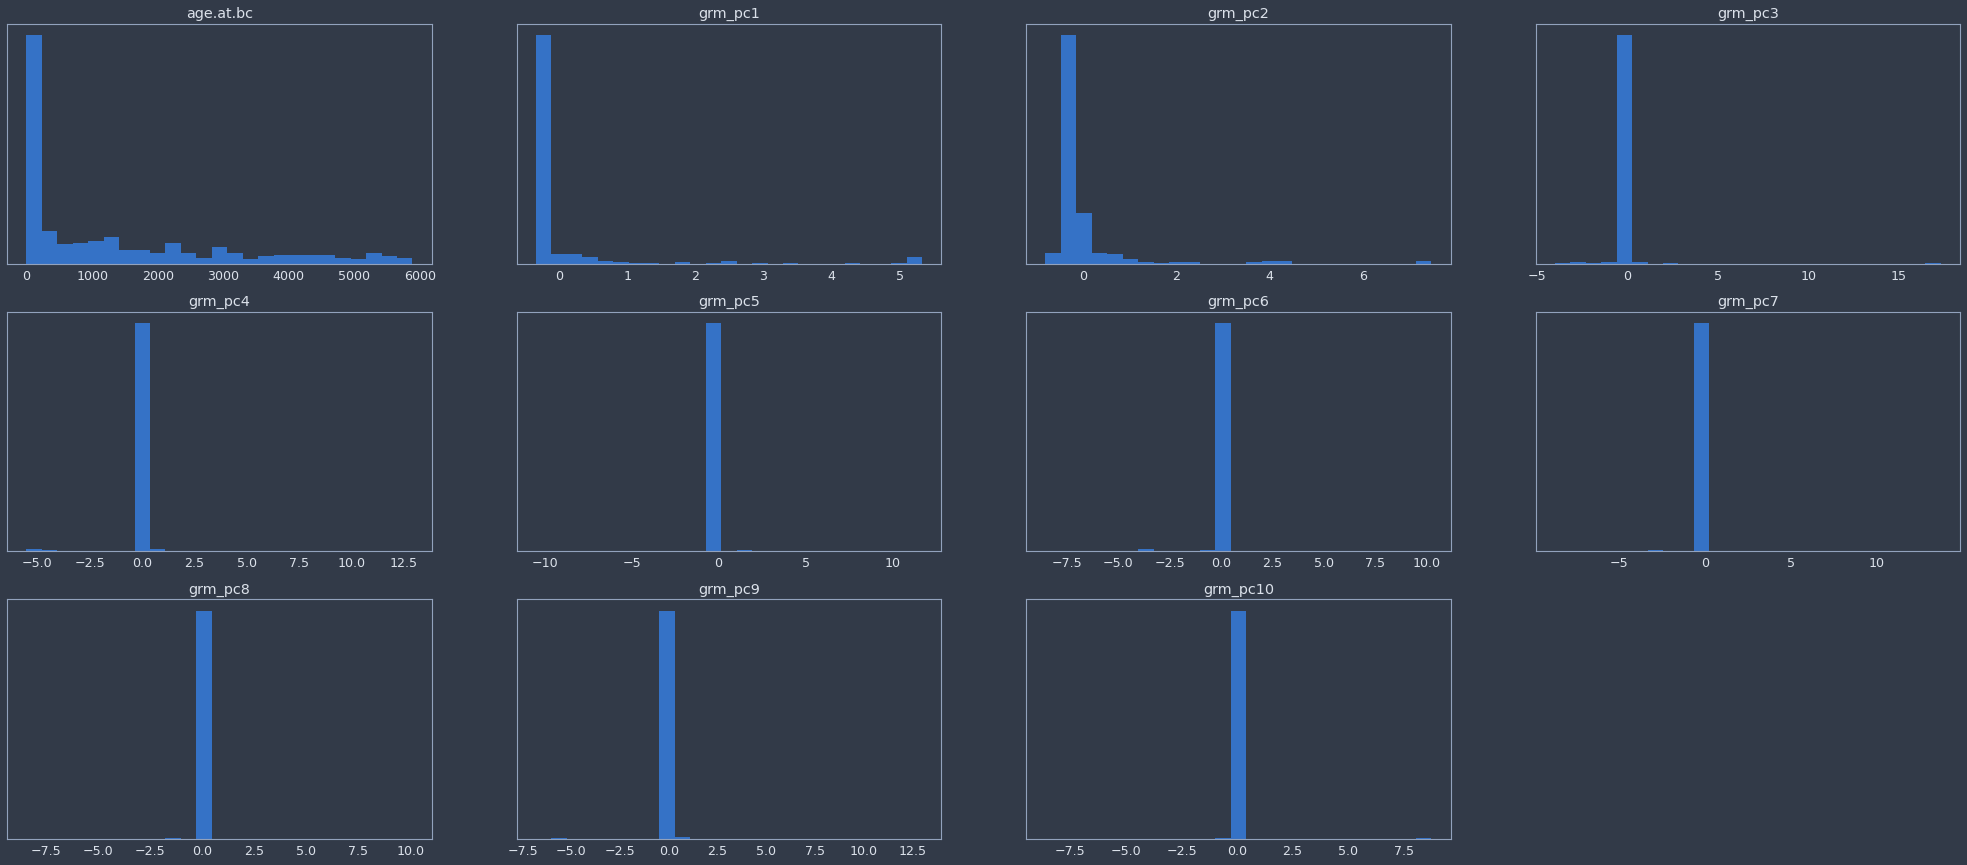

In [23]:
dempc_fg

##### Context

###### Compute

In [24]:
conpc_cs = [c for c in pca_df.columns if 'conpc' in c] +\
           ['ccc.summary','fio2.high']
conpc_fg = plt.figure(figsize=(35,25))

for i,c in enumerate(conpc_cs):

    ax = conpc_fg.add_subplot(5,4,i+1)
    ax.hist(pca_df[c],density=True,bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

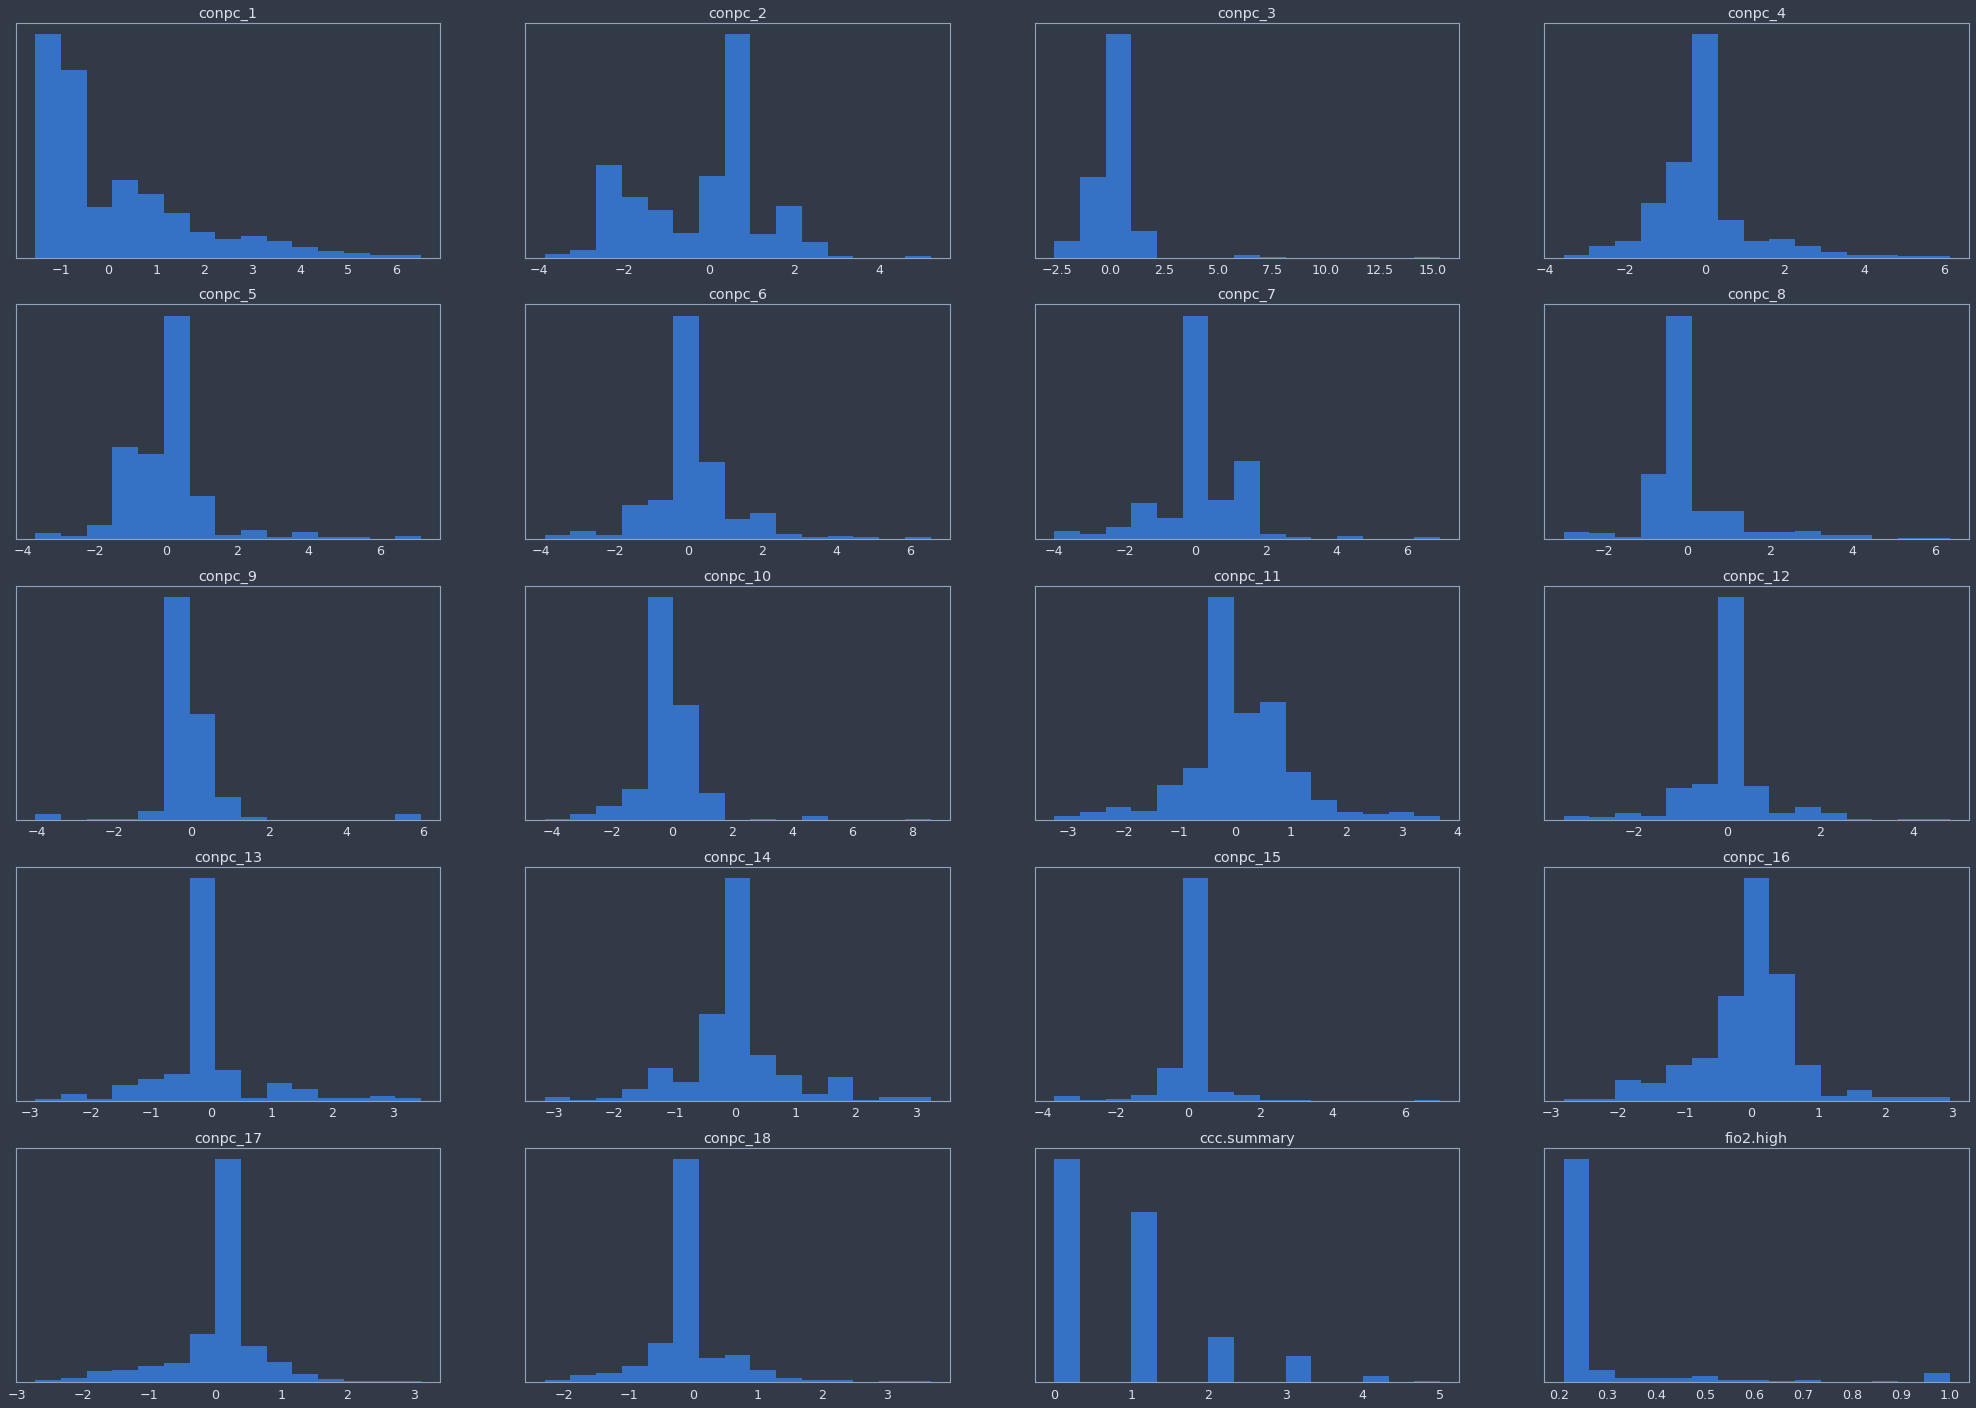

In [25]:
conpc_fg

##### Infection

###### Compute

In [26]:
infpc_cs = [c for c in pca_df.columns if 'infpc' in c]
infpc_fg = plt.figure(figsize=(35,50))

for i,c in enumerate(infpc_cs):

    ax = infpc_fg.add_subplot(10,4,i+1)
    ax.hist(pca_df[c],density=True,bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

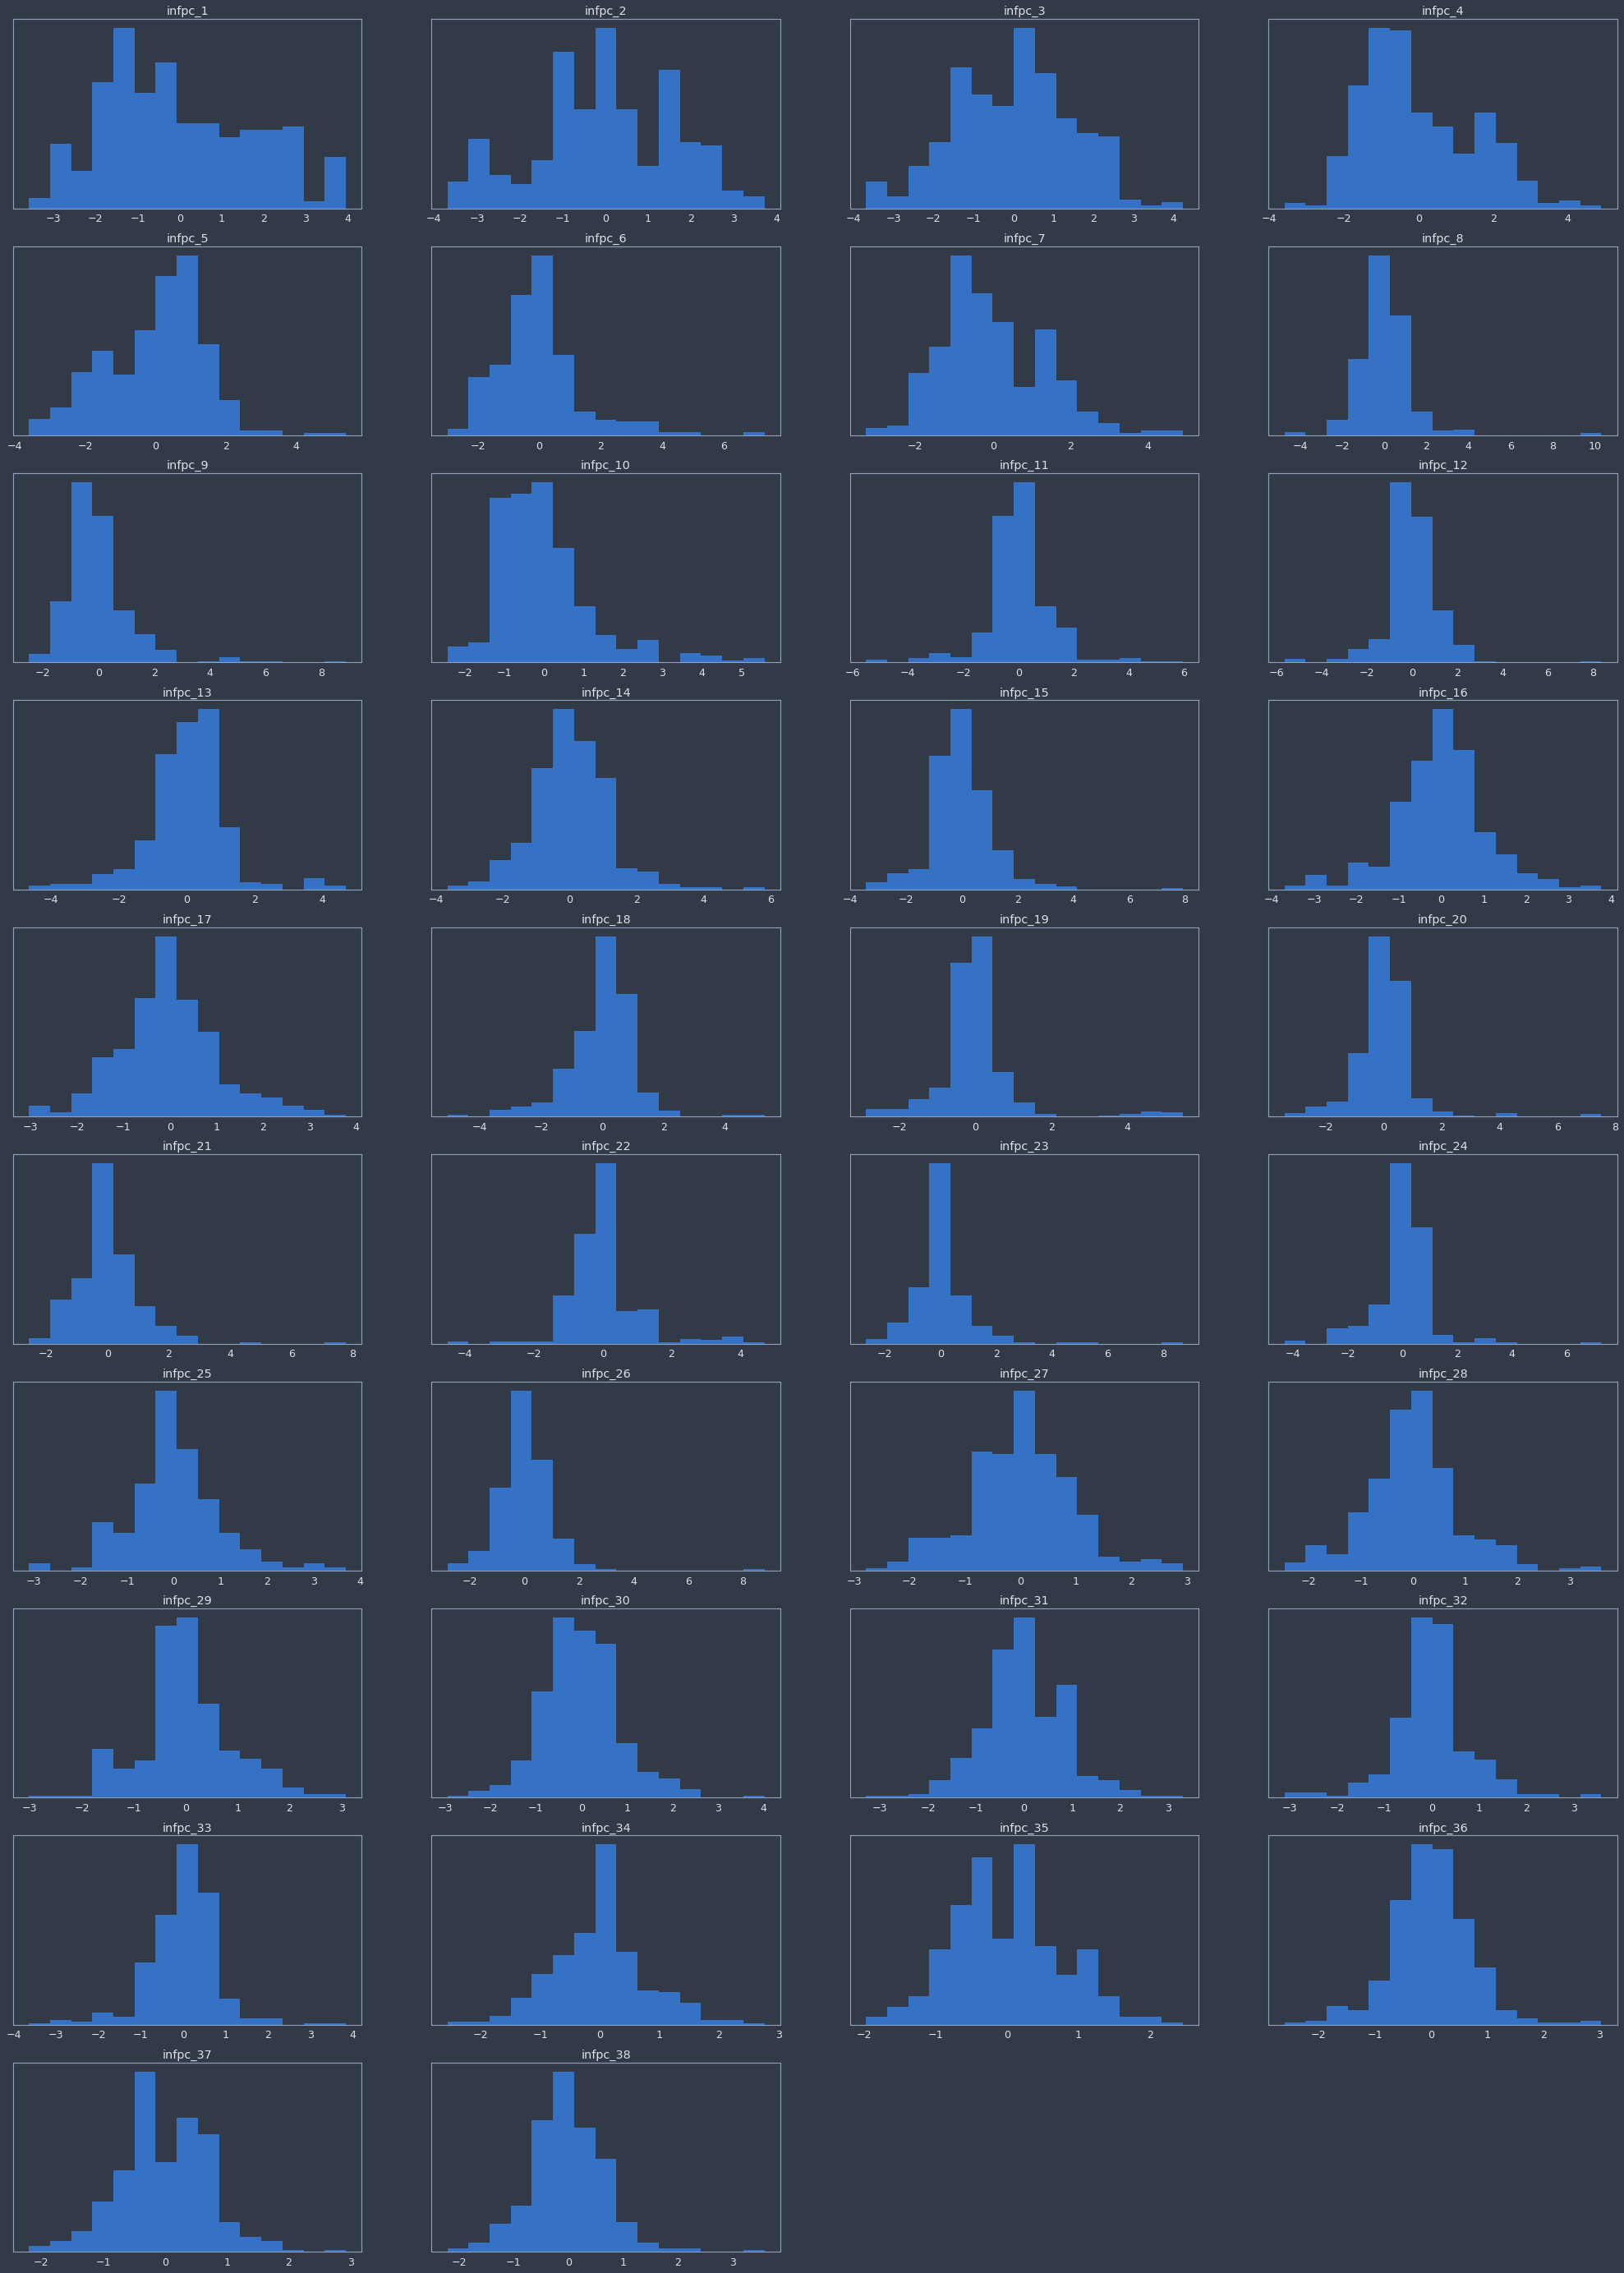

In [27]:
infpc_fg

##### Proteome

###### Compute

In [28]:
protein_cs = cp.deepcopy(sel_dc['proteome'])
protein_fg = plt.figure(figsize=(35,35))

for i,c in enumerate(protein_cs):

    ax = protein_fg.add_subplot(20,18,i+1)
    ax.hist(sel_df[c],color='w',density=True,label='original',bins=15)
    ax.hist(pca_df[c],alpha=.75,density=True,label='imputed',bins=15)
    ax.set_title(c,fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

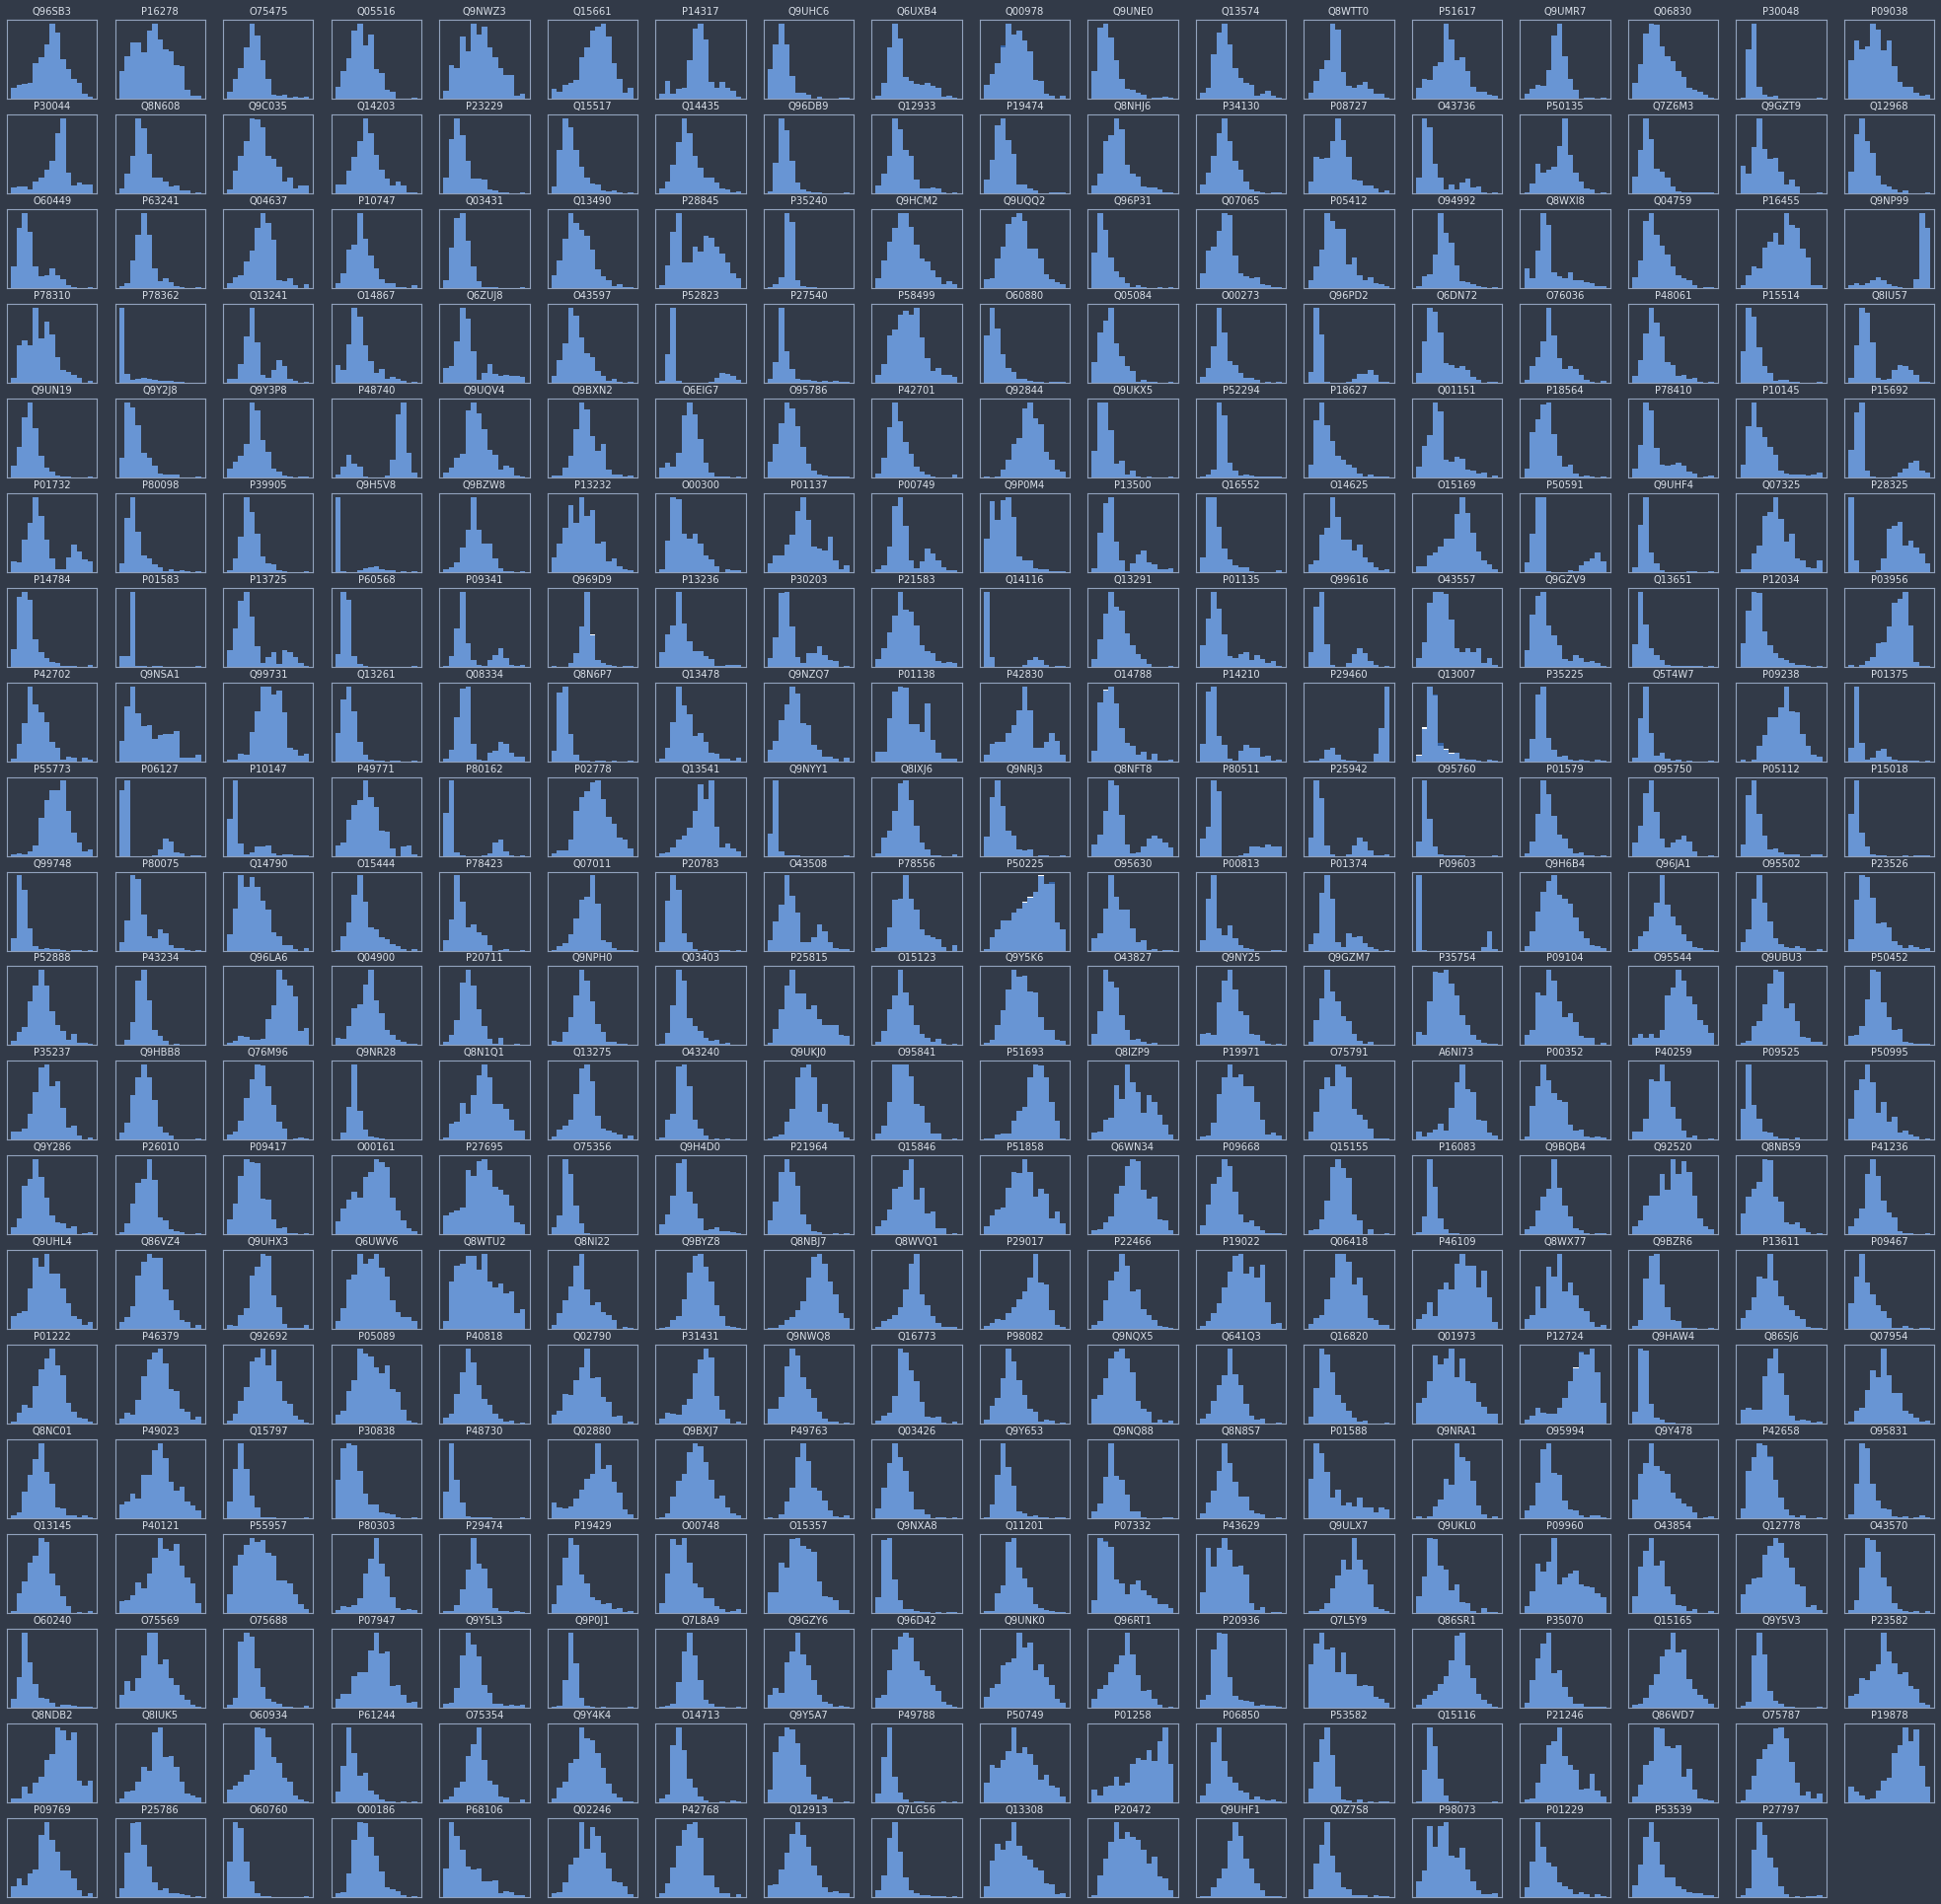

In [29]:
protein_fg

#### Log Scaling

In [30]:
log_df = pca_df.copy(deep=True)

inv_cs = ['sato2.low','gcs.low']

for c in inv_cs:
    log_df[c] = log_df[c].max()-log_df[c]

log_cs = ['conpc_1','sato2.low','cap.refill','gcs.low','fio2.high',\
          'wcc.high','wcc.low','anc.low','lymph.low','lactate.high',\
          'bili.high','crea.high','inr.high','alat.high','age.at.bc']\
      +[c for c in sel_dc['organs'] if ('cons' not in c) or ('summary' in c)]

for c in log_cs:
    log_df[c] = np.log(log_df[c]-log_df[c].min()+1)

#### Standard Scaling

In [31]:
sc = skp.StandardScaler()
std_df = pd.DataFrame(sc.fit_transform(log_df),\
                      columns=log_df.columns,\
                      index=log_df.index)
std_df

,temp.high,temp.low,rr.high,sato2.low,hr.high,cap.refill,sbp.low,map.low,gcs.low,fio2.high,...,infpc_29,infpc_30,infpc_31,infpc_32,infpc_33,infpc_34,infpc_35,infpc_36,infpc_37,infpc_38
BE-001,-0.224542,-0.658596,-0.100526,-0.541825,-0.499341,1.219564,-0.574013,-0.849425,1.328859,-0.376056,...,2.108679,-1.058852,1.635568,2.112704,2.329675,1.438204,0.864837,-0.950703,-1.228130,1.697854
BE-003,0.389874,-0.034516,-0.535871,-0.038989,-1.091177,-0.733584,0.218151,1.232032,1.328859,-0.376056,...,-1.743289,0.138828,0.887059,-0.484284,-0.540284,-0.312232,-0.217078,-1.259702,0.997573,1.083472
BE-004,1.209096,3.460330,-0.342384,0.152181,-0.025872,-0.733584,0.451140,2.373476,-0.399372,-0.376056,...,-0.120844,-0.988300,-1.461947,0.013549,0.421484,0.895235,0.782830,-0.111223,-0.866059,1.124708
BE-005,1.618707,0.464748,-0.342384,-0.541825,-0.795259,-0.733584,1.383097,0.627738,-0.399372,-0.376056,...,0.883049,0.190510,-0.413616,-0.023979,-1.373158,-0.972302,-0.583113,-0.558664,-1.053305,1.357079
BE-007,-0.122140,1.213643,0.576676,-0.541825,-0.025872,-0.733584,0.777325,-0.177987,-0.399372,-0.376056,...,1.178486,-0.721739,1.952401,-1.619016,-0.044211,-0.773947,-0.506249,1.096667,-0.741134,-0.203807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZH-254,-0.019737,1.088827,1.592479,1.730847,0.980249,1.731014,-1.133187,-1.050856,-0.399372,-0.376056,...,-1.309644,0.726385,1.712175,-0.211516,-0.597779,-0.563623,0.448595,1.480455,-1.292201,0.448925
ZH-255,-1.043764,-0.034516,2.076195,1.390504,0.329230,1.219564,-1.692361,-1.319431,2.419251,4.173726,...,0.021498,-0.113992,0.232706,-0.038411,1.019305,-0.054763,0.361633,-0.299829,0.027476,-0.450181
ZH-257,0.389874,1.088827,0.044588,-0.265094,1.039433,1.219564,2.454847,1.970613,-0.399372,-0.376056,...,-1.767220,-2.048768,0.005722,4.039763,-0.366891,0.537466,-1.590084,-0.077894,-1.178410,-1.826035
ZH-258,-0.224542,-0.408964,0.092960,-0.898594,-0.144239,-0.733584,-0.294425,-0.513706,-0.399372,-0.376056,...,-0.537291,0.084246,0.451164,0.082527,-0.907483,2.257566,1.327142,0.988807,0.111956,0.583259


#### Standardized Distributions

##### Confounders

###### Compute

In [32]:
demdist_fg2 = plt.figure(figsize=(35,15))

for i,c in enumerate(dempc_cs):

    ax = demdist_fg2.add_subplot(3,4,i+1)
    ax.hist(std_df[c],density=True,bins=25)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

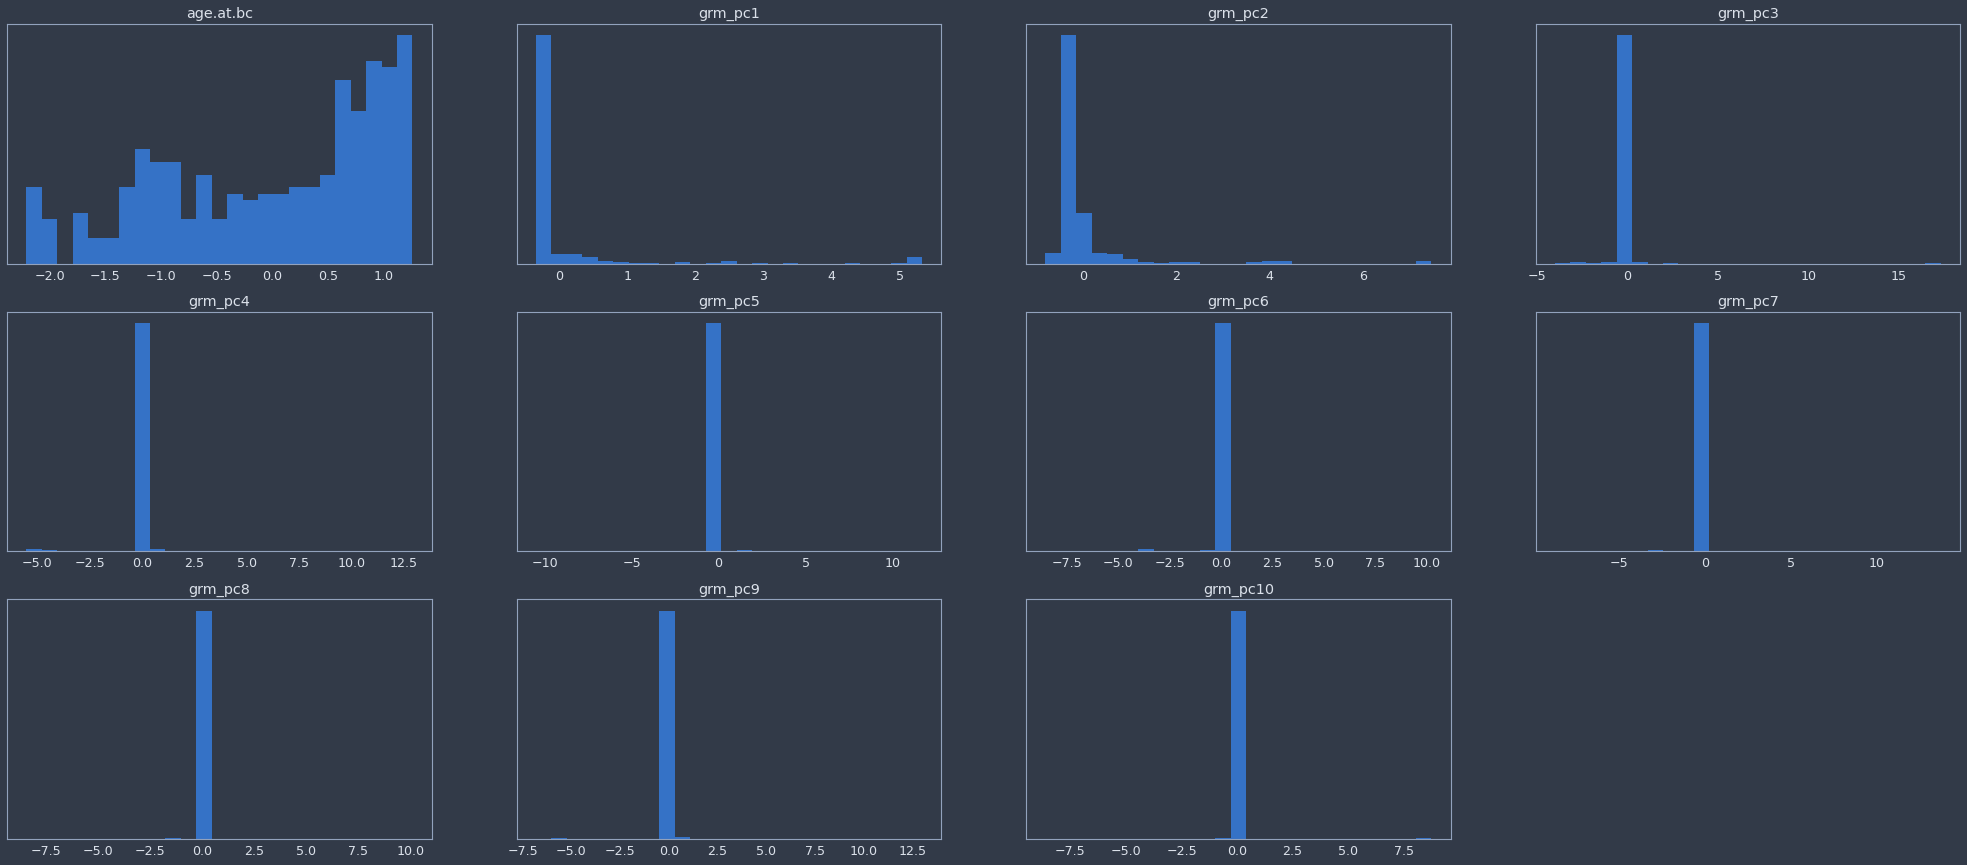

In [33]:
demdist_fg2

##### Physiology

###### Compute

In [34]:
physdist_fg2 = plt.figure(figsize=(35,50))

for i,c in enumerate(physio_cs):

    ax = physdist_fg2.add_subplot(10,4,i+1)
    ax.hist(std_df[c],density=True,bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

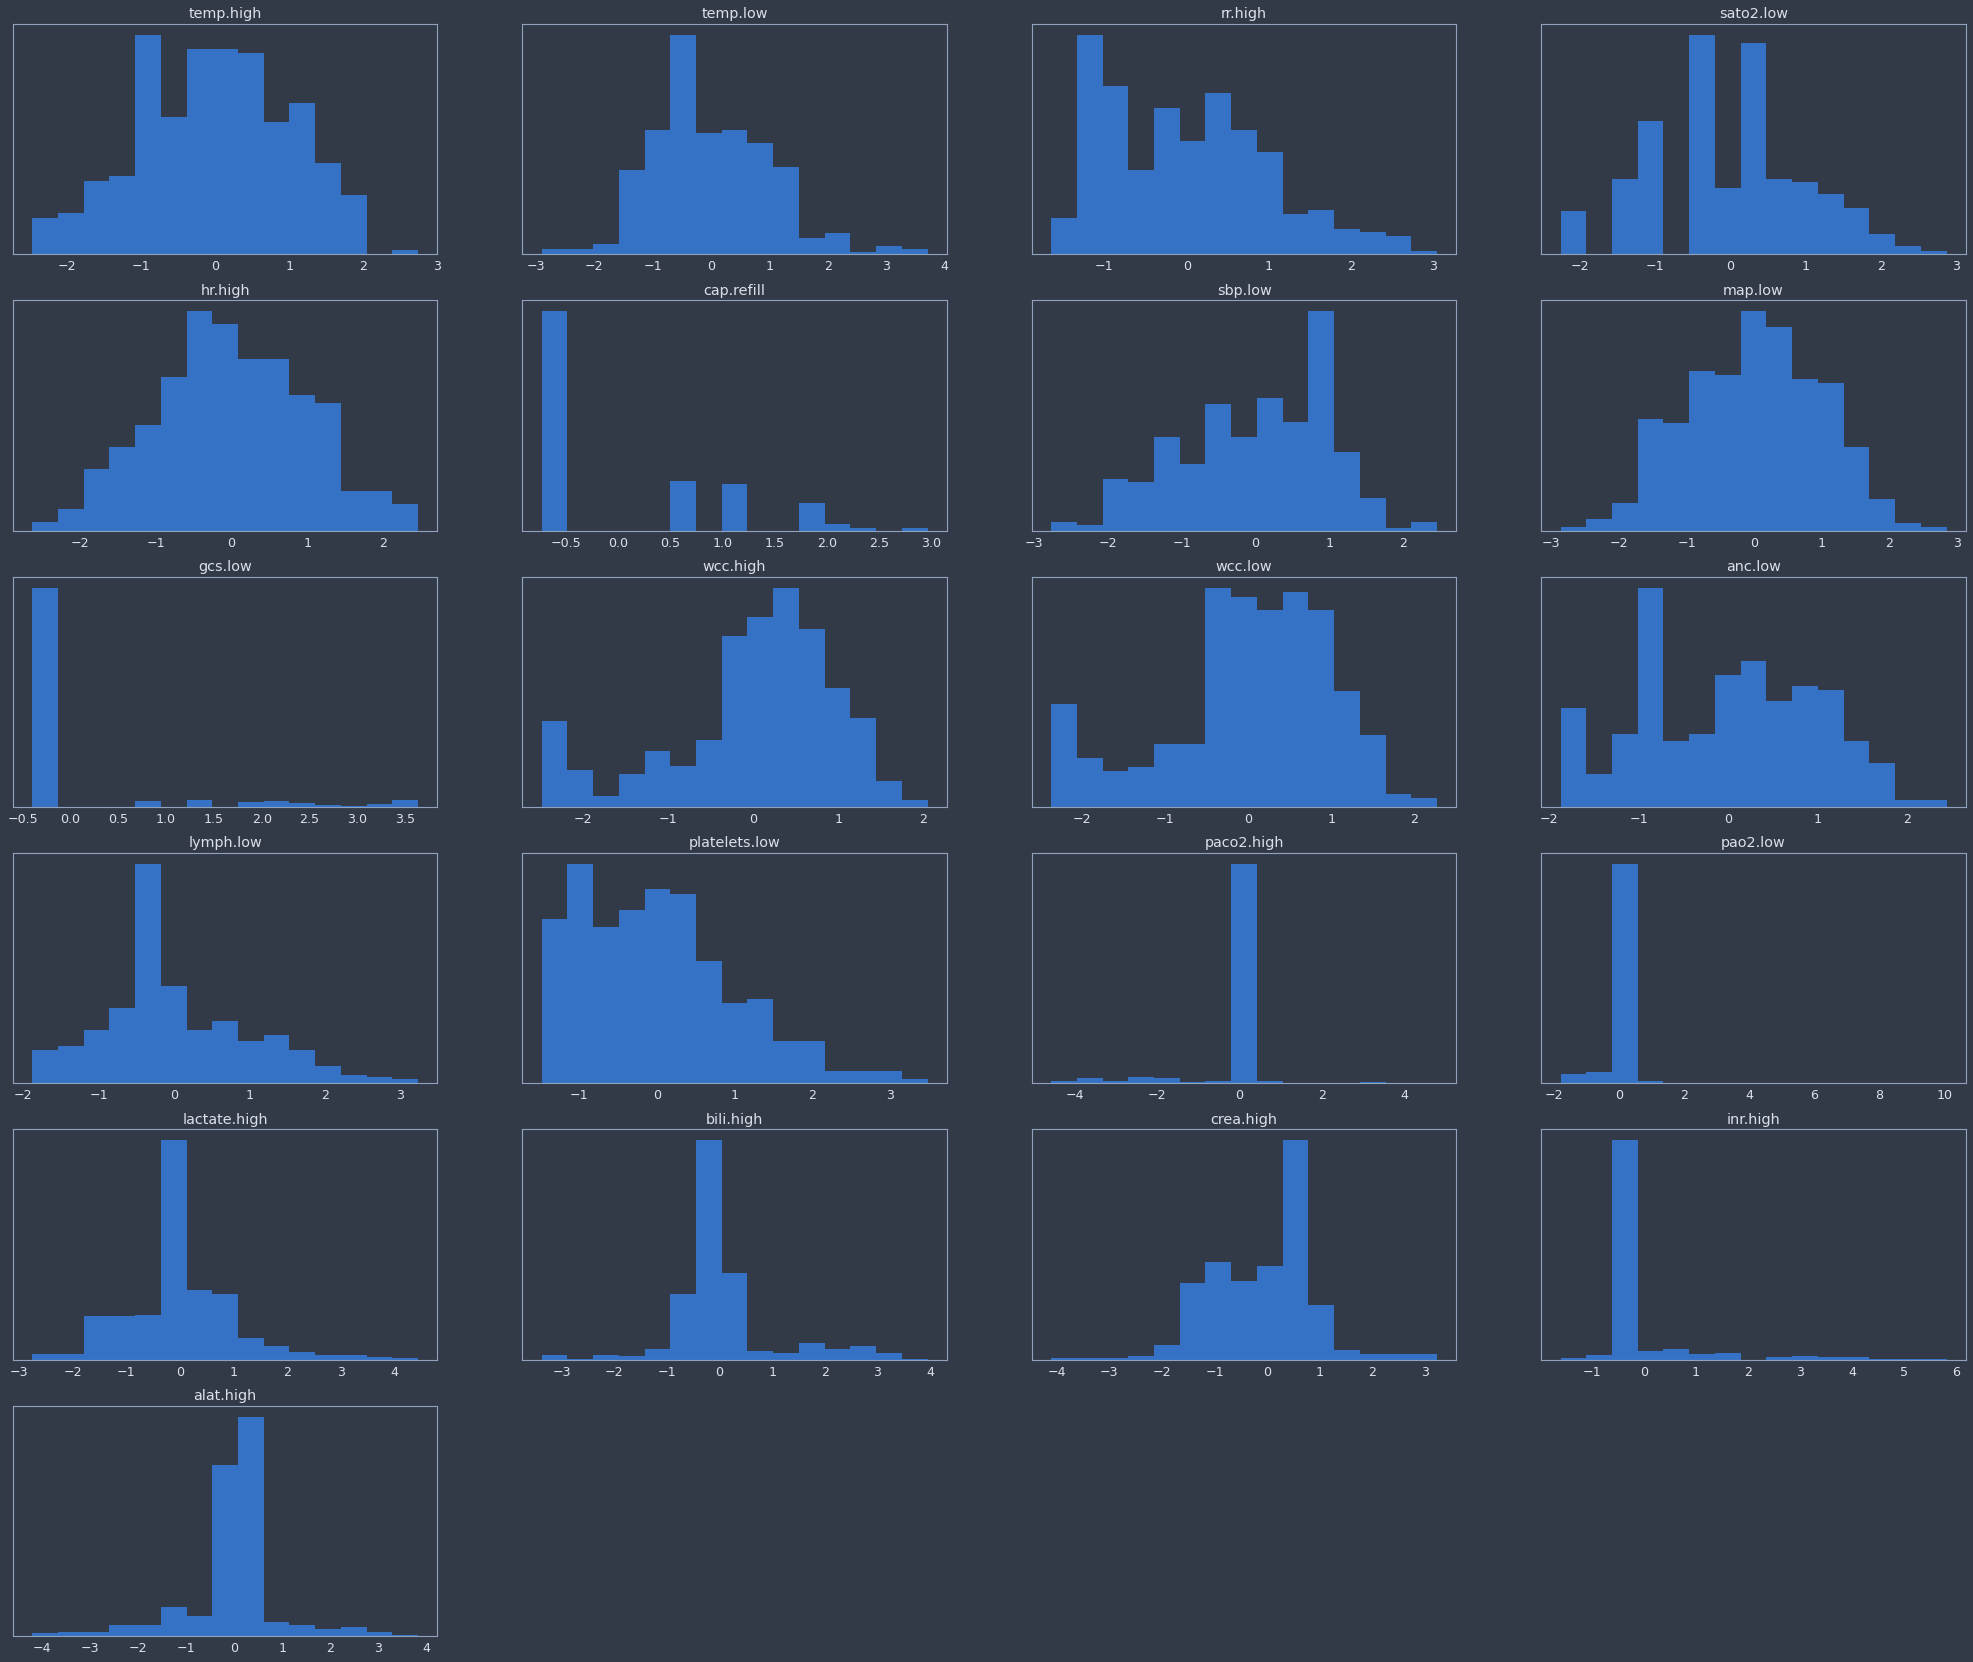

In [35]:
physdist_fg2

##### Context

###### Compute

In [36]:
conpc_fg2 = plt.figure(figsize=(35,25))

for i,c in enumerate(conpc_cs):

    ax = conpc_fg2.add_subplot(5,4,i+1)
    ax.hist(std_df[c],density=True,bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

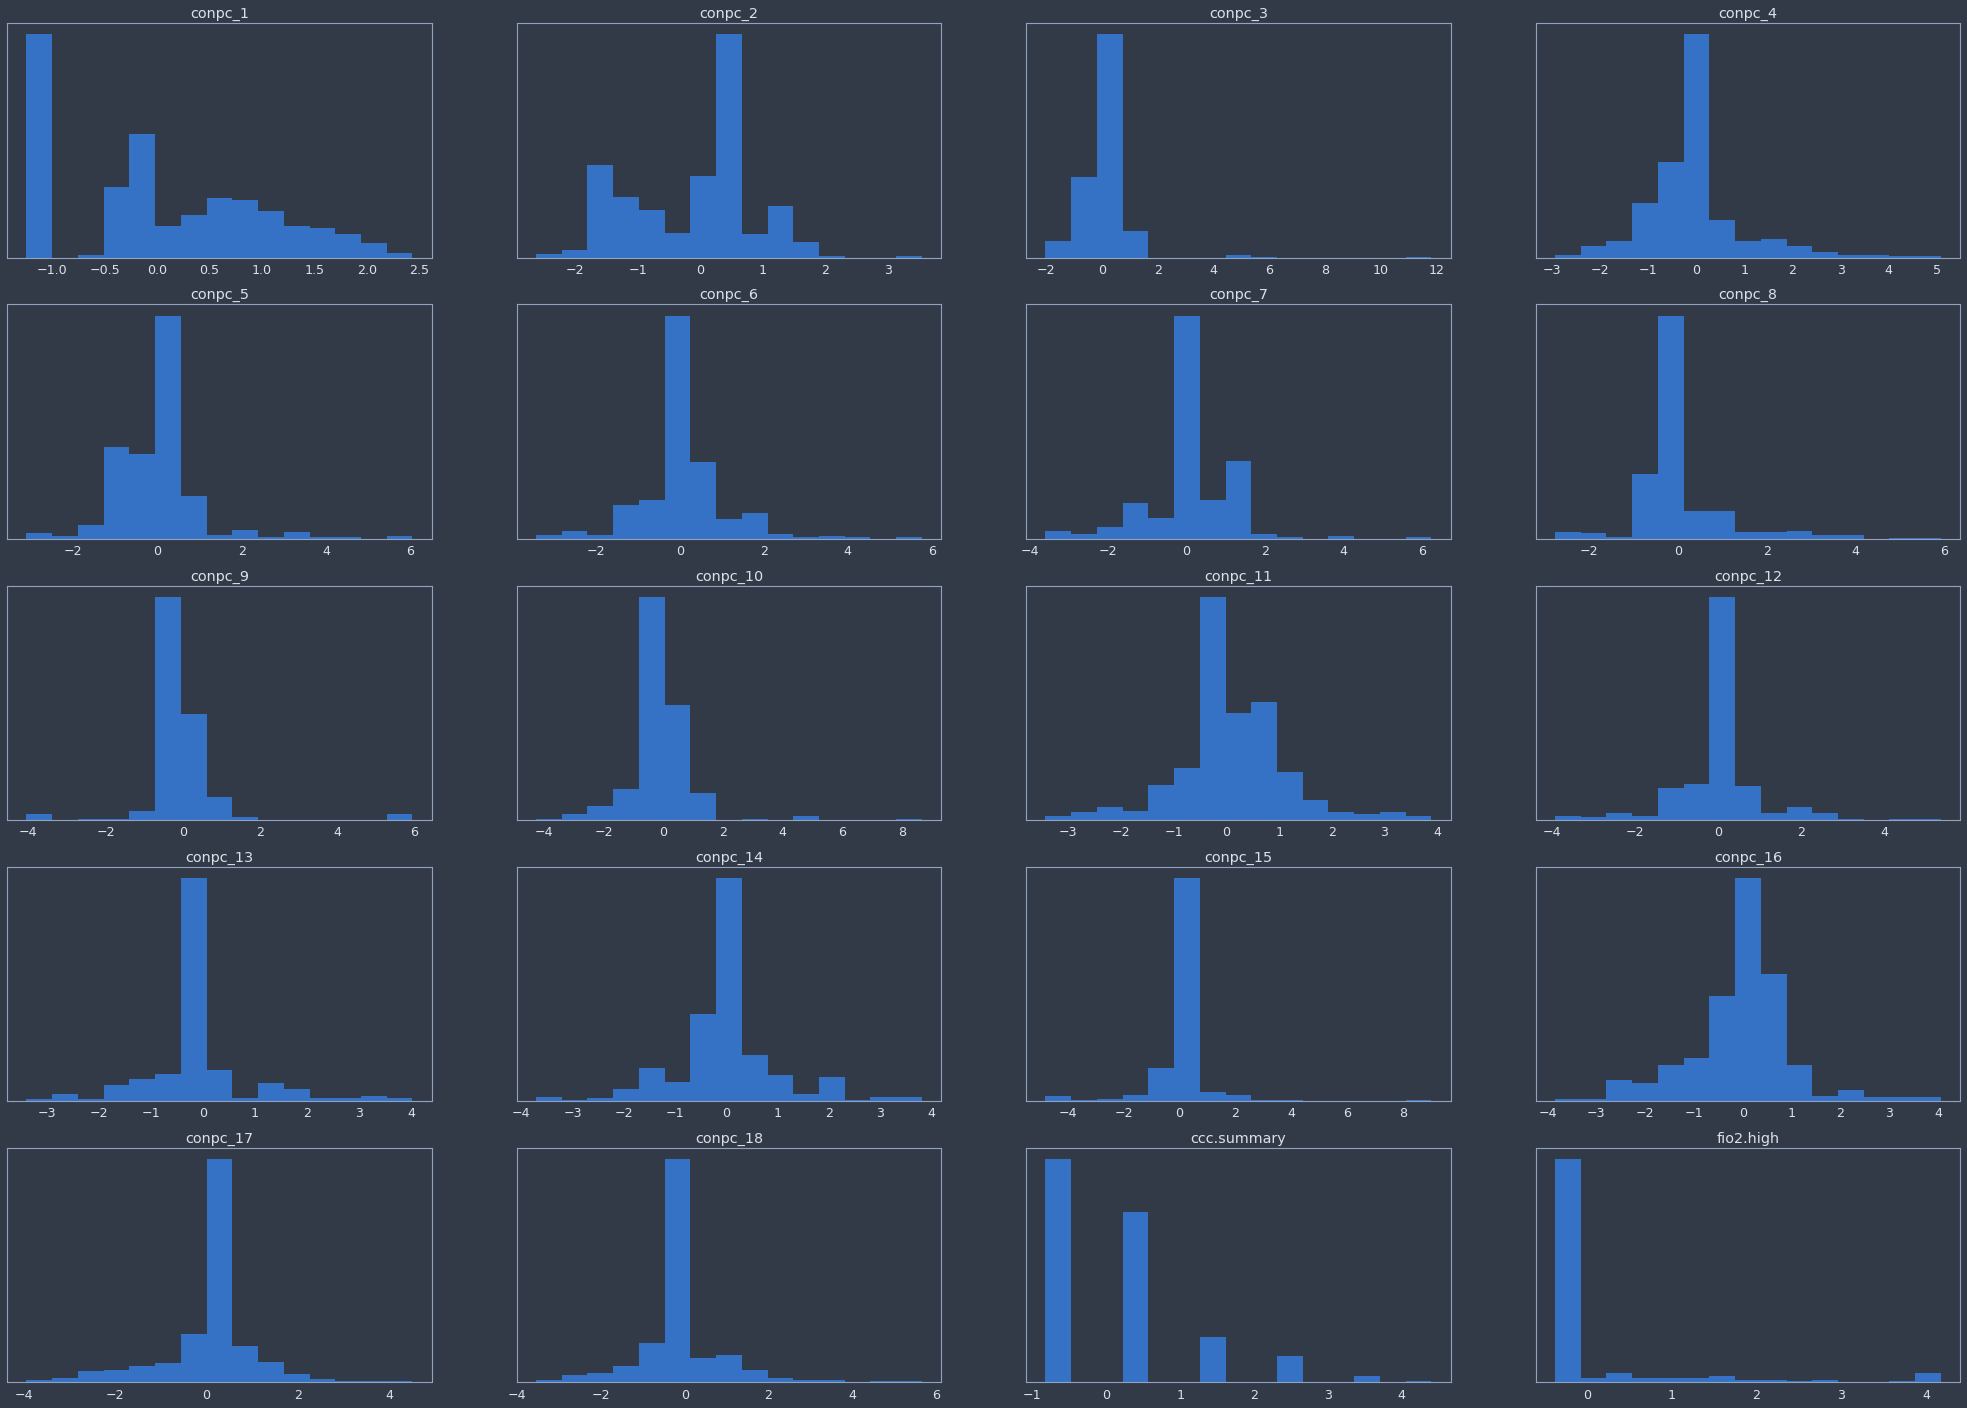

In [37]:
conpc_fg2

##### Infection

###### Compute

In [38]:
infpc_fg2 = plt.figure(figsize=(35,50))

for i,c in enumerate(infpc_cs):

    ax = infpc_fg2.add_subplot(10,4,i+1)
    ax.hist(std_df[c],density=True,bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

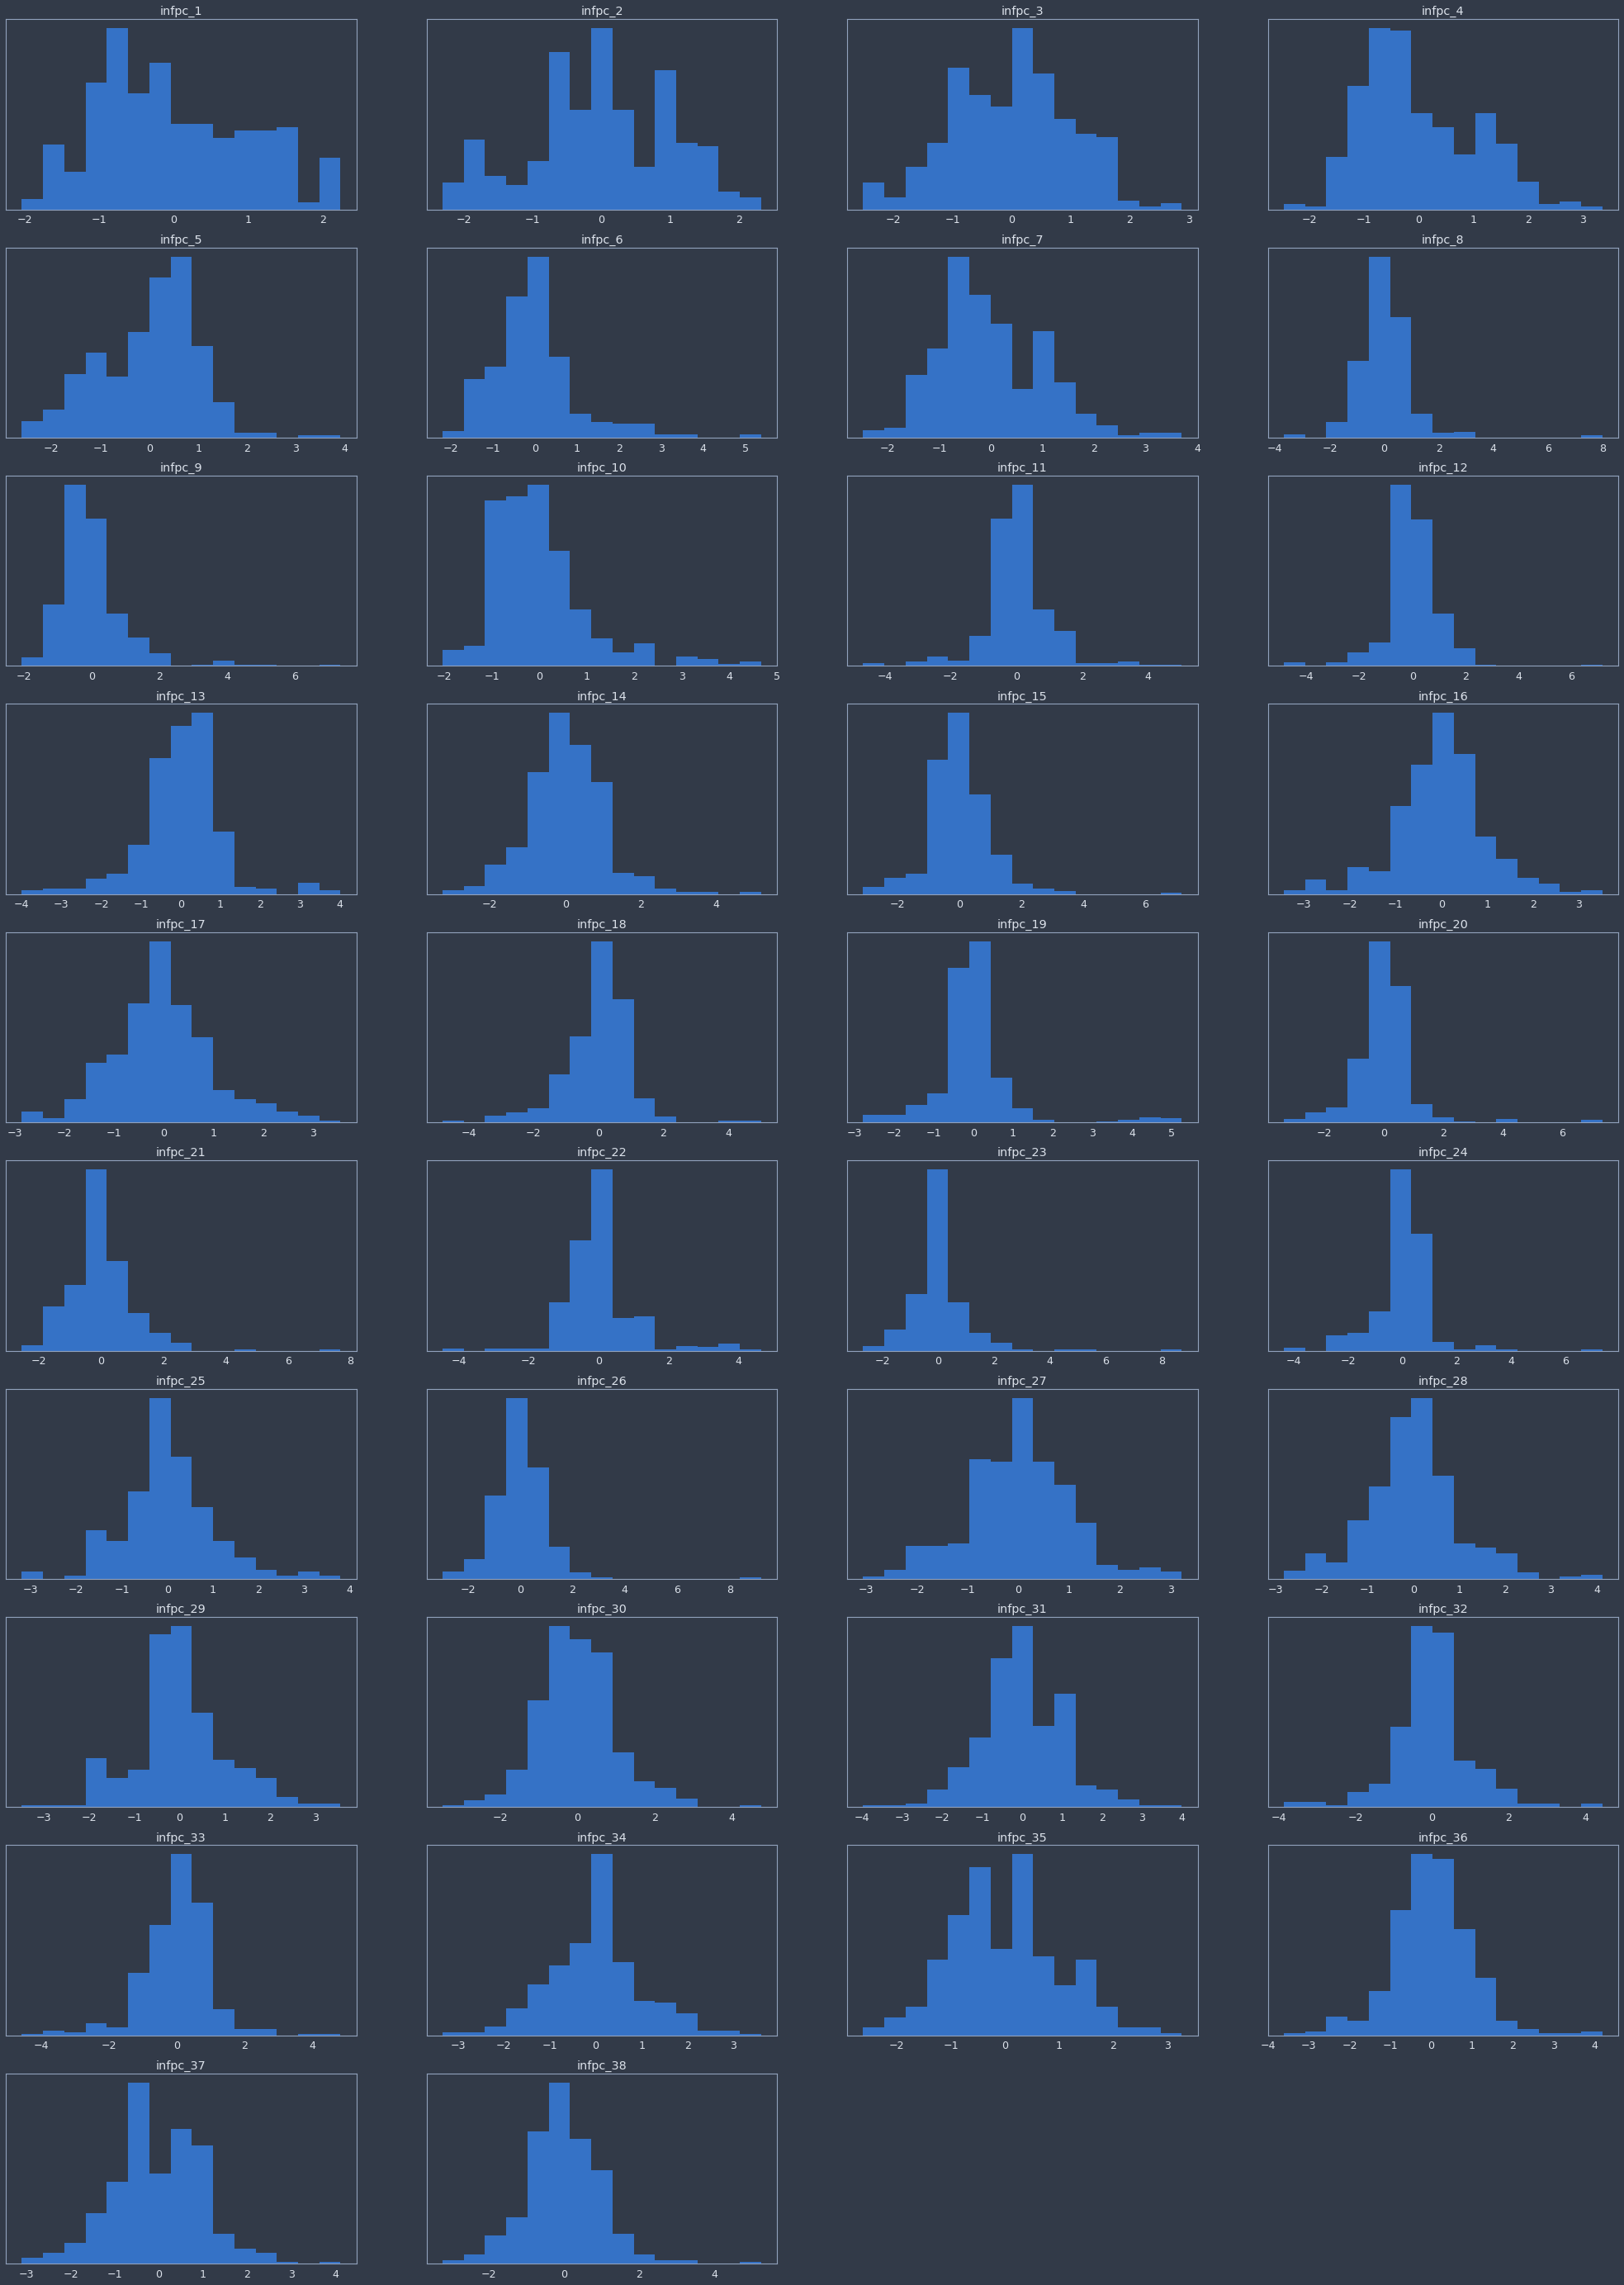

In [39]:
infpc_fg2

## Single-Protein Clustering Based on Bimodal Proteins

### Identification of Bimodal Proteins

###### Compute

ValueError: num must be 1 <= num <= 40, not 41

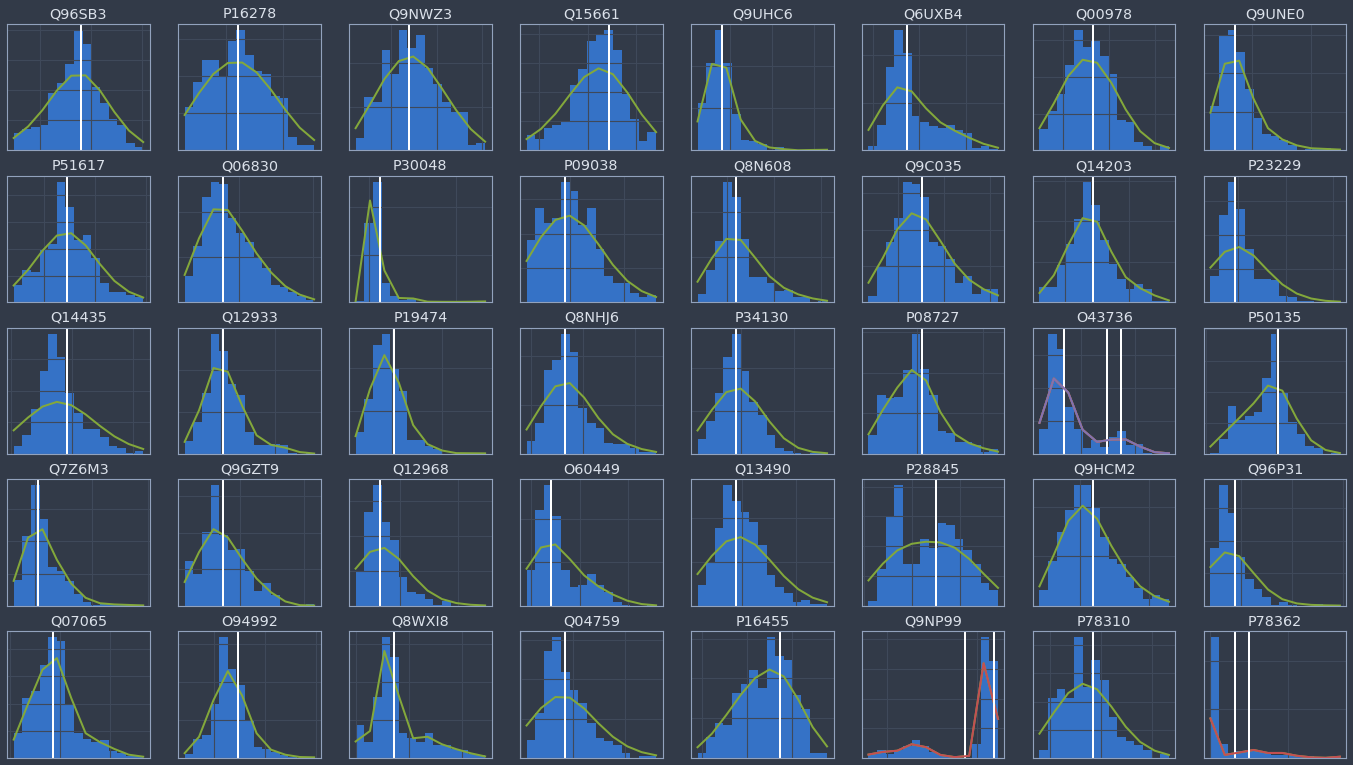

In [88]:
pro_df  = imp_df[protein_cs].copy(deep=True)
bim_fig = plt.figure(figsize=(24,13.5))
b       = 15
bims    = {}
i       = 1

for p in pro_df.columns:

    X   = pro_df.loc[:,p].values
    kde = skn.KernelDensity(kernel='gaussian',bandwidth=1).fit(X.reshape(-1,1))
    y,x = np.histogram(X,bins=b)
    w   = x[1]-x[0]
    d   = 10
    x   = np.linspace(x.min(),x.max(),d)
    x   = x[:,np.newaxis]
    k   = np.exp(kde.score_samples(x))
    dk  = np.gradient(k)
    ddk = np.gradient(dk)
    sk  = np.sign(dk)
    ssk = np.sign(ddk)
    C1  = sk[1:]-sk[:-1]!=0
    C2  = ddk[1:]>10^-7
    C   = np.concatenate([[False],C1&C2])
    x0s = x[C]
    
    if len(x0s)!=0:
        
        tx0s = []
        
        for x0 in x0s:
            C3 = y[:np.where(x==x0)[0][0]].sum()/y.sum()>.2
            C4 = y[np.where(x==x0)[0][0]:].sum()/y.sum()>.2
            if C3&C4:
                tx0s += [x0]
        
        if len(tx0s)!=0:
            
            ax = bim_fig.add_subplot(5,8,i)
            ax.hist(X,bins=b,density=True)
        
            for tx0 in tx0s:
                ax.plot(x,k,lw=2)
                ax.axvline((tx0-w/2),lw=2,color='white')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_title(p)
            
            bims[p] = tx0s[0][0]
            i+=1

###### Figure

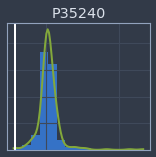

In [75]:
bim_fig

### Significantly Associated Variables

#### Physiology

###### Compute

In [42]:
bimphy_fig,df = protein_f_association(imp_df,bims,'physio',sel_dc['physio'],.01,'f-test')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48798/48798 [24:00<00:00, 33.87it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48798/48798 [24:25<00:00, 33.30it/s]


###### Figure

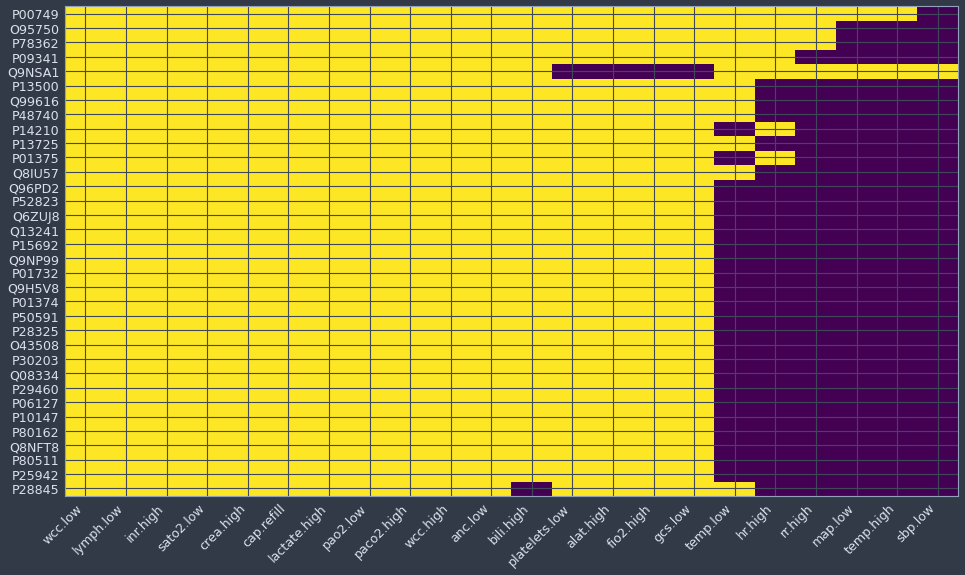

In [43]:
bimphy_fig

#### Organ Failure

###### Associated Organs

In [44]:
test_cs       = [c for c in sel_dc['organs'] if ('cons' not in c) and ('score' not in c)]
bimorg_fig,df = protein_f_association(imp_df,bims,'organs',test_cs,.01,'f-test')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48798/48798 [23:09<00:00, 35.12it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48798/48798 [24:21<00:00, 33.40it/s]


###### Figure

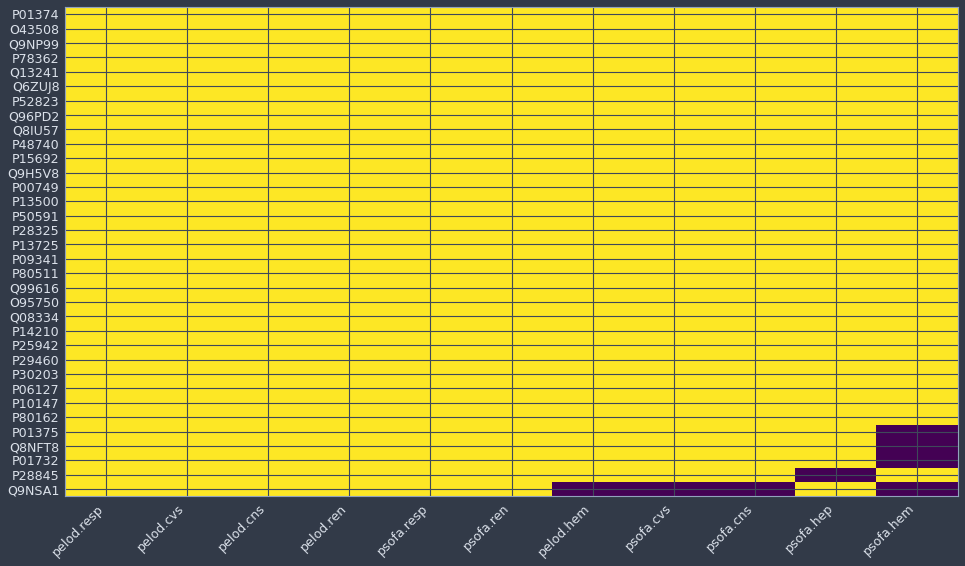

In [45]:
bimorg_fig

#### Complex Chronic Conditions

###### Associated Chronic Condition

In [46]:
test_cs       = [c for c in sel_dc['chronic_conditions'] if ('cate' not in c) and ('summary' not in c)]
bimccc_fig,df = protein_f_association(imp_df,bims,'chronic_conditions',test_cs,.01,'fisher')

###### Figure

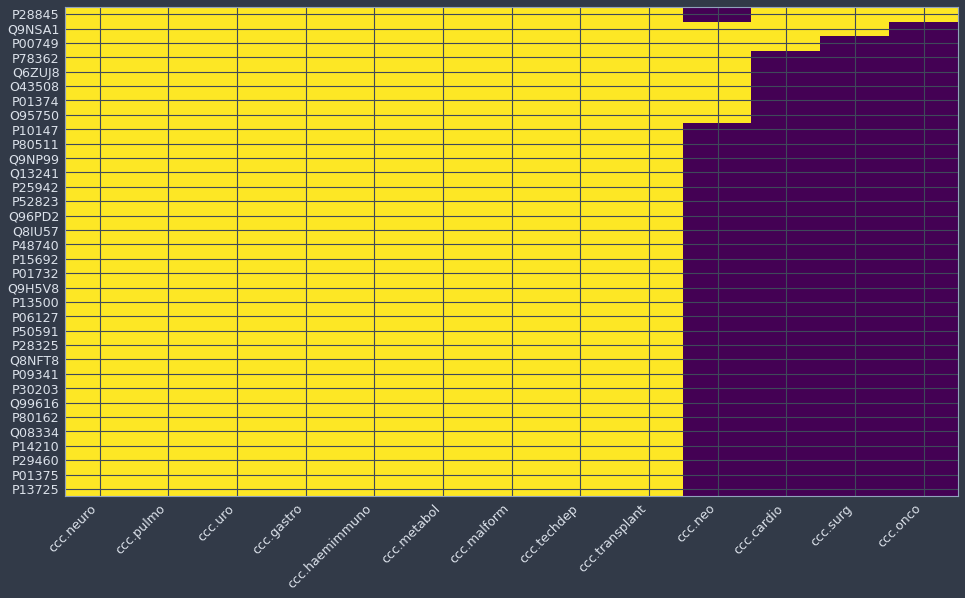

In [47]:
bimccc_fig

#### Focus of Infection

###### Associated Infection Focus

In [48]:
test_cs       = [c for c in sel_dc['infections']]
biminf_fig,df = protein_f_association(imp_df,bims,'infections',test_cs,.01,'fisher')

###### Figure

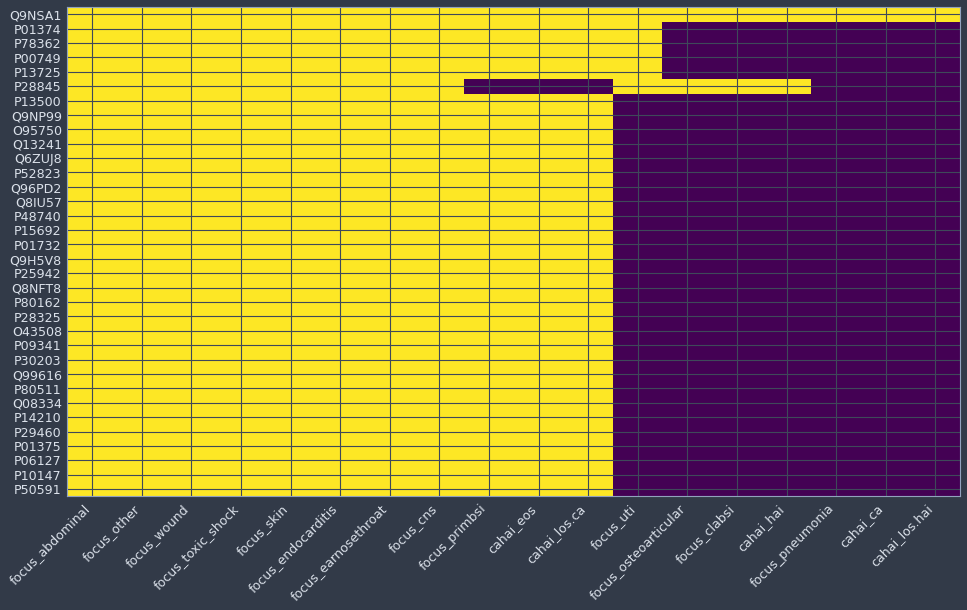

In [49]:
biminf_fig

#### Pathogen

###### Associated Pathogen

In [50]:
test_cs       = [c for c in sel_dc['pathogen']]
bimpat_fig,df = protein_f_association(imp_df,bims,'pathogen',test_cs,.01,'fisher')

###### Figure

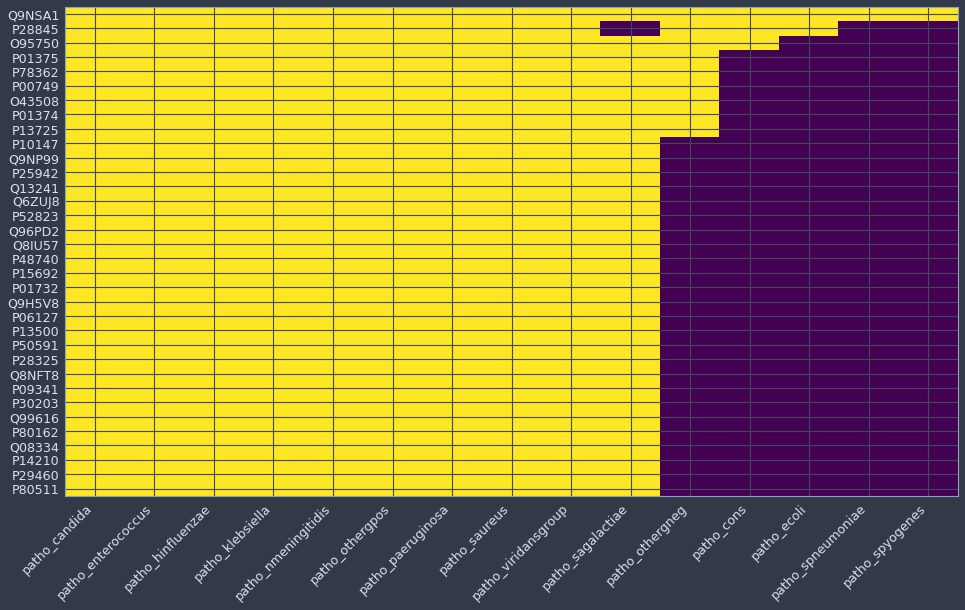

In [51]:
bimpat_fig

#### Demographics

###### Associated Demographics

In [52]:
test_cs       = [c for c in sel_dc['demographics'] if 'age' not in c]
bimdem_fig,df = protein_f_association(imp_df,bims,'demographics',test_cs,.01,'fisher')

###### Figure

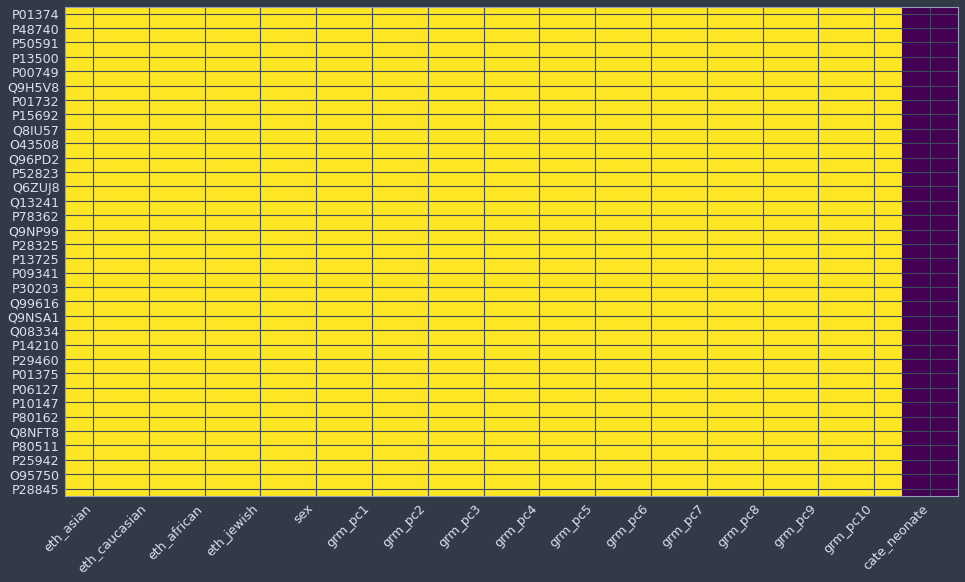

In [53]:
bimdem_fig

#### Proteins

###### Associated Proteins

In [54]:
test_cs = sel_dc['proteome']
bimpro_fig,bimpro_df = protein_f_association(imp_df,bims,'proteome',test_cs,.01,'f-test')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48663/48663 [58:16<00:00, 13.92it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48663/48663 [58:16<00:00, 13.92it/s]


###### Figure

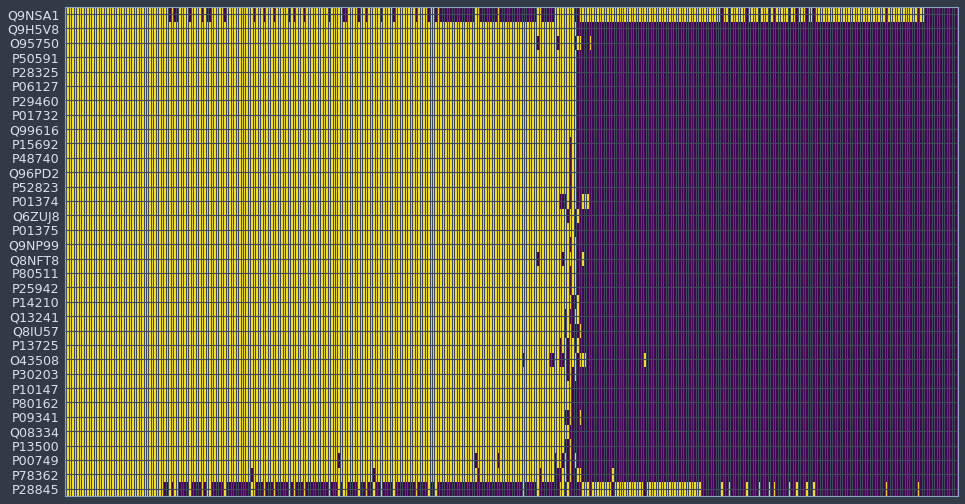

In [55]:
bimpro_fig

### A-Priori Proteomic Clusters

###### Compute

In [56]:
bim_lst    = bimpro_df.index.tolist()
asso_lst   = bimpro_df.T[bimpro_df.sum(axis=0)>=2].index.tolist()
q9nsa1_lst = bimpro_df.T[bimpro_df.T.Q9NSA1==1].index.tolist()

bim2_lst   = [c for c in bim_lst if c in asso_lst]
venn_fig   = plt.figure(figsize=(4,3))

A   = bim_lst
B   = asso_lst
C   = q9nsa1_lst
AB  = [a for a in A if a in B]
AC  = [a for a in A if a in C]
BC  = [b for b in B if b in C]
ABC = [a for a in AB if a in C]

v = mpv.venn3(subsets=(len(A)-len(AB)-len(AC)+len(ABC),\
                   len(B)-len(AB)-len(BC)+len(ABC),\
                   len(AB),\
                   len(C)-len(AC)-len(BC)+len(ABC),\
                   len(AC)-len(ABC),\
                   len(BC)-len(ABC),\
                   len(ABC)),\
          set_labels = ('Bimodal','Q99616-group','Q9NSA1-group'))

plt.tight_layout()
plt.close()
venn_fig.savefig('venn.png',dpi=600)

imp_df['Q99616_cluster'] = 0
imp_df['Q9NSA1_cluster'] = 0
imp_df.loc[imp_df.Q99616>=bims['Q99616'],'Q99616_cluster'] = 1
imp_df.loc[imp_df.Q9NSA1>=bims['Q9NSA1'],'Q9NSA1_cluster'] = 1
C1 = imp_df.Q99616_cluster==1
C2 = imp_df.Q9NSA1_cluster==1

###### Figure

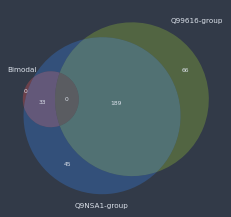

In [57]:
venn_fig

###### Print

In [58]:
print('low Q99616 and low Q9NSA1  :',imp_df[~C1&~C2].shape[0])
print('low Q99616 and high Q9NSA1 :',imp_df[~C1&C2].shape[0])
print('high Q99616 and low Q9NSA1 :',imp_df[C1&~C2].shape[0])
print('high Q99616 and high Q9NSA1:',imp_df[C1&C2].shape[0])

low Q99616 and low Q9NSA1  : 209
low Q99616 and high Q9NSA1 : 61
high Q99616 and low Q9NSA1 : 62
high Q99616 and high Q9NSA1: 26


## Single-View Clustering

### Search Grid

In [202]:
n_states = 10**2
n_comps  = [2]
epss     = np.linspace(.1,10,100)
minss    = np.arange(10,41)

### Confounders

In [203]:
dem_df = std_df[dempc_cs+['age.at.bc']].copy(deep=True)

### Physiological View

#### Definition

###### Definition

In [204]:
phy_df = std_df[physio_cs].copy(deep=True)

###### Orthogonalization

In [205]:
phy_odf = ortho_project(phy_df,dem_df)

#### DBSCAN

##### Optimization

###### Grid Search

In [206]:
label     = 'physio'
phyopt_df = cluster_optimization(phy_odf,n_states,n_comps,epss,minss,label)
phyopt_df.head(3)

,dim,state,epsilon,n_mins,n_clusters,silhouette
2226,2,17,7.2,35,3,0.299174
2289,2,17,7.4,36,3,0.298439
2258,2,17,7.3,36,3,0.298061


###### Compute Silhouettes

In [207]:
phyts_df,phyclu_df = optimal_clusters(phy_odf,phyopt_df)
phyts_fig          = cluster_fig(phyts_df,phyclu_df,'dbscan')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


###### Figure

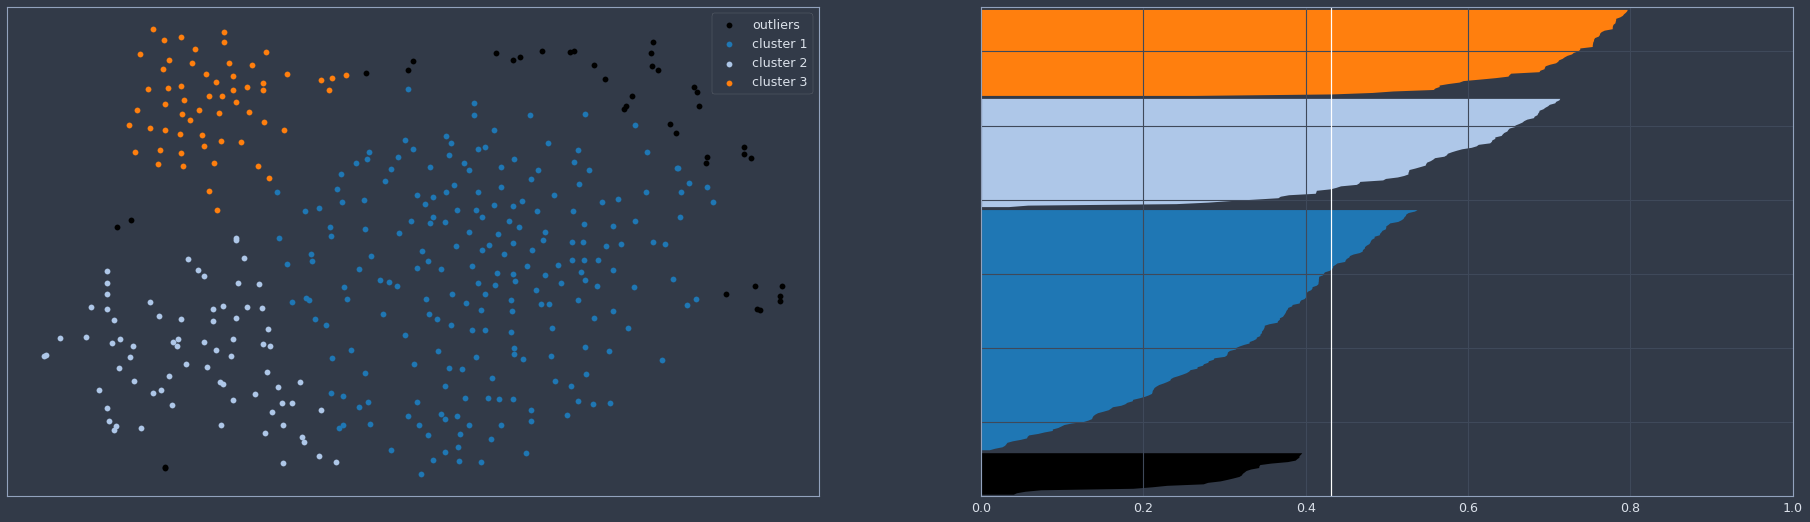

In [208]:
phyts_fig

##### Cluster Characteristics

In [249]:
impsv_df    = assign_clusters(imp_df,phyclu_df,label+'_dbscan','dbscan')
char_cols   = ['cons05.resp','cons05.cvs','cons05.cns','cons05.ren','cons05.hep','cons05.hem','cons05.score','sex','age.at.bc','ccc.summary']
phydchar_df = impsv_df[char_cols+[label+'_dbscan_cluster']].groupby(label+'_dbscan_cluster').mean().T
phydchar_df[[c for c in phydchar_df.columns if c!=-1]]

physio_dbscan_cluster,0,1,2
cons05.resp,0.144186,0.391892,0.033898
cons05.cvs,0.083721,0.135135,0.101695
cons05.cns,0.055814,0.013514,0.000000
cons05.ren,0.051163,0.013514,0.000000
cons05.hep,0.046512,0.000000,0.237288
cons05.hem,0.041860,0.054054,0.745763
cons05.score,0.423256,0.608108,1.118644
sex,0.632558,0.648649,0.559322
age.at.bc,1605.976744,85.918919,2406.559322
ccc.summary,0.637209,0.891892,1.000000


##### Most Differentiating Features

###### Compute

In [209]:
sel_dc['continuous'] = sel_dc['physio']+\
                       [c for c in sel_dc['organs'] if ('cons' not in c) or ('summary' in c)]+\
                       [c for c in sel_dc['demographics'] if 'age' in c]+\
                       [c for c in sel_dc['chronic_conditions'] if 'summary' in c]+\
                       sel_dc['proteome']
sel_dc['binary']     = [c for c in sel_dc['organs'] if ('cons' in c) and ('summary' not in c)]+\
                       [c for c in sel_dc['demographics'] if 'age' not in c]+\
                       [c for c in sel_dc['chronic_conditions'] if 'summary' not in c]+\
                       sel_dc['infections']+\
                       sel_dc['pathogen']+\
                       sel_dc['treatment']

In [238]:
phyovr_df     = f_pvalues_1vR(impsv_df,sel_dc,label+'_dbscan',.05)
phyfstat_fig1 = fstat_fig_1vR(impsv_df,phyovr_df,label+'_dbscan')

###### Figure

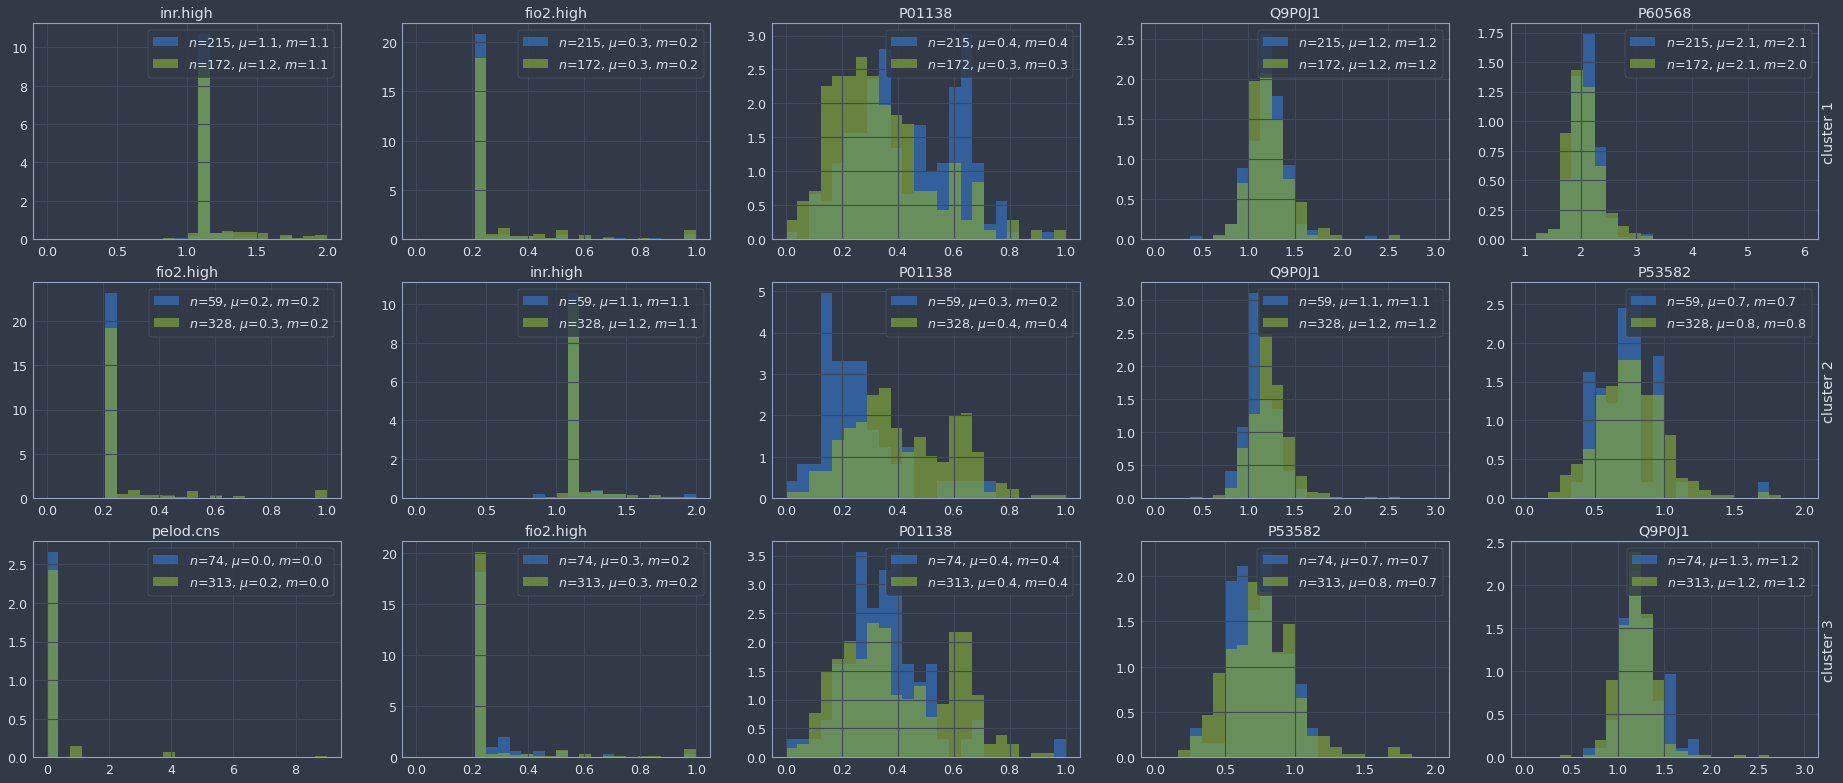

In [239]:
phyfstat_fig1

#### KCC

##### Load

###### Compute

In [141]:
t  = 'DBSCAN_physio_view_KCC_3_TSNE_embeddings.csv'
c  = 'DBSCAN_physio_view_KCC_3_assignments.csv'
ft = '%s%s' % (sngl_dir,t)
fc = '%s%s' % (sngl_dir,c)

phytsne_df = pd.read_csv(ft,index_col=0)
phykcc_df  = pd.read_csv(fc,index_col=0)
phykcc_df  = pd.concat([phykcc_df,phytsne_df],axis=1)
phykcc_df  = phykcc_df.rename(\
                  columns={'assignment':'kcc','TSNE 1':'ts1','TSNE_2':'ts2'})

phyhie_fig = cluster_fig(phykcc_df[['ts1','ts2']],phykcc_df,'kcc')

###### Figure

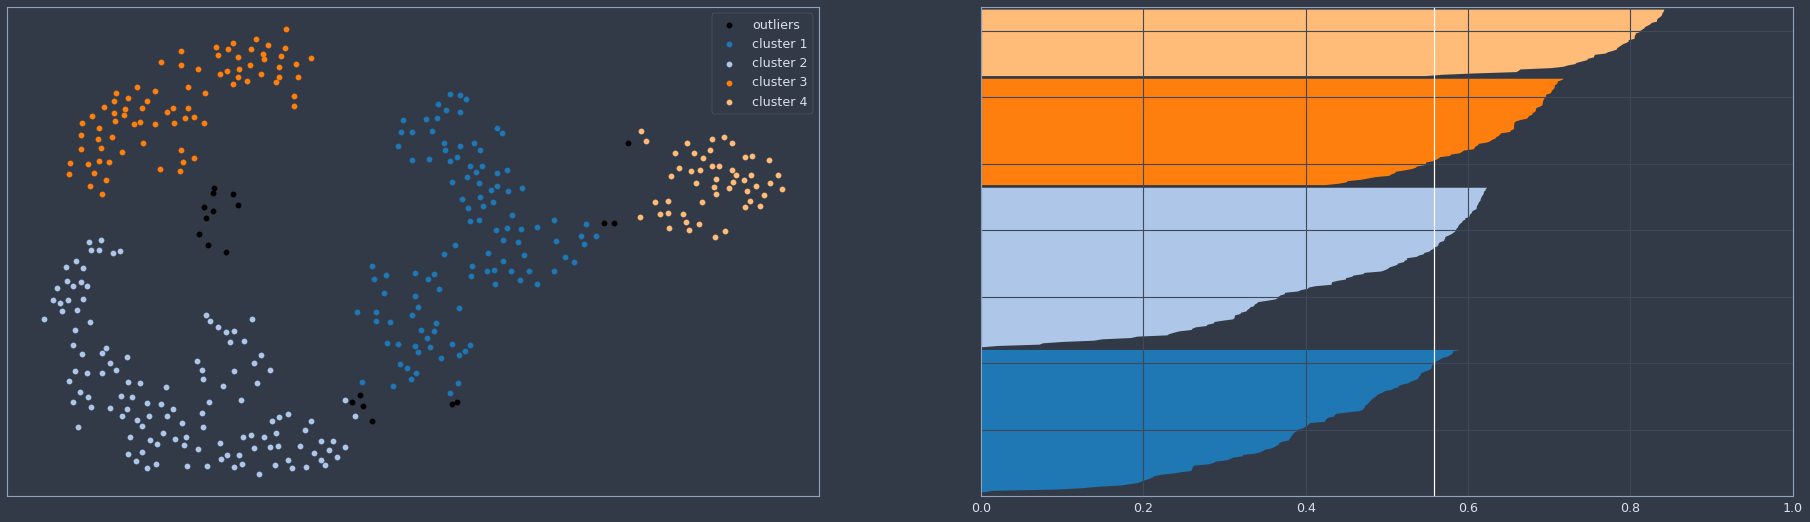

In [147]:
phyhie_fig3

##### Most Differentiating Features

###### Compute

In [139]:
impsv_df = assign_clusters(imp_df,phyhie_df,label,'hieclu')
phyovr_df = f_pvalues_1vR(impsv_df[contest_cs],label,.05)
phyfstat_fig1 = fstat_fig_1vR(impsv_df,phyovr_df,label)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7938/7938 [01:48<00:00, 72.99it/s]


###### Figure

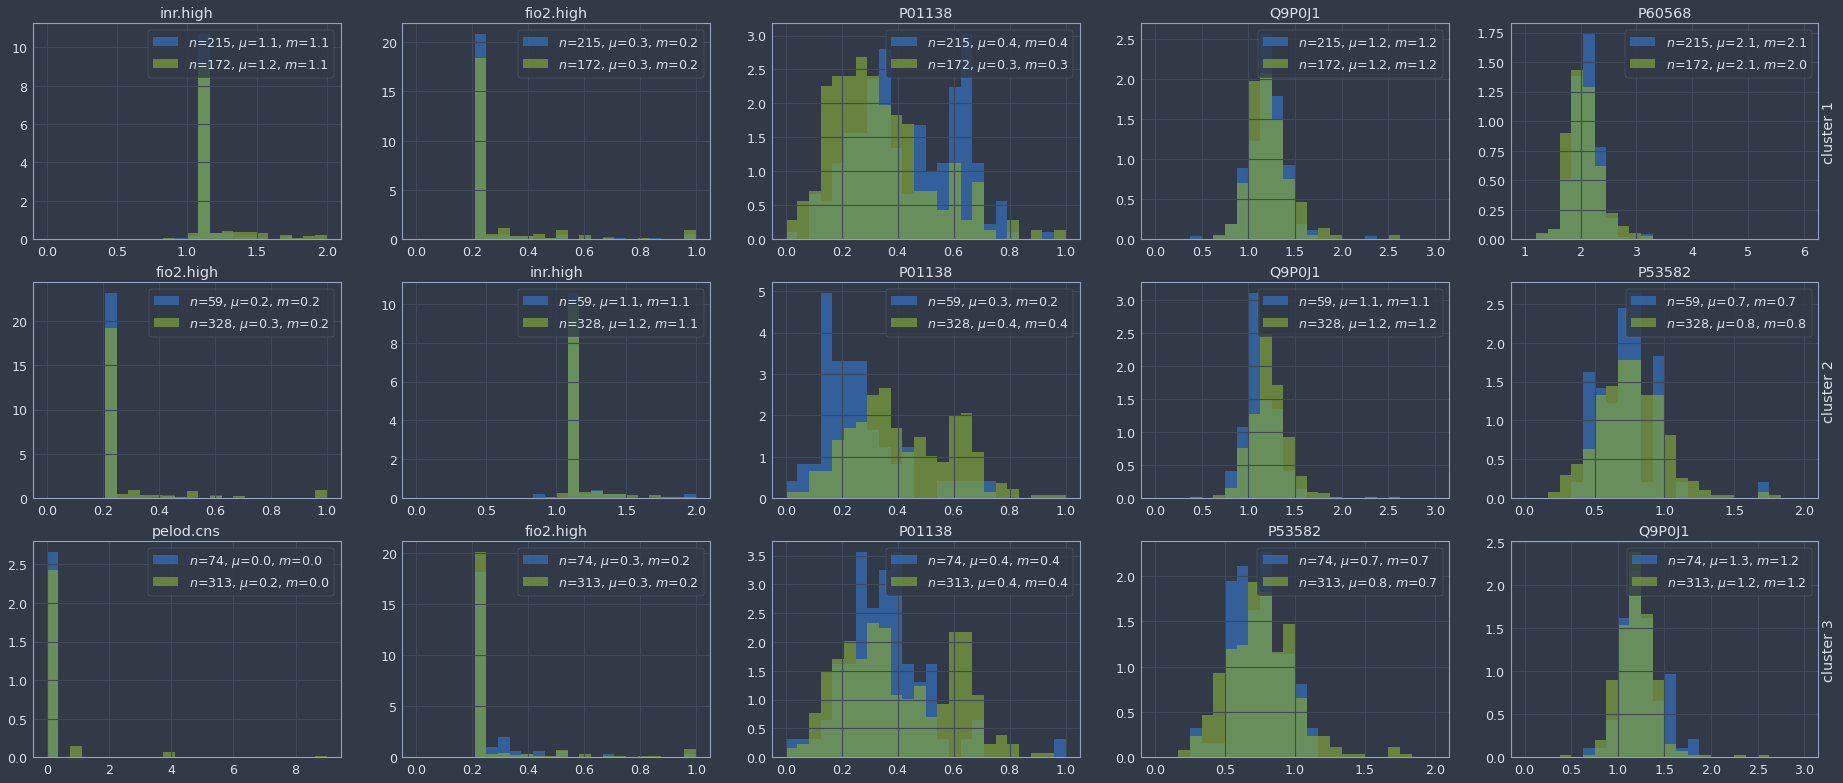

In [140]:
phyfstat_fig1

#### Hierarchical Clustering

###### Compute

In [148]:
phyhie_fig,phyhie_df = hierarchical_cluster(phykcc_df,4)
phyhie_fig2          = cluster_fig(phykcc_df,phyhie_df,'hieclu')

###### Figure

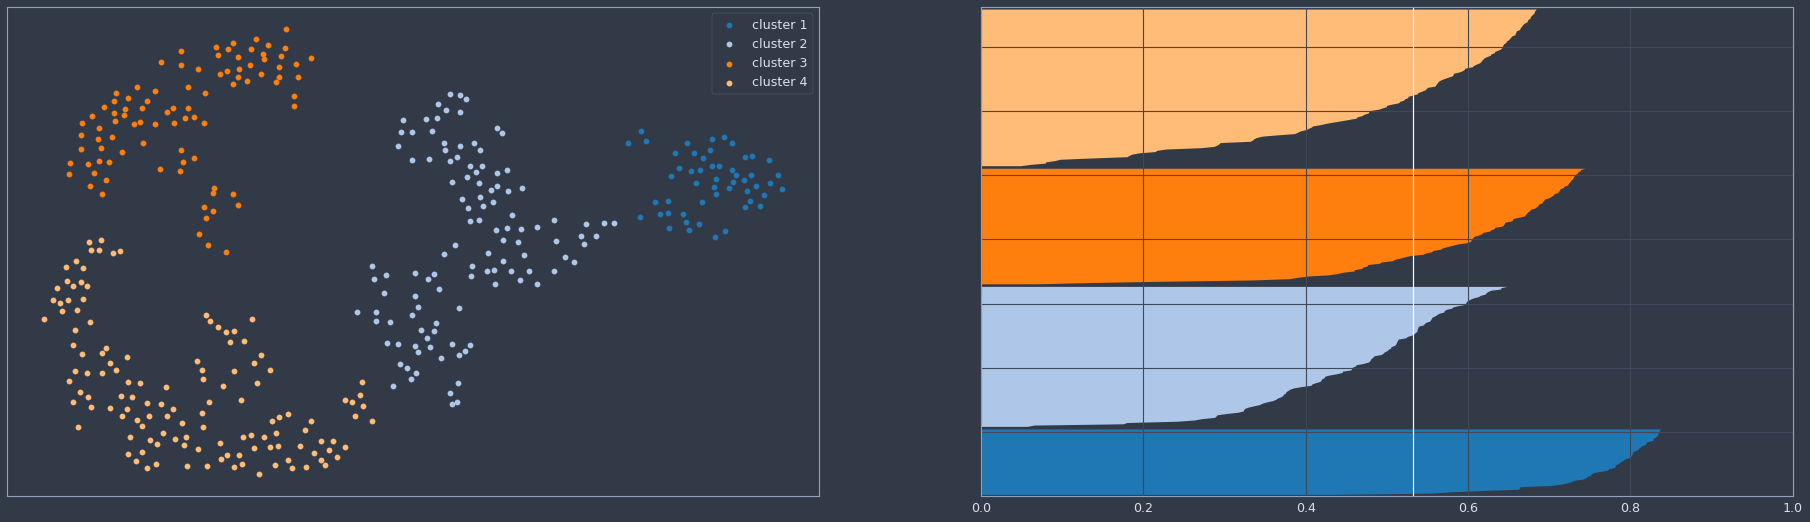

In [149]:
phyhie_fig2

##### Characterization

###### Compute

In [150]:
sel_dc['continuous'] = sel_dc['physio']+\
                       [c for c in sel_dc['organs'] if ('cons' not in c) or ('summary' in c)]+\
                       [c for c in sel_dc['demographics'] if 'age' in c]+\
                       [c for c in sel_dc['chronic_conditions'] if 'summary' in c]+\
                       sel_dc['proteome']
sel_dc['binary']     = [c for c in sel_dc['organs'] if ('cons' in c) and ('summary' not in c)]+\
                       [c for c in sel_dc['demographics'] if 'age' not in c]+\
                       [c for c in sel_dc['chronic_conditions'] if 'summary' not in c]+\
                       sel_dc['infections']+\
                       sel_dc['pathogen']+\
                       sel_dc['treatment']

In [164]:
contest_cs = sel_dc['continuous']+['physio_cluster']
impsv_df = assign_clusters(imp_df,phyhie_df,label,'hieclu')
phyf_df,phynull_df = f_pvalues(impsv_df[contest_cs],label,.05)
phyfstat_fig = fstat_fig(impsv_df,phyf_df,label)
phyf_df.head(10)

,p_value,f_stat
pelod.hem,0.000126,285.891938
P19878,0.000126,168.511854
psofa.hem,0.000126,154.642404
P12724,0.000126,147.076144
Q6EIG7,0.000126,141.147991
Q9UMR7,0.000126,132.317189
P14317,0.000126,128.703569
Q02880,0.000126,123.485949
Q96LA6,0.000126,113.773520
Q92520,0.000126,112.992336


###### One-versus-Rest

In [231]:
phyovr_df = f_pvalues_1vR(impsv_df[contest_cs],label,.5)
phyfstat_fig2 = fstat_fig_1vR(impsv_df,phyovr_df,label)

###### Figure

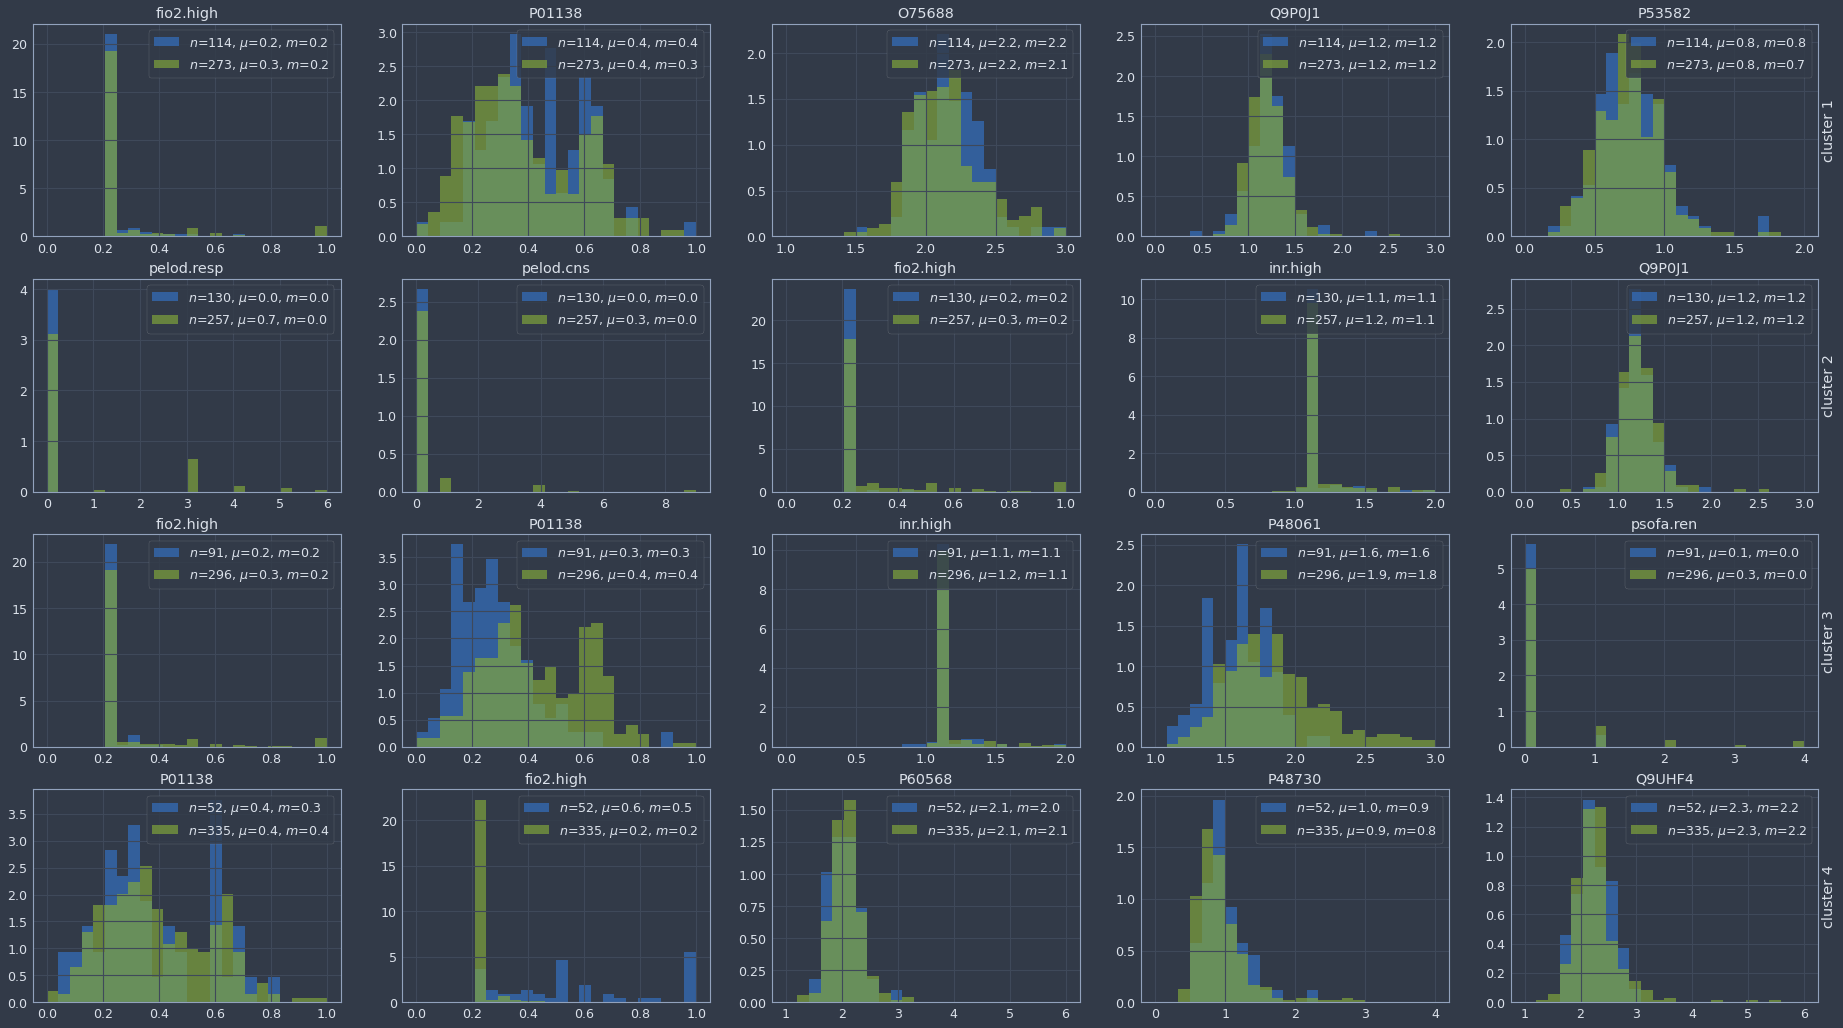

In [232]:
phyfstat_fig2

### Contextual View

#### Definition

###### Definition

In [74]:
con_df = std_df[conpc_cs+infpc_cs+['fio2.high']].copy(deep=True)

###### Orthogonalization

In [75]:
con_odf = ortho_project(con_df,dem_df)

#### Clustering Optimization

###### Grid Search

In [76]:
label     = 'context'
conopt_df = cluster_optimization(con_odf,n_states,n_comps,epss,minss,label)
conopt_df.head(3)

,dim,state,epsilon,n_mins,n_clusters,silhouette
2512,2,73,8.2,11,2,0.099448
1954,2,73,6.4,11,2,0.083641
2543,2,73,8.3,11,2,0.079932


###### Compute Silhouettes

In [77]:
conts_df,conclu_df = optimal_clusters(con_odf,conopt_df)
conts_fig          = cluster_fig(conts_df,conclu_df,'dbscan')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.41s/it]


###### Figure

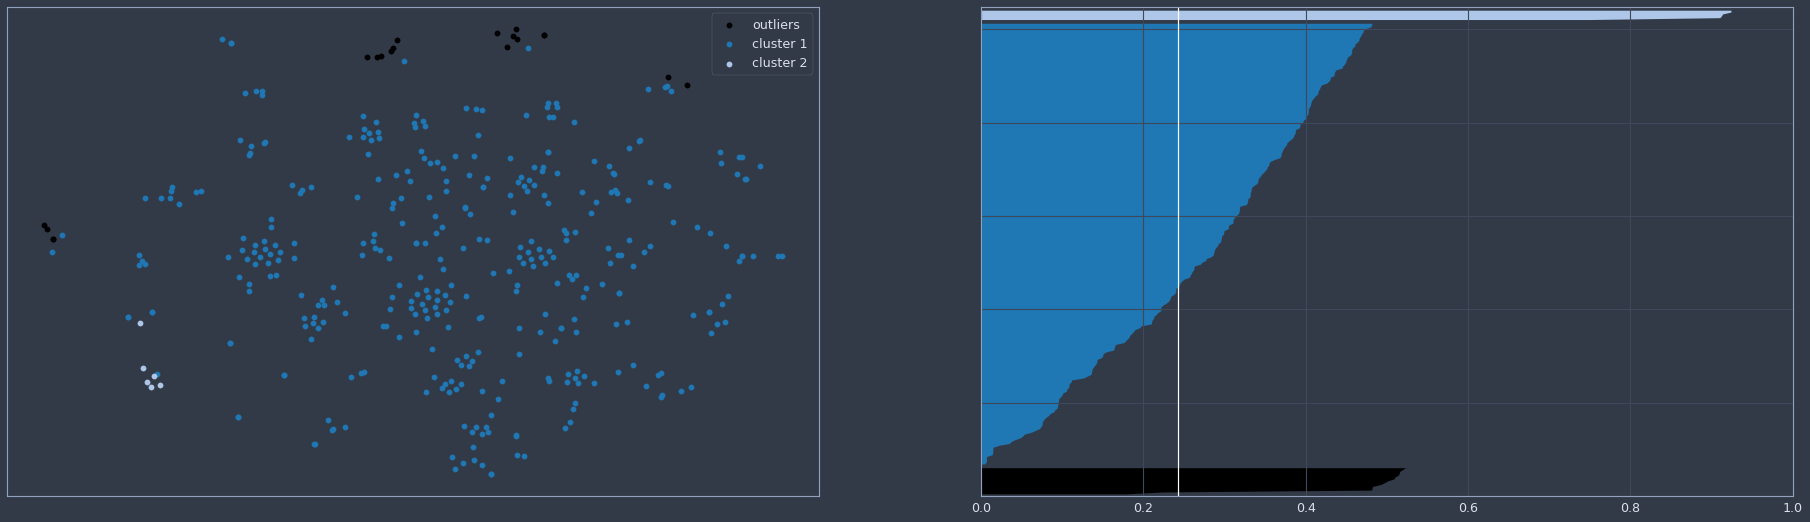

In [78]:
conts_fig

#### Hierarchical Clustering

###### Compute

In [79]:
conhie_fig,conhie_df = hierarchical_cluster(conts_df,3)
conhie_fig2          = cluster_fig(conts_df,conhie_df,'hieclu')

###### Figure

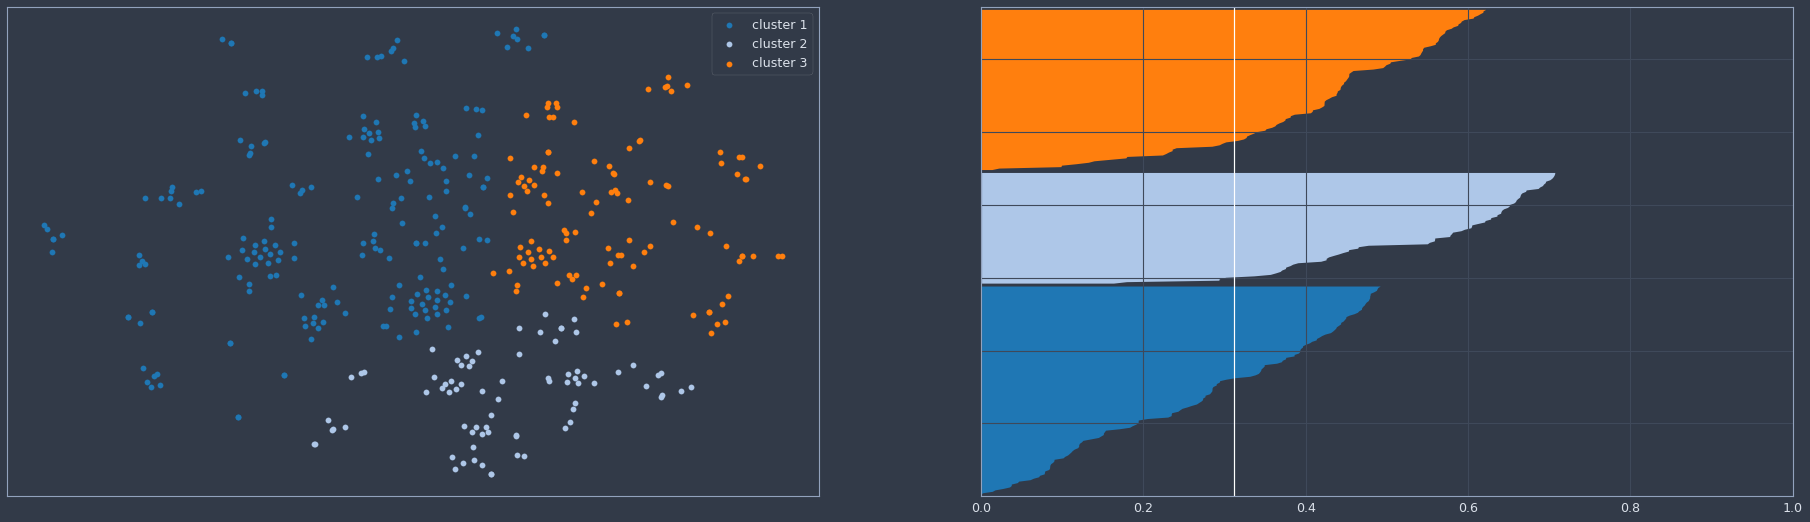

In [80]:
conhie_fig2

#### F-Test

###### Compute

In [81]:
contest_cs = sel_dc['continuous']+['context_cluster']
impsv_df = assign_clusters(imp_df,conhie_df,label,'hieclu')
conf_df,connull_df = f_pvalues(impsv_df[contest_cs],label,.05)
confstat_fig = fstat_fig(impsv_df,conf_df,label)
conf_df.head(10)

,p_value,f_stat
P18627,0.000126,39.508411
P28325,0.000126,37.016219
P80511,0.000126,35.902300
Q96PD2,0.000126,35.145220
Q9H5V8,0.000126,34.498345
Q14116,0.000126,34.178091
P09603,0.000126,34.169181
P14210,0.000126,33.832573
P00749,0.000126,33.813455
P52823,0.000126,33.760233


###### Figure

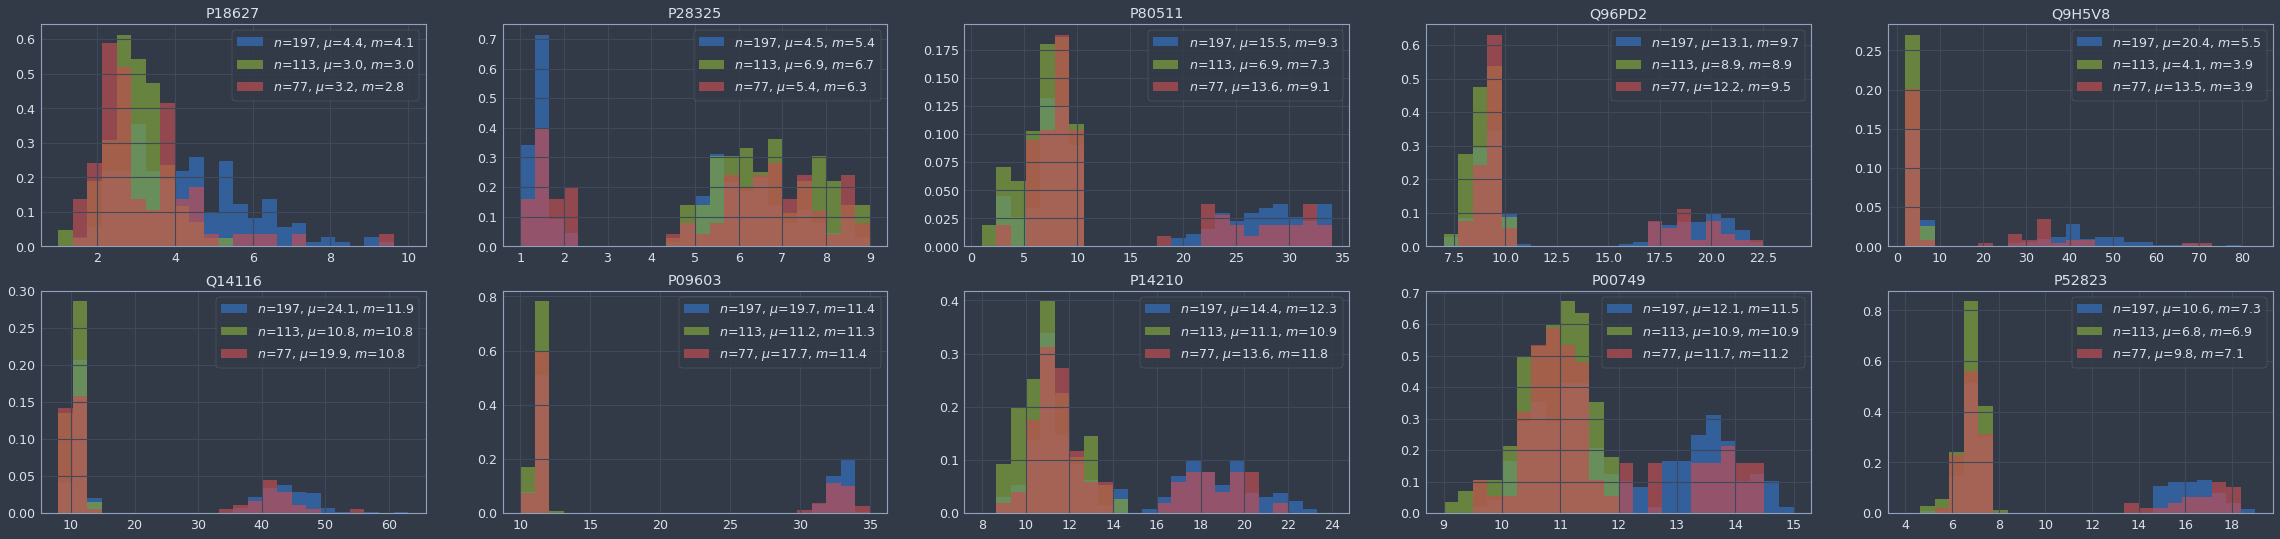

In [82]:
confstat_fig

### Clinical View

#### Definition

###### Definition

In [83]:
cli_df = std_df[physio_cs+conpc_cs+infpc_cs].copy(deep=True)

###### Orthogonalization

In [84]:
cli_odf = ortho_project(cli_df,dem_df)

#### Clustering Optimization

###### Grid Search

In [85]:
label  = 'clinic'
cliopt_df = cluster_optimization(cli_odf,n_states,n_comps,epss,minss,label)
cliopt_df.head(3)

,dim,state,epsilon,n_mins,n_clusters,silhouette
2387,2,56,7.8,10,2,0.203442
2356,2,56,7.7,10,2,0.198788
2325,2,56,7.6,10,2,0.198226


###### Compute Silhouettes

In [86]:
clits_df,cliclu_df = optimal_clusters(cli_odf,cliopt_df)
clits_fig          = cluster_fig(clits_df,cliclu_df,'dbscan')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.37s/it]


###### Figure

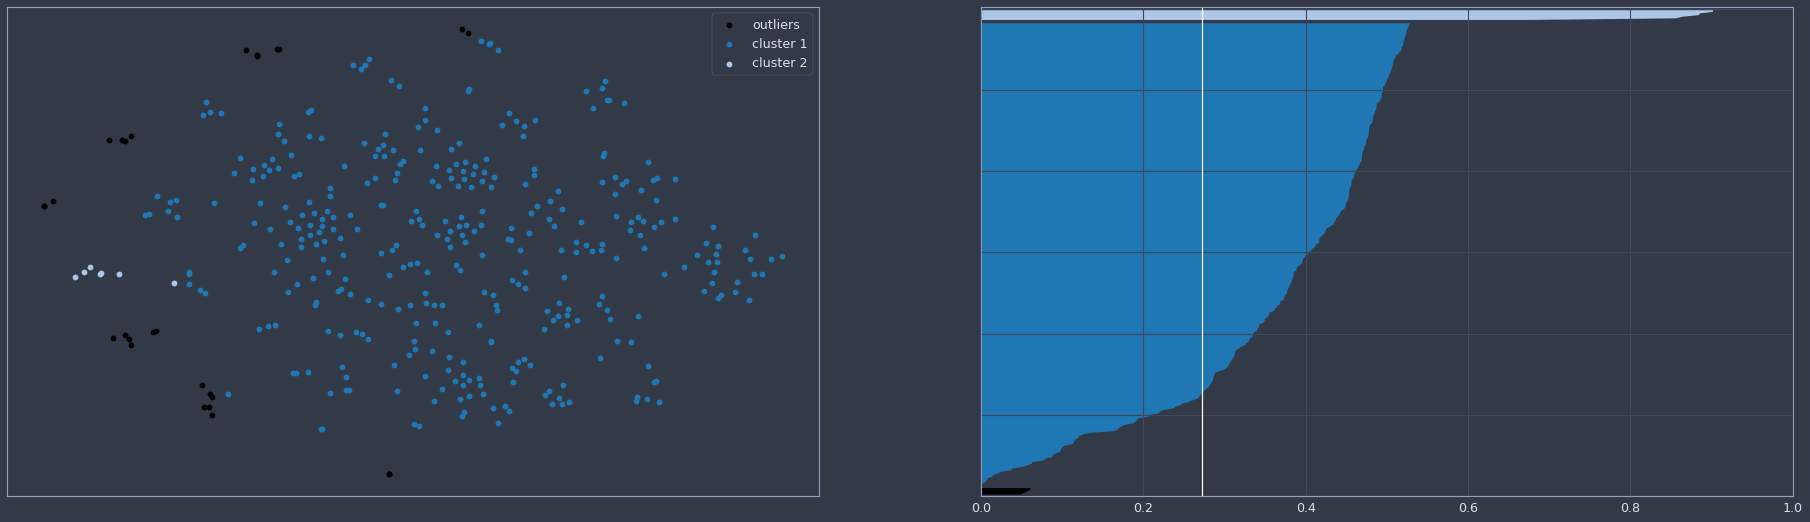

In [87]:
clits_fig

#### Hierarchical Clustering

###### Compute

In [88]:
clihie_fig,clihie_df = hierarchical_cluster(clits_df,5)
clihie_fig2          = cluster_fig(clits_df,clihie_df,'hieclu')

###### Figure

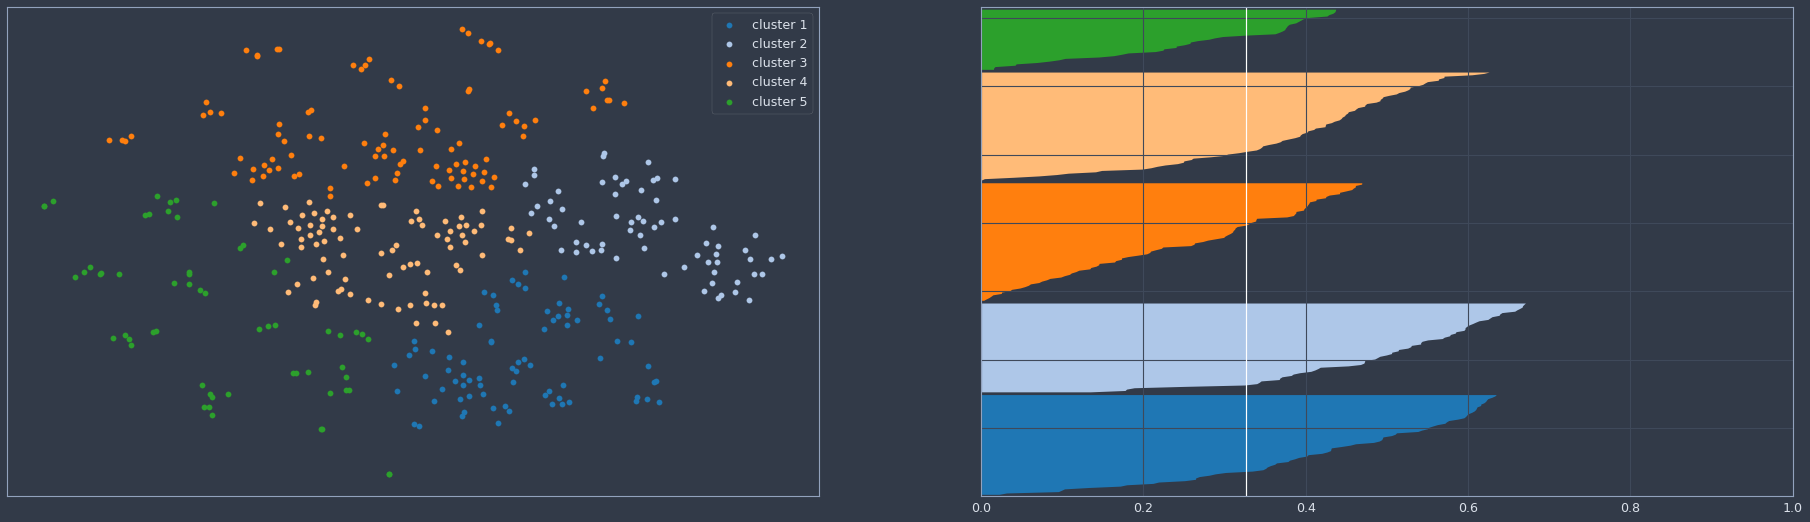

In [89]:
clihie_fig2

#### F-Test

###### Compute

In [90]:
contest_cs = sel_dc['continuous']+['clinic_cluster']
impsv_df = assign_clusters(imp_df,clihie_df,label,'hieclu')
clif_df,clinull_df = f_pvalues(impsv_df[contest_cs],label,.05)
clifstat_fig = fstat_fig(impsv_df,clif_df,label)
clif_df.head(10)

,p_value,f_stat
P28845,0.000126,49.287874
P14317,0.000126,42.645546
P12724,0.000126,36.915837
Q13241,0.000126,35.516604
P42830,0.000126,34.845685
Q6DN72,0.000126,33.699316
Q9UMR7,0.000126,33.447485
Q96LA6,0.000126,33.370690
pelod.hem,0.000126,33.273078
P30044,0.000126,32.723794


###### Figure

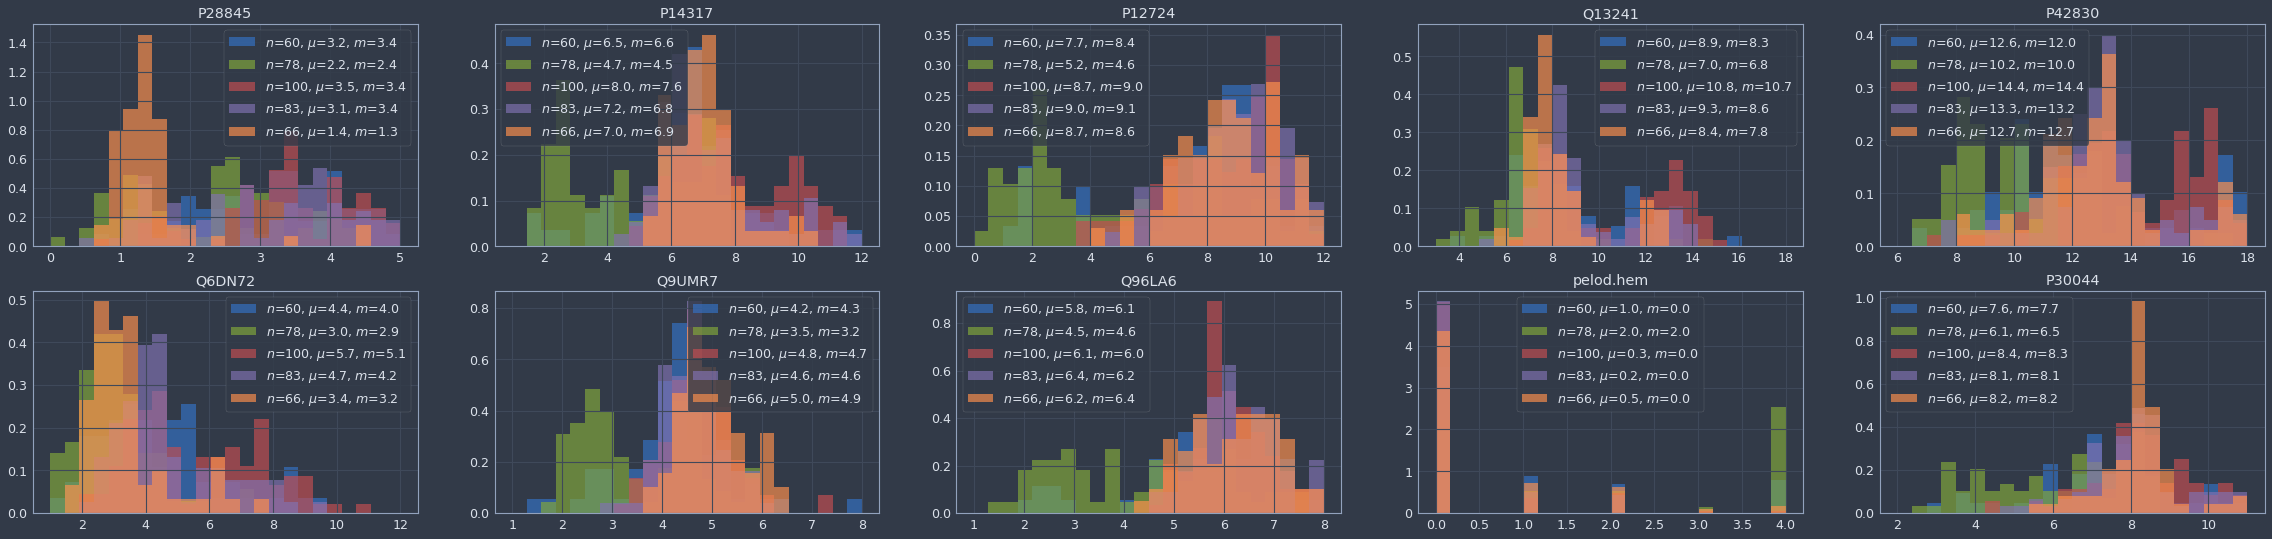

In [91]:
clifstat_fig

### Proteomic View

#### Definition

###### Definition

In [92]:
pro_df = std_df[protein_cs].copy(deep=True)

###### Orthogonalization

In [93]:
pro_odf = ortho_project(pro_df,dem_df)

#### Clustering Optimization

###### Grid Search

In [94]:
label  = 'protein'
proopt_df = cluster_optimization(pro_odf,n_states,n_comps,epss,minss,label)
proopt_df.head(3)

,dim,state,epsilon,n_mins,n_clusters,silhouette
1597,2,86,5.2,26,4,0.586161
1630,2,86,5.3,28,4,0.586161
1567,2,86,5.1,27,4,0.586161


###### Compute Silhouettes

In [95]:
prots_df,proclu_df = optimal_clusters(pro_odf,proopt_df)
prots_fig          = cluster_fig(prots_df,proclu_df,'dbscan')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.42s/it]


###### Figure

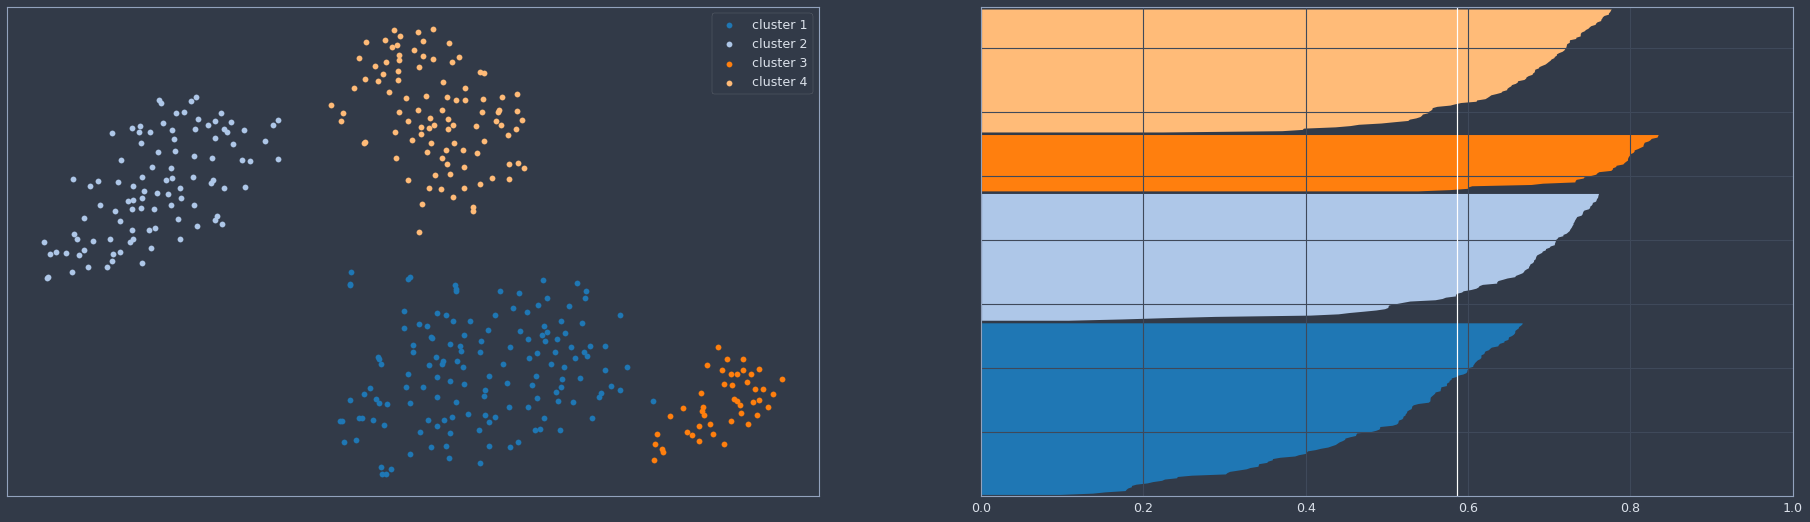

In [96]:
prots_fig

#### Hierarchical Clustering

###### Compute

In [97]:
prohie_fig,prohie_df = hierarchical_cluster(prots_df,4)
prohie_fig2          = cluster_fig(prots_df,prohie_df,'hieclu')

###### Figure

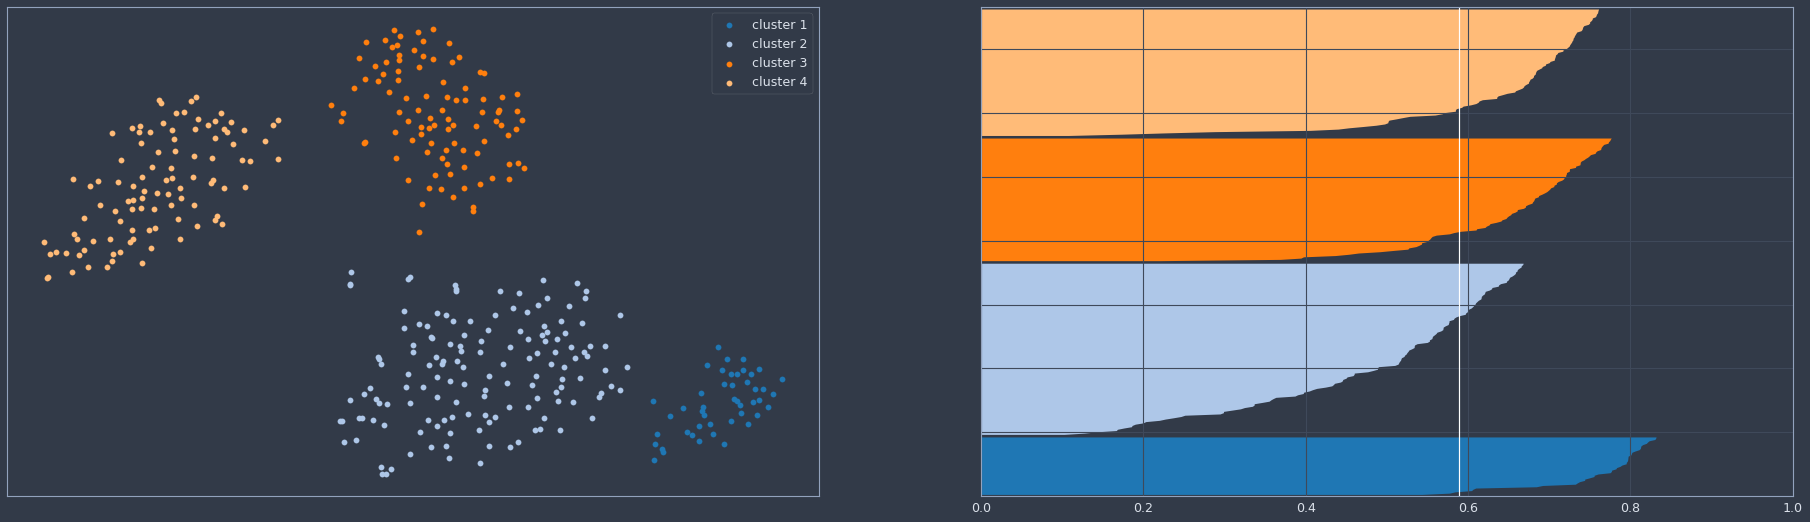

In [98]:
prohie_fig2

#### F-Test

###### Compute

In [99]:
contest_cs = sel_dc['continuous']+['protein_cluster']
impsv_df = assign_clusters(imp_df,prohie_df,label,'hieclu')
prof_df,pronull_df = f_pvalues(impsv_df,label,.05)
profstat_fig = fstat_fig(impsv_df,prof_df,label)
prof_df.head(10)

,p_value,f_stat
P09603,0.000104,60503.034979
P52823,0.000104,4799.970114
P29460,0.000104,4768.804533
Q14116,0.000104,4223.093204
P80162,0.000104,3678.623969
P15692,0.000104,3384.360411
P06127,0.000104,3324.683788
Q96PD2,0.000104,2987.674237
P50591,0.000104,2722.365029
P48740,0.000104,2372.070910


###### Figure

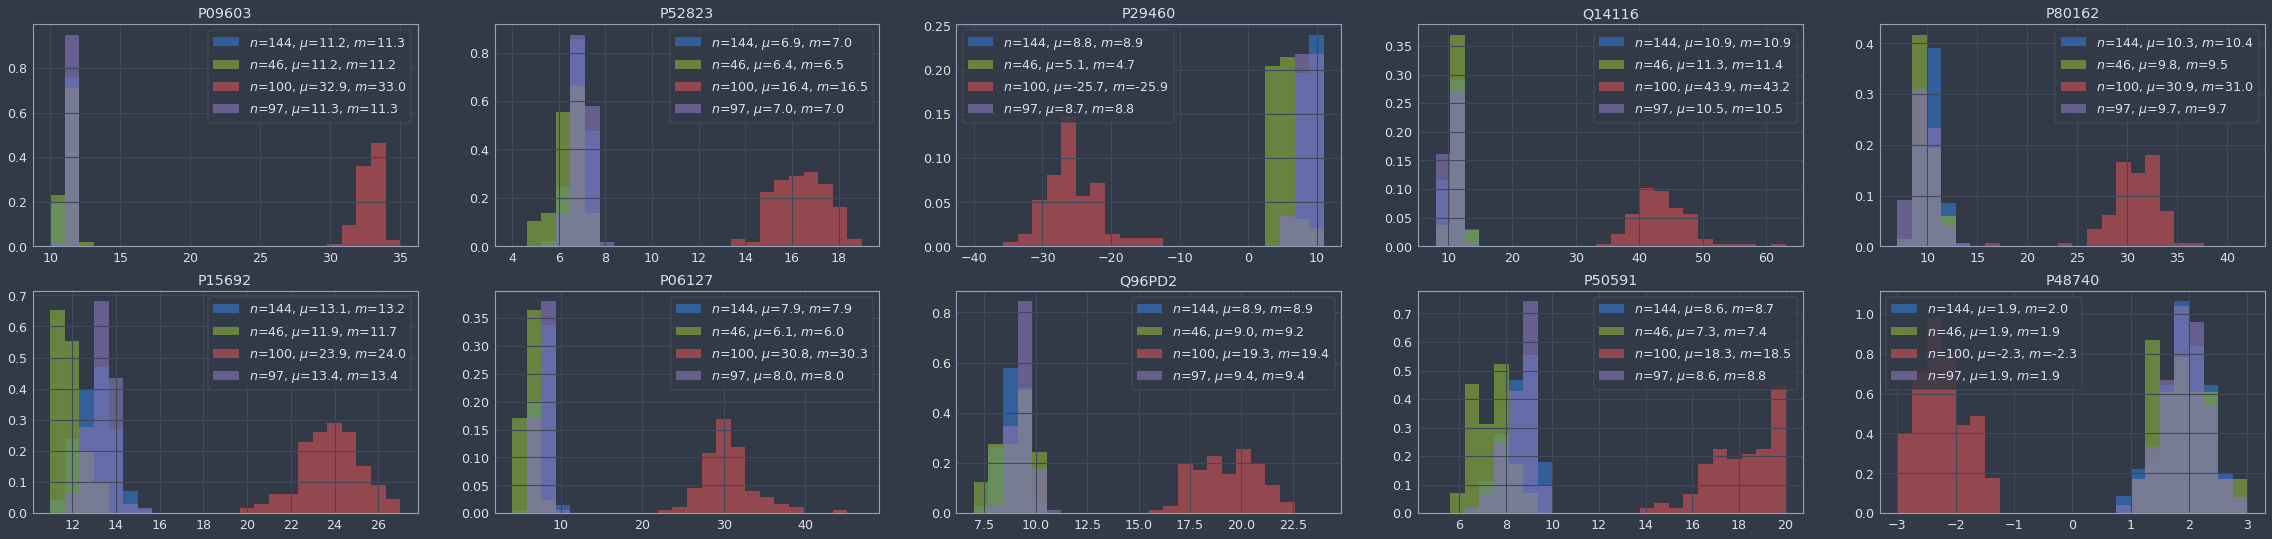

In [100]:
profstat_fig

## Multi-View Clustering

## Gene Ontology Term Enrichment

## Biomarker Search